# Setup

Loading python, R, helper functions (e.g. make_slurm), etc.

In [2]:
import sys,os,re,glob,shutil,pickle,subprocess,math
import pandas as pd
import numpy as np
import time
import itertools
import random
from tqdm import tqdm
sys.path.append('/private/groups/shapirolab/brock/Software')
from py3_functions import *

from IPython.display import display

workdir = '/private/groups/shapirolab/brock/bears/'
!mkdir -p $workdir
os.chdir(workdir)
!mkdir -p cmds logs

## R
from rpy2 import rinterface
#from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython

samples = {}
with open('poplists/bears.txt','r') as infile:
    next(infile)
    for line in infile:
        line = line.strip()
        common, species, ACC, path = line.split('\t')
        samples[common] = [species, ACC, path]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Quick R library load in kernel

In [4]:
%%R 
library(ggplot2)
library(tidyverse)
library(magrittr)
library(data.table)
library(ggtree)
library(aplot)

# Range maps for Fig. 1

Shape files were downloaded previously from IUCN:

In [6]:
%%R
library(sf)
fs = list.files('./bear_ranges/',pattern = 'shp', recursive = TRUE, full.names = T)
ranges  = lapply(fs,function(PATH){st_read(PATH)})

Reading layer `data_0' from data source 
  `/private/groups/shapirolab/brock/bears/bear_ranges/redlist_species_data_1dfc5cec-948d-424b-b8fe-4c817a572284/data_0.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 15 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 101.8949 ymin: 28.10512 xmax: 108.7991 ymax: 34.00143
Geodetic CRS:  WGS 84
Reading layer `data_0' from data source 
  `/private/groups/shapirolab/brock/bears/bear_ranges/redlist_species_data_706c9814-239a-4c71-842e-26c829022671/data_0.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 40 features and 15 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 89.71869 ymin: -5.941431 xmax: 119.2661 ymax: 29.15101
Geodetic CRS:  WGS 84
Reading layer `data_0' from data source 
  `/private/groups/shapirolab/brock/bears/bear_ranges/redlist_species_data_90bef233-91b1-40df-abdb-715faeee2a2d/data_0.shp' 
  using driver `ESRI Shapefile'
Simple

R[write to console]: Spherical geometry (s2) switched off

R[write to console]: although coordinates are longitude/latitude, st_intersection assumes that they
are planar

R[write to console]: Spherical geometry (s2) switched on



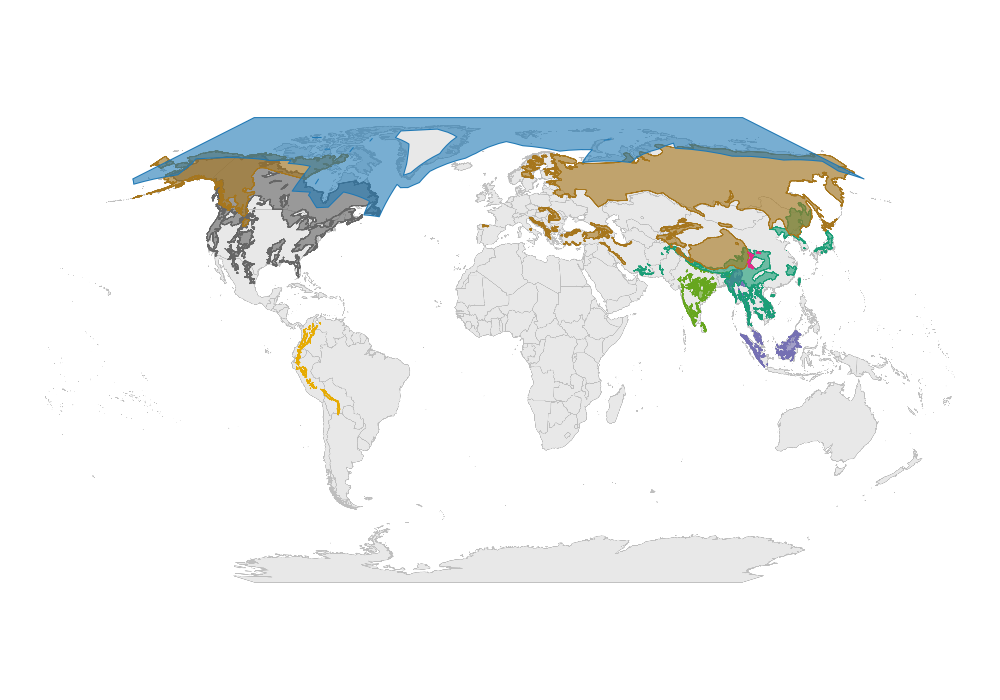

In [7]:
%%R -w 1000 -h 700
library(rnaturalearth)
library(rmapshaper)
library(ggrastr)
library(sf)
library(sp)

world <- ne_countries(type = 'countries', scale = "large", returnclass = "sf") %>%
  st_set_crs(4326)

robinson <- "+proj=robin +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

world_robinson_90w <- world %>%
  st_break_antimeridian(lon_0 = 0) %>%
  st_transform(crs = robinson)
bbox <- st_as_sfc(st_bbox(world_robinson_90w))

polar_range_simplified <- ms_simplify(ranges[[7]] %>% filter(LEGEND == 'Extant (resident)'), keep = 0.95)

aval = 0.6
bt = 0.5
p =
  ggplot() +
  rasterize(geom_sf(data = world_robinson_90w, fill = '#E8E8E8', color = 'gray', lwd = 0.25),dpi = 300) +
  # Sun
  rasterize(geom_sf(data = ranges[[2]] %>% filter(LEGEND == 'Extant (resident)'), 
          lwd = bt, alpha = aval, fill = '#7570b3', color = '#7570b3'),dpi = 300) +
  # Sloth
  rasterize(geom_sf(data = ranges[[3]] %>% filter(LEGEND == 'Extant (resident)'), 
          lwd = bt, alpha = aval, fill = '#66a61e', color = '#66a61e'),dpi = 300) +
  # Spectacled
  rasterize(geom_sf(data = ranges[[4]] %>% filter(LEGEND == 'Extant (resident)'), 
          lwd = bt, alpha = aval, fill = '#e6ab02', color = '#e6ab02'),dpi = 300) +
  # Asiatic
  rasterize(geom_sf(data = ranges[[5]] %>% filter(LEGEND == 'Extant (resident)'), 
          lwd = bt, alpha = aval, fill = '#1b9e77', color = '#1b9e77'),dpi = 300) +
  # Black
  rasterize(geom_sf(data = ranges[[6]] %>% filter(LEGEND == 'Extant (resident)'), 
          lwd = bt, alpha = aval, fill = '#666666', color = '#666666'),dpi = 300) +
  # Brown
  rasterize(geom_sf(data = ranges[[8]] %>% filter(LEGEND == 'Extant (resident)'), 
          lwd = bt, alpha = aval, fill = '#a6761d', color = '#a6761d'),dpi = 300) +
  # Panda
  rasterize(geom_sf(data = ranges[[1]] %>% filter(LEGEND == 'Extant (resident)'), 
          lwd = bt, alpha = aval, fill = '#e7298a', color = '#e7298a'),dpi = 300) +
  # Polar
  geom_sf(data = polar_range_simplified, 
         lwd = bt, alpha = aval, fill = '#1f78b4', color = '#1f78b4') +
  # Limits
  theme_void()

print(p)

#ggsave('./bear_paper_raw_figures/ranges.pdf',width=10,height=7)

I'll clean up the polar range manually in Illustrator

# Generating 'guide tree' for ProgressiveCactus

The sections below:
1) Annotate each genome for mammalia BUSCOs using compleasm
2) Build gene trees from these BUSCOs
3) Use ASTRAL to build a multispecies coalescent tree
4) Add branch lengths to terminal branches afterwards with IQTREE (this is because ASTRAL single-sample tips have no BLs)

## Run compleasm

In [1491]:
!mkdir -p BUSCO
for COMMON, DATA in samples.items():
    if COMMON not in ['cat','dog']: continue
    !mkdir -p BUSCO/$COMMON
    asm = f"assemblies/{COMMON}.fasta"
    busco = f"BUSCO/{COMMON}/summary.txt"
    if not os.path.exists(asm): continue
    if os.path.exists(busco): continue
    cmd = ('''compleasm run -a {asm} -l mammalia_odb10 -L BUSCO/{COMMON}/ --t 16 -o BUSCO/{COMMON} > logs/{COMMON}.busco.out 2>&1\n''').format(asm = asm, COMMON = COMMON)
    slurm = make_slurm(echo = False, p = 'long', id = f"{COMMON}.busco", cmd_string = cmd, c = '16', mem = '40000',time = '24:00:00')

## Gene trees
### Select sequences

In [1559]:
%%R
fs = list.files('BUSCO/', pattern='*full_table.tsv*', recursive = T, full.names = T)
full = bind_rows(lapply(fs,function(PATH){fread(PATH) %>% mutate(path = PATH)}))
full %<>% mutate(species = gsub('BUSCO//','',path) %>% gsub('/.*$','',.))

In [1563]:
%%R
single_well_rep =
    full %>%
    filter(Status == 'Single') %>%
    mutate(Length = `Gene End`- `Gene Start`) %>%
    group_by(Gene) %>%
    summarize(count = n(), Mean_L = mean(Length)) %>% 
    #filter(count == 8, Mean_L > 500, Mean_L < 2000) %>%
    filter(count == 11) %>%
    ungroup# %>%
    #sample_n(500)

single_well_rep
#ggplot(single_well_rep) +
#    geom_histogram(aes(x = count), binwidth = 1) + 
#    theme_classic()

# A tibble: 8,508 × 3
   Gene          count  Mean_L
   <chr>         <int>   <dbl>
 1 100001at40674    11   5248.
 2 100033at40674    11  28746.
 3 100048at40674    11  29763.
 4 100052at40674    11   5696.
 5 100056at40674    11  11831.
 6 100066at40674    11  21361.
 7 1000at40674      11 187862.
 8 100106at40674    11  11048 
 9 100136at40674    11   4821.
10 100137at40674    11  25048.
# ℹ 8,498 more rows
# ℹ Use `print(n = ...)` to see more rows


Write out good buscos for easy use later on

In [1566]:
%%R
full %>% 
    filter(Gene %in% single_well_rep$Gene) %>%
    dplyr::select(species,Gene,`Best gene`) %>%
    fwrite('busco_all.txt',col.names=F,sep="\t")

The fastas generated by compleasm are already linearized, I just do some convenient renaming here. This will make it easy to quickly fetch a BUSCO from a species.

In [1567]:
%%bash
find BUSCO/ -name "translated_protein.fasta" | while read FILE;do
    SPECIES=$(echo $FILE | sed "s|BUSCO/||;s|/mammalia.*$||" );
    NEWFILE=$(echo $FILE | sed "s/protein/protein.clean/");
    sed -e "s/|.*$/_$SPECIES/" $FILE > $NEWFILE;
done

Now is where I actually collect sequences, align them, and build a tree

In [8]:
## Read in set of BUSCOS
GENES = []
with open('busco_all.txt','r') as infile:
    for line in infile:
        line = line.strip()
        SPECIES, GENE, BESTGENE = line.split('\t')
        if GENE not in GENES:
            GENES.append(GENE)
infile.close()


## Construct tree building commands
outfile = open('cmds/collect.txt','w')
for GENE in GENES:
    cmd = ('''rm -f alignments/raw/{GENE}.fa;touch alignments/raw/{GENE}.fa\n'''
           '''grep "\\<{GENE}\\>" busco_all.txt | while read SPECIES GENE BESTGENE;do grep -A1 "$BESTGENE" BUSCO/$SPECIES/mammalia_odb10/translated_protein.clean.fasta >> alignments/raw/{GENE}.fa;done\n'''
           '''mafft --auto alignments/raw/{GENE}.fa > alignments/aligned/{GENE}.fa\n'''
           '''trimal -in alignments/aligned/{GENE}.fa -out alignments/trimmed/{GENE}.fa  -fasta -sident -keepheader >  alignments/trimmed/{GENE}.fa.out\n'''
           '''sed "s/.*:/>/;s/_/REMOVE/1;s/>.*REMOVE/>/" alignments/trimmed/{GENE}.fa > alignments/clean/{GENE}.fa\n'''
           '''iqtree --redo -pre trees/raw/{GENE} -s alignments/clean/{GENE}.fa -redo -st AA -m Q.mammal+I+G -nt 2 -B 1000 -bnni > logs/{GENE}.iqtree.out 2>&1 ''').format(GENE = GENE)
    collectfile = open(f"cmds/{GENE}.collect.sh",'w')
    collectfile.write('#!/bin/bash\n' + cmd + '\n')
    collectfile.close()
    outfile.write(f'bash cmds/{GENE}.collect.sh\n')
outfile.close()

## Submit job
slurmcmd = f"cat cmds/collect.txt | parallel --progress --jobs 64 "
slurm = make_slurm(run = False, id = f"collect", cmd_string = slurmcmd, mem = '5000',time='48:00:00',p = 'long', c = 64)

Submitted batch job 3344665
Submitted batch job 3344666
Submitted batch job 3344667
Submitted batch job 3344668
Submitted batch job 3344669
Submitted batch job 3344670
Submitted batch job 3344671
Submitted batch job 3344672
Submitted batch job 3344673
Submitted batch job 3344674
Submitted batch job 3344675
Submitted batch job 3344676
Submitted batch job 3344677
Submitted batch job 3344678
Submitted batch job 3344679
Submitted batch job 3344680
Submitted batch job 3344681
Submitted batch job 3344682
Submitted batch job 3344683
Submitted batch job 3344684
Submitted batch job 3344685
Submitted batch job 3344686
Submitted batch job 3344687
Submitted batch job 3344688
Submitted batch job 3344689
Submitted batch job 3344690
Submitted batch job 3344691
Submitted batch job 3344692
Submitted batch job 3344693
Submitted batch job 3344694
Submitted batch job 3344695
Submitted batch job 3344696
Submitted batch job 3344697
Submitted batch job 3344698
Submitted batch job 3344699
Submitted batch job 

Submitted batch job 3344959
Submitted batch job 3344960
Submitted batch job 3344961
Submitted batch job 3344962
Submitted batch job 3344963
Submitted batch job 3344964
Submitted batch job 3344965
Submitted batch job 3344966
Submitted batch job 3344967
Submitted batch job 3344968
Submitted batch job 3344969
Submitted batch job 3344970
Submitted batch job 3344971
Submitted batch job 3344972
Submitted batch job 3344973
Submitted batch job 3344974
Submitted batch job 3344975
Submitted batch job 3344976
Submitted batch job 3344977
Submitted batch job 3344978
Submitted batch job 3344979
Submitted batch job 3344980
Submitted batch job 3344981
Submitted batch job 3344982
Submitted batch job 3344983
Submitted batch job 3344984
Submitted batch job 3344985
Submitted batch job 3344986
Submitted batch job 3344987
Submitted batch job 3344988
Submitted batch job 3344989
Submitted batch job 3344990
Submitted batch job 3344991
Submitted batch job 3344992
Submitted batch job 3344993
Submitted batch job 

Submitted batch job 3345252
Submitted batch job 3345253
Submitted batch job 3345254
Submitted batch job 3345255
Submitted batch job 3345256
Submitted batch job 3345257
Submitted batch job 3345258
Submitted batch job 3345259
Submitted batch job 3345263
Submitted batch job 3345264
Submitted batch job 3345265
Submitted batch job 3345266
Submitted batch job 3345267
Submitted batch job 3345268
Submitted batch job 3345269
Submitted batch job 3345270
Submitted batch job 3345271
Submitted batch job 3345272
Submitted batch job 3345273
Submitted batch job 3345274
Submitted batch job 3345275
Submitted batch job 3345276
Submitted batch job 3345277
Submitted batch job 3345278
Submitted batch job 3345279
Submitted batch job 3345280
Submitted batch job 3345281
Submitted batch job 3345282
Submitted batch job 3345283
Submitted batch job 3345284
Submitted batch job 3345285
Submitted batch job 3345286
Submitted batch job 3345287
Submitted batch job 3345288
Submitted batch job 3345289
Submitted batch job 

Submitted batch job 3345549
Submitted batch job 3345550
Submitted batch job 3345551
Submitted batch job 3345552
Submitted batch job 3345553
Submitted batch job 3345554
Submitted batch job 3345555
Submitted batch job 3345556
Submitted batch job 3345557
Submitted batch job 3345558
Submitted batch job 3345559
Submitted batch job 3345560
Submitted batch job 3345561
Submitted batch job 3345562
Submitted batch job 3345563
Submitted batch job 3345564
Submitted batch job 3345565
Submitted batch job 3345566
Submitted batch job 3345567
Submitted batch job 3345568
Submitted batch job 3345569
Submitted batch job 3345570
Submitted batch job 3345571
Submitted batch job 3345572
Submitted batch job 3345573
Submitted batch job 3345574
Submitted batch job 3345575
Submitted batch job 3345576
Submitted batch job 3345577
Submitted batch job 3345578
Submitted batch job 3345579
Submitted batch job 3345580
Submitted batch job 3345581
Submitted batch job 3345582
Submitted batch job 3345583
Submitted batch job 

Submitted batch job 3345842
Submitted batch job 3345843
Submitted batch job 3345844
Submitted batch job 3345845
Submitted batch job 3345846
Submitted batch job 3345847
Submitted batch job 3345848
Submitted batch job 3345849
Submitted batch job 3345850
Submitted batch job 3345851
Submitted batch job 3345852
Submitted batch job 3345853
Submitted batch job 3345854
Submitted batch job 3345855
Submitted batch job 3345856
Submitted batch job 3345857
Submitted batch job 3345858
Submitted batch job 3345859
Submitted batch job 3345860
Submitted batch job 3345861
Submitted batch job 3345862
Submitted batch job 3345863
Submitted batch job 3345864
Submitted batch job 3345865
Submitted batch job 3345866
Submitted batch job 3345867
Submitted batch job 3345868
Submitted batch job 3345869
Submitted batch job 3345870
Submitted batch job 3345871
Submitted batch job 3345872
Submitted batch job 3345873
Submitted batch job 3345874
Submitted batch job 3345875
Submitted batch job 3345876
Submitted batch job 

Submitted batch job 3346136
Submitted batch job 3346137
Submitted batch job 3346138
Submitted batch job 3346139
Submitted batch job 3346140
Submitted batch job 3346141
Submitted batch job 3346142
Submitted batch job 3346143
Submitted batch job 3346144
Submitted batch job 3346145
Submitted batch job 3346146
Submitted batch job 3346147
Submitted batch job 3346148
Submitted batch job 3346149
Submitted batch job 3346150
Submitted batch job 3346151
Submitted batch job 3346152
Submitted batch job 3346153
Submitted batch job 3346154
Submitted batch job 3346155
Submitted batch job 3346156
Submitted batch job 3346157
Submitted batch job 3346158
Submitted batch job 3346159
Submitted batch job 3346160
Submitted batch job 3346161
Submitted batch job 3346162
Submitted batch job 3346163
Submitted batch job 3346164
Submitted batch job 3346165
Submitted batch job 3346166
Submitted batch job 3346167
Submitted batch job 3346168
Submitted batch job 3346169
Submitted batch job 3346170
Submitted batch job 

Submitted batch job 3346430
Submitted batch job 3346431
Submitted batch job 3346432
Submitted batch job 3346433
Submitted batch job 3346434
Submitted batch job 3346435
Submitted batch job 3346436
Submitted batch job 3346437
Submitted batch job 3346438
Submitted batch job 3346439
Submitted batch job 3346440
Submitted batch job 3346441
Submitted batch job 3346442
Submitted batch job 3346443
Submitted batch job 3346444
Submitted batch job 3346445
Submitted batch job 3346446
Submitted batch job 3346447
Submitted batch job 3346448
Submitted batch job 3346449
Submitted batch job 3346450
Submitted batch job 3346451
Submitted batch job 3346452
Submitted batch job 3346453
Submitted batch job 3346454
Submitted batch job 3346455
Submitted batch job 3346456
Submitted batch job 3346457
Submitted batch job 3346458
Submitted batch job 3346459
Submitted batch job 3346460
Submitted batch job 3346461
Submitted batch job 3346462
Submitted batch job 3346463
Submitted batch job 3346464
Submitted batch job 

Submitted batch job 3346725
Submitted batch job 3346726
Submitted batch job 3346727
Submitted batch job 3346728
Submitted batch job 3346729
Submitted batch job 3346730
Submitted batch job 3346731
Submitted batch job 3346732
Submitted batch job 3346733
Submitted batch job 3346734
Submitted batch job 3346735
Submitted batch job 3346736
Submitted batch job 3346737
Submitted batch job 3346738
Submitted batch job 3346739
Submitted batch job 3346740
Submitted batch job 3346741
Submitted batch job 3346742
Submitted batch job 3346743
Submitted batch job 3346744
Submitted batch job 3346745
Submitted batch job 3346746
Submitted batch job 3346747
Submitted batch job 3346748
Submitted batch job 3346749
Submitted batch job 3346750
Submitted batch job 3346751
Submitted batch job 3346752
Submitted batch job 3346753
Submitted batch job 3346754
Submitted batch job 3346755
Submitted batch job 3346756
Submitted batch job 3346757
Submitted batch job 3346758
Submitted batch job 3346759
Submitted batch job 

Submitted batch job 3347019
Submitted batch job 3347020
Submitted batch job 3347021
Submitted batch job 3347022
Submitted batch job 3347023
Submitted batch job 3347024
Submitted batch job 3347025
Submitted batch job 3347026
Submitted batch job 3347027
Submitted batch job 3347028
Submitted batch job 3347029
Submitted batch job 3347030
Submitted batch job 3347031
Submitted batch job 3347032
Submitted batch job 3347033
Submitted batch job 3347034
Submitted batch job 3347035
Submitted batch job 3347036
Submitted batch job 3347037
Submitted batch job 3347038
Submitted batch job 3347039
Submitted batch job 3347040
Submitted batch job 3347041
Submitted batch job 3347042
Submitted batch job 3347043
Submitted batch job 3347044
Submitted batch job 3347045
Submitted batch job 3347046
Submitted batch job 3347047
Submitted batch job 3347048
Submitted batch job 3347049
Submitted batch job 3347050
Submitted batch job 3347051
Submitted batch job 3347052
Submitted batch job 3347053
Submitted batch job 

Submitted batch job 3347312
Submitted batch job 3347313
Submitted batch job 3347314
Submitted batch job 3347315
Submitted batch job 3347316
Submitted batch job 3347317
Submitted batch job 3347318
Submitted batch job 3347319
Submitted batch job 3347320
Submitted batch job 3347321
Submitted batch job 3347322
Submitted batch job 3347323
Submitted batch job 3347324
Submitted batch job 3347325
Submitted batch job 3347326
Submitted batch job 3347327
Submitted batch job 3347328
Submitted batch job 3347329
Submitted batch job 3347330
Submitted batch job 3347331
Submitted batch job 3347332
Submitted batch job 3347333
Submitted batch job 3347334
Submitted batch job 3347335
Submitted batch job 3347336
Submitted batch job 3347337
Submitted batch job 3347338
Submitted batch job 3347339
Submitted batch job 3347340
Submitted batch job 3347341
Submitted batch job 3347342
Submitted batch job 3347343
Submitted batch job 3347344
Submitted batch job 3347345
Submitted batch job 3347346
Submitted batch job 

Submitted batch job 3347609
Submitted batch job 3347610
Submitted batch job 3347611
Submitted batch job 3347612
Submitted batch job 3347613
Submitted batch job 3347614
Submitted batch job 3347615
Submitted batch job 3347616
Submitted batch job 3347617
Submitted batch job 3347618
Submitted batch job 3347619
Submitted batch job 3347620
Submitted batch job 3347621
Submitted batch job 3347622
Submitted batch job 3347623
Submitted batch job 3347624
Submitted batch job 3347625
Submitted batch job 3347626
Submitted batch job 3347627
Submitted batch job 3347628
Submitted batch job 3347629
Submitted batch job 3347630
Submitted batch job 3347631
Submitted batch job 3347632
Submitted batch job 3347633
Submitted batch job 3347634
Submitted batch job 3347635
Submitted batch job 3347636
Submitted batch job 3347637
Submitted batch job 3347638
Submitted batch job 3347639
Submitted batch job 3347640
Submitted batch job 3347641
Submitted batch job 3347642
Submitted batch job 3347643
Submitted batch job 

Submitted batch job 3347905
Submitted batch job 3347906
Submitted batch job 3347907
Submitted batch job 3347908
Submitted batch job 3347909
Submitted batch job 3347910
Submitted batch job 3347911
Submitted batch job 3347912
Submitted batch job 3347913
Submitted batch job 3347914
Submitted batch job 3347915
Submitted batch job 3347916
Submitted batch job 3347917
Submitted batch job 3347918
Submitted batch job 3347919
Submitted batch job 3347920
Submitted batch job 3347921
Submitted batch job 3347922
Submitted batch job 3347923
Submitted batch job 3347924
Submitted batch job 3347925
Submitted batch job 3347926
Submitted batch job 3347927
Submitted batch job 3347928
Submitted batch job 3347929
Submitted batch job 3347930
Submitted batch job 3347931
Submitted batch job 3347932
Submitted batch job 3347933
Submitted batch job 3347934
Submitted batch job 3347935
Submitted batch job 3347936
Submitted batch job 3347937
Submitted batch job 3347938
Submitted batch job 3347939
Submitted batch job 

Submitted batch job 3348200
Submitted batch job 3348201
Submitted batch job 3348202
Submitted batch job 3348203
Submitted batch job 3348204
Submitted batch job 3348205
Submitted batch job 3348206
Submitted batch job 3348207
Submitted batch job 3348208
Submitted batch job 3348209
Submitted batch job 3348210
Submitted batch job 3348211
Submitted batch job 3348212
Submitted batch job 3348213
Submitted batch job 3348214
Submitted batch job 3348215
Submitted batch job 3348216
Submitted batch job 3348217
Submitted batch job 3348218
Submitted batch job 3348219
Submitted batch job 3348220
Submitted batch job 3348221
Submitted batch job 3348222
Submitted batch job 3348223
Submitted batch job 3348224
Submitted batch job 3348225
Submitted batch job 3348226
Submitted batch job 3348227
Submitted batch job 3348228
Submitted batch job 3348229
Submitted batch job 3348230
Submitted batch job 3348231
Submitted batch job 3348232
Submitted batch job 3348233
Submitted batch job 3348234
Submitted batch job 

Submitted batch job 3348494
Submitted batch job 3348495
Submitted batch job 3348496
Submitted batch job 3348497
Submitted batch job 3348498
Submitted batch job 3348499
Submitted batch job 3348500
Submitted batch job 3348501
Submitted batch job 3348502
Submitted batch job 3348503
Submitted batch job 3348504
Submitted batch job 3348505
Submitted batch job 3348506
Submitted batch job 3348507
Submitted batch job 3348508
Submitted batch job 3348509
Submitted batch job 3348510
Submitted batch job 3348511
Submitted batch job 3348512
Submitted batch job 3348513
Submitted batch job 3348514
Submitted batch job 3348515
Submitted batch job 3348516
Submitted batch job 3348517
Submitted batch job 3348518
Submitted batch job 3348519
Submitted batch job 3348520
Submitted batch job 3348521
Submitted batch job 3348522
Submitted batch job 3348523
Submitted batch job 3348524
Submitted batch job 3348525
Submitted batch job 3348526
Submitted batch job 3348527
Submitted batch job 3348528
Submitted batch job 

Submitted batch job 3348791
Submitted batch job 3348792
Submitted batch job 3348793
Submitted batch job 3348794
Submitted batch job 3348795
Submitted batch job 3348796
Submitted batch job 3348797
Submitted batch job 3348798
Submitted batch job 3348799
Submitted batch job 3348800
Submitted batch job 3348801
Submitted batch job 3348802
Submitted batch job 3348803
Submitted batch job 3348804
Submitted batch job 3348805
Submitted batch job 3348806
Submitted batch job 3348807
Submitted batch job 3348808
Submitted batch job 3348809
Submitted batch job 3348810
Submitted batch job 3348811
Submitted batch job 3348812
Submitted batch job 3348813
Submitted batch job 3348814
Submitted batch job 3348815
Submitted batch job 3348816
Submitted batch job 3348817
Submitted batch job 3348818
Submitted batch job 3348819
Submitted batch job 3348820
Submitted batch job 3348821
Submitted batch job 3348822
Submitted batch job 3348823
Submitted batch job 3348824
Submitted batch job 3348825
Submitted batch job 

Submitted batch job 3349084
Submitted batch job 3349085
Submitted batch job 3349086
Submitted batch job 3349087
Submitted batch job 3349088
Submitted batch job 3349089
Submitted batch job 3349090
Submitted batch job 3349091
Submitted batch job 3349092
Submitted batch job 3349093
Submitted batch job 3349094
Submitted batch job 3349095
Submitted batch job 3349096
Submitted batch job 3349097
Submitted batch job 3349098
Submitted batch job 3349099
Submitted batch job 3349100
Submitted batch job 3349101
Submitted batch job 3349102
Submitted batch job 3349103
Submitted batch job 3349104
Submitted batch job 3349105
Submitted batch job 3349106
Submitted batch job 3349107
Submitted batch job 3349108
Submitted batch job 3349109
Submitted batch job 3349110
Submitted batch job 3349111
Submitted batch job 3349112
Submitted batch job 3349113
Submitted batch job 3349114
Submitted batch job 3349115
Submitted batch job 3349116
Submitted batch job 3349117
Submitted batch job 3349118
Submitted batch job 

Submitted batch job 3349377
Submitted batch job 3349378
Submitted batch job 3349379
Submitted batch job 3349380
Submitted batch job 3349381
Submitted batch job 3349382
Submitted batch job 3349383
Submitted batch job 3349384
Submitted batch job 3349385
Submitted batch job 3349386
Submitted batch job 3349387
Submitted batch job 3349388
Submitted batch job 3349389
Submitted batch job 3349390
Submitted batch job 3349391
Submitted batch job 3349392
Submitted batch job 3349393
Submitted batch job 3349394
Submitted batch job 3349395
Submitted batch job 3349396
Submitted batch job 3349397
Submitted batch job 3349398
Submitted batch job 3349399
Submitted batch job 3349400
Submitted batch job 3349401
Submitted batch job 3349402
Submitted batch job 3349403
Submitted batch job 3349404
Submitted batch job 3349405
Submitted batch job 3349406
Submitted batch job 3349407
Submitted batch job 3349408
Submitted batch job 3349409
Submitted batch job 3349410
Submitted batch job 3349411
Submitted batch job 

Submitted batch job 3349670
Submitted batch job 3349671
Submitted batch job 3349672
Submitted batch job 3349673
Submitted batch job 3349674
Submitted batch job 3349675
Submitted batch job 3349676
Submitted batch job 3349677
Submitted batch job 3349678
Submitted batch job 3349679
Submitted batch job 3349680
Submitted batch job 3349681
Submitted batch job 3349682
Submitted batch job 3349683
Submitted batch job 3349684
Submitted batch job 3349685
Submitted batch job 3349686
Submitted batch job 3349687
Submitted batch job 3349688
Submitted batch job 3349689
Submitted batch job 3349690
Submitted batch job 3349691
Submitted batch job 3349692
Submitted batch job 3349693
Submitted batch job 3349694
Submitted batch job 3349695
Submitted batch job 3349696
Submitted batch job 3349697
Submitted batch job 3349698
Submitted batch job 3349699
Submitted batch job 3349700
Submitted batch job 3349701
Submitted batch job 3349702
Submitted batch job 3349703
Submitted batch job 3349704
Submitted batch job 

Submitted batch job 3349969
Submitted batch job 3349970
Submitted batch job 3349971
Submitted batch job 3349972
Submitted batch job 3349973
Submitted batch job 3349974
Submitted batch job 3349975
Submitted batch job 3349976
Submitted batch job 3349977
Submitted batch job 3349978
Submitted batch job 3349979
Submitted batch job 3349980
Submitted batch job 3349981
Submitted batch job 3349982
Submitted batch job 3349983
Submitted batch job 3349984
Submitted batch job 3349985
Submitted batch job 3349986
Submitted batch job 3349987
Submitted batch job 3349988
Submitted batch job 3349989
Submitted batch job 3349990
Submitted batch job 3349991
Submitted batch job 3349992
Submitted batch job 3349993
Submitted batch job 3349994
Submitted batch job 3349995
Submitted batch job 3349996
Submitted batch job 3349997
Submitted batch job 3349998
Submitted batch job 3349999
Submitted batch job 3350000
Submitted batch job 3350001
Submitted batch job 3350002
Submitted batch job 3350003
Submitted batch job 

Submitted batch job 3350262
Submitted batch job 3350263
Submitted batch job 3350264
Submitted batch job 3350265
Submitted batch job 3350266
Submitted batch job 3350267
Submitted batch job 3350268
Submitted batch job 3350269
Submitted batch job 3350270
Submitted batch job 3350271
Submitted batch job 3350272
Submitted batch job 3350273
Submitted batch job 3350274
Submitted batch job 3350275
Submitted batch job 3350276
Submitted batch job 3350277
Submitted batch job 3350278
Submitted batch job 3350279
Submitted batch job 3350280
Submitted batch job 3350281
Submitted batch job 3350282
Submitted batch job 3350283
Submitted batch job 3350284
Submitted batch job 3350285
Submitted batch job 3350286
Submitted batch job 3350287
Submitted batch job 3350288
Submitted batch job 3350289
Submitted batch job 3350290
Submitted batch job 3350291
Submitted batch job 3350292
Submitted batch job 3350293
Submitted batch job 3350294
Submitted batch job 3350295
Submitted batch job 3350296
Submitted batch job 

## ASTRAL

Now that the gene trees are constructed, I collect them in a single file, contract and low support branches

In [1570]:
%%bash
cat $(ls trees/raw/*treefile) > trees/alltrees.tre
wc -l trees/alltrees.tre

## Contract low support branches
nw_ed  trees/alltrees.tre 'i & b<=10' o > trees/alltrees_BS10.tre

8247 trees/alltrees.tre


Now build the tree with ASTRAL. This runs stupid quick, my slurm params are overkill

In [1572]:
cmd = ('''java -Xmx10g -jar '''
       '''/private/groups/shapirolab/brock/Software/ASTRAL/Astral/astral.5.7.8.jar '''
       '''--outgroup cat '''
       '''--exact '''
       '''-i trees/alltrees_BS10.tre -o trees/astral_n11 ''')
slurm = make_slurm(run = False, p = 'long', id = "astral", cmd_string = cmd, mem = '12000', time = '12:00:00')

Submitted batch job 8864096


Read in and root tree, then write rooted tree. Tree looks about as expected btw

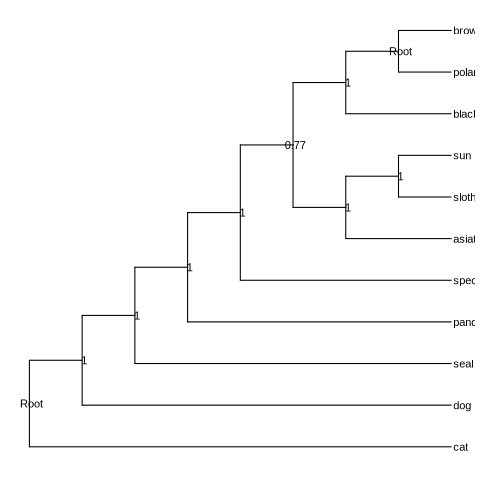

In [1574]:
%%R
library(ggtree)
tr = read.tree('trees/astral_n11')
tr = ape::root(tr,'cat',resolve.root = TRUE)
tr$edge.length = NULL
p =
    ggtree(tr) +
    geom_tiplab() +
    geom_nodelab()
print(p)
ape::write.tree(tr, 'trees/astral_n11_rooted')

## IQTREE branch lengths

Now I add proper branch lengths to the ASTRAL topology using the same genes I built gene trees with.
I just grab 100 genes here - all these steps are just to make a decen guide tree for ProgressiveCactus and some early work. I'll be generating a more robust tree with proper branch lenths and divergence times later on.

In [1575]:
%%bash
rm -rf trees/partitions.nex
echo -e "#nexus\nbegin sets;" > trees/partitions.nex

i=0
partstring="\tcharpartition mine = "

## Loop through all trees
while read FILE; do

    ## Get gene name
    GENE=$(echo $FILE |sed "s|.*/||;s|.treefile||");
    
    ## Get alignment size
    samtools faidx alignments/clean/$GENE.fa
    SIZE=$(head -n 1 alignments/clean/$GENE.fa.fai | cut -f2)
    
    ## If it's a large enough alignment, add to partition set
    if [[ $SIZE -gt 1000 ]];then 
        echo -e "\tcharset part${i} = alignments/clean/${GENE}.fa:AA, *;" >> trees/partitions.nex;
        
        ## Counter - if you reach 100 genes, stop and exit. 
        i=$(($i + 1))
        if [[ "$i" -gt 100 ]];then break;fi;
    fi;
done <<< $(ls trees/raw/*treefile*)

## Do some final formatting bits
partstring=$(echo $partstring | sed "s/,$/;\n/")
#echo -e $partstring >> trees/partitions.nex
echo -e "end;" >> trees/partitions.nex

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


Now run with IQTREE, fixed topology (`-g`)

In [1578]:
cmd = ('''iqtree -p trees/partitions.nex -T 8 -redo -g trees/astral_n11_rooted -m MFP+MERGE --prefix trees/astral_n11_BL''')
slurm = make_slurm(run = False, id = f"astral_BL", cmd_string = cmd, mem = '10000',time = '24:00:00', p = 'long', c = '8')

Submitted batch job 8864146
Submitted batch job 8864147
Submitted batch job 8864148


A quick check. It looks good!

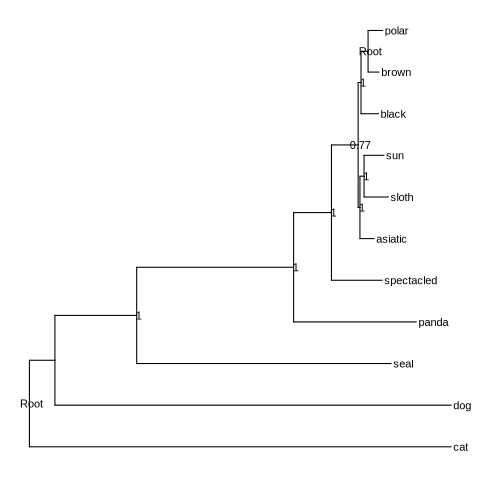

In [1579]:
%%R
tr = read.tree('trees/astral_n11_BL.treefile')
x = treeio::root(tr, outgroup = 'cat', resolve.root = TRUE)
y = phytools::midpoint.root(x)
p =
    ggtree(y) +
    geom_tiplab() +
    geom_nodelab()
print(p)
ape::write.tree(y, 'trees/astral_n11_BL_rooted.nwk')

# Progressive Cactus alignment of bear + carnivore genomes

Setup config files

In [1593]:
%%bash
mkdir -p cactus

##
rm -f poplists/masked_genomes.txt
tail -n+2 poplists/bears.txt | cut -f1 | while read SAMPLE;do
    echo -e "$SAMPLE\trepeats/$SAMPLE/$SAMPLE.fasta.masked" >> poplists/masked_genomes.txt
done
##

##
cat trees/custom_BL_rooted.nwk poplists/masked_genomes.txt > cactus/bears.seqfile
##

With 11 species, Cactus runs pretty damn quick. I run the main job of a head node, and provide the necessary parameters to use slurm, gpus, cpus, etc. all with reasonable limits.
**Note** Sometimes Cactus just fails randomly and needs some tweaking and a restart - I definitely had to do this a few times off-notebook.

In [10]:
## Full run command
cmd = ('''cactus bears_jobs cactus/bears.seqfile new-output/bears_w_outgroups.hal '''
       '''--gpu 8 '''
       '''--batchSystem slurm '''
       '''--slurmPartition long --slurmGPUPartition gpu '''
       '''--consCores 64 '''
       '''--lastzCores 64 --lastzMemory 495Gi '''
       ## Config file for the GI
       '''--configFile config-v298-keg-patch.xml '''
       '''--targetTime 1500 '''
       '''--binariesMode docker ''')
print(cmd)

cactus bears_jobs cactus/bears.seqfile new-output/bears_w_outgroups.hal --gpu 8 --batchSystem slurm --slurmPartition long --slurmGPUPartition gpu --consCores 64 --lastzCores 64 --lastzMemory 495Gi --configFile config-v298-keg-patch.xml --targetTime 1500 --binariesMode docker 


Below is some alternative code using `cactus-prepare` - this lists out all the individual job steps that cactus will implement with the above command, so then you can parse through and run things individually as needed and troubleshoot. I did this for earlier iterations of the alignment when I was trying to understand interactions between ProgressiveCactus and the HPC, but in most cases you probably don't need to do this. 

In [1621]:
!mkdir -p new-output jobs

## Setup
cmd = ('''cactussetup\n'''
       '''cp /private/groups/cgl/cactus/cactus-bin-v2.9.3/src/cactus/cactus_progressive_config.xml ./config-slurm.xml\n'''
       # Uncomment the below if you're only using cpus for the blast step
       #'''sed -i config-slurm.xml -e \'s/blast chunkSize="30000000"/blast chunkSize="90000000"/g\'\n'''
       #'''sed -i config-slurm.xml -e \'s/dechunkBatchSize="1000"/dechunkBatchSize="200"/g\'\n'''
       '''export TOIL_SLURM_ARGS="--partition=long --time=8000"\n'''
       '''mkdir -p ./batch_logs/\n'''
       '''\n\n'''
       
## Prepare cmd      
       '''cactus-prepare cactus/bears.seqfile '''
       '''--outDir new-output '''
       '''--outSeqFile new-output/bears.txt '''
       '''--outHal new-output/bears_w_outgroups.hal '''
       '''--jobStore bears_jobs '''
       '''--gpu 8 '''
       '''--preprocessDisk 250Gi --preprocessCores 64 --preprocessMemory 120Gi '''
       '''--blastDisk 250Gi --blastCores 64 --blastMemory 512Gi '''
       '''--alignDisk 250Gi --alignCores 64 --alignMemory 512Gi '''
       '''--halAppendDisk 1000Gi '''
       '''--defaultMemory 104Gi > jobs/workflow.txt\n'''
      '''''')
print(cmd)

cactussetup
cp /private/groups/cgl/cactus/cactus-bin-v2.9.3/src/cactus/cactus_progressive_config.xml ./config-slurm.xml
export TOIL_SLURM_ARGS="--partition=long --time=8000"
mkdir -p ./batch_logs/


cactus-prepare cactus/bears.seqfile --outDir new-output --outSeqFile new-output/bears.txt --outHal new-output/bears_w_outgroups.hal --jobStore bears_jobs --gpu 8 --preprocessDisk 250Gi --preprocessCores 64 --preprocessMemory 120Gi --blastDisk 250Gi --blastCores 64 --blastMemory 512Gi --alignDisk 250Gi --alignCores 64 --alignMemory 512Gi --halAppendDisk 1000Gi --defaultMemory 104Gi > jobs/workflow.txt



After tunning the above, everything you need is in `jobs/workflow.txt`

# Gene trees & species trees

## Identify genomic regions

The first thing I'm going to do is trawl the alignment in either brown-bear or sloth-bear referenced coordinates, and get the average alignment depth. See below

In [12]:
### Version formated for  SLOTH BEAR ###
fai = {}
with open('steps-output/sloth.fasta.masked.fai','r') as infile:
    for line in infile:
        parts = line.strip().split('\t')
        chrom, size = parts[0:2]
        size = int(size)
        if size < 20e6: 
            if chrom != 'mtDNA':
                continue
        fai[chrom] = size
infile.close()

!mkdir -p treemaxxing/single/sloth
for CHROM, SIZE in fai.items():
    cmd = ('''halAlignmentDepth bears.hal sloth --refSequence {CHROM} --noAncestors | '''
          '''wig2bed --max-mem=8G | cut -f1,2,3,5 | '''
          '''/private/groups/shapirolab/brock/Software/bedGraphPack stdin misc/sloth/{CHROM}.depth.bed\n'''
          '''rm -rf misc/sloth/{CHROM}.depth.wig''').format(CHROM = CHROM)
    
    slurm = make_slurm(echo = False, 
                       id = f"{CHROM}.depth",
                       cmd_string = cmd, 
                       mem = '20000', 
                       time = '24:00:00',
                       p = 'long')


Summarize and visualize alignment depth

         chrom start   end depth length
        <char> <int> <int> <num>  <int>
1: NC_079873.1     0     1     4      1
2: NC_079873.1     1     6     3      5
3: NC_079873.1     6   409     4    403
4: NC_079873.1   409   415     3      6
5: NC_079873.1   415   420     4      5
6: NC_079873.1   420   421     3      1


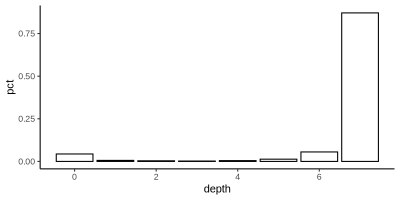

In [13]:
%%R -w 400 -h 200
beddepth = 
    bind_rows(lapply(list.files('misc/brown',pattern = 'depth.bed',full.names = T),function(PATH){fread(PATH)})) %>% 
    set_colnames(c('chrom','start','end','depth')) %>%
    mutate(length = end - start)
head(beddepth) %>% print
gsize = sum(beddepth$length)
summary =
    beddepth %>% 
    group_by(depth) %>%
    summarize(pct = sum(length)/gsize)
ggplot(summary) +
    geom_bar(aes(x = depth, y = pct), stat = 'identity', fill = 'white', color = 'black') +
    theme_classic()

Just looking at the above, I like the idea of writing out regions that are covered by 6-7 bears. That's what I write out below

In [ ]:
%%R
library(bedtoolsr)
beddepth %>% 
    filter(depth >=6) %>%
    bedtoolsr::bt.merge(.) %>%
    dplyr::select(V1,V2,V3) %>% 
    fwrite(.,'brown_referenced_d6_d7.bed', col.names = F,sep="\t")

I've shared the above brown- and sloth- referenced regions with Lexi, which she used for 10kb and 50kb gene tree construction. In the steps below, I did some of my own messing around with gene trees from noncoding and coding sequences:

Now, I'm going to use the brown bear/sloth bear annotations to create different sets of coding and non-coding loci for tree building.

In [858]:
%%R

## I generated the below off-screen with awk and the gff3 file to create simple beds
genes = fread('annotations/brown_genes.bed')
introns = fread('annotations/introns_merged.bed')
exons = fread('annotations/exons_merged.bed')


## Write out orthologous non coding conserved regions
beddepth %>%
    ## Remove Y, mito
    filter(!chrom %in% c('NC_079874.1','NC_003427.1 ')) %>%
    filter(depth == 7) %>%
    filter(length > 250) %>%
    ## Select conserved regions that are outside of gene boundaries
    bedtoolsr::bt.intersect(., b = genes, v= TRUE) %>%
    bedtoolsr::bt.spacing(.) %>%
    filter(V6 > 5000) %>%
    dplyr::select(V1,V2,V3,V5) %>%
    fwrite(.,'treemaxxing/ortho_noncoding_conserved.bed', sep = "\t",col.names = F, row.names = F, quote = F)


## Write out intronic conserved regions
beddepth %>%
    ## Remove Y, mito
    filter(!chrom %in% c('NC_079874.1','NC_003427.1 ')) %>%
    filter(depth == 7) %>%
    filter(length > 250) %>%
    ## Select conserved regions that are fully contained within introns
    bedtoolsr::bt.intersect(., b = introns, wa = TRUE, f = 1.0) %>%
    bedtoolsr::bt.spacing(.) %>%
    filter(V6 > 5000) %>%
    dplyr::select(V1,V2,V3,V5) %>%
    fwrite(.,'treemaxxing/ortho_intron_conserved.bed', sep = "\t",col.names = F, row.names = F, quote = F)

## Write out exonic cobnserved regions
beddepth %>%
    ## Remove Y, mito
    filter(!chrom %in% c('NC_079874.1','NC_003427.1 ')) %>%
    filter(depth == 7) %>%
    filter(length > 250) %>%
    ## Select conserved regions that are fully contained within introns
    bedtoolsr::bt.intersect(., b = exons, wa = TRUE, f = 1.0) %>%
    bedtoolsr::bt.spacing(.) %>%
    filter(V6 > 5000) %>%
    dplyr::select(V1,V2,V3,V5) %>%
    fwrite(.,'treemaxxing/ortho_exon_conserved.bed', sep = "\t",col.names = F, row.names = F, quote = F)

Ok, now I should be all set to actually build trees

## Tree building

Non-coding conserved trees. Behold the ugliest code you've ever seen

In *brief*, this uses `hal2maf` to get fasta alignments for each sequence, cleans them up using some `seqkit` and `sed` magic, and builds a tree with `iqtree2`.
**Note** this section was all done a while back when the alignment only had bears in it. If I were to rerun this with the new alignment that contains other carnivores, I would need to specify `--targetGenomes` to keep the output just to bears.

In [ ]:
%%bash
## Construct commands
awk '{
    START = $2 + 1;
    OUTBASE = "treemaxxing/input/temp/" $1 "_" START "_" $3;
    CMD = "hal2maf bears.hal " OUTBASE ".maf --noAncestors --noDupes --unique --refGenome brown --refSequence " $1 " --start " START " --length " $4;
    CMD = CMD "; msa_view " OUTBASE ".maf --in-format MAF --out-format FASTA --unmask";
    CMD = CMD " | seqkit grep -n -i -r -v -p \"Anc\" | seqkit grep -n -i -r -v -p \":\" | sed \"s/\\*/N/g\" > " OUTBASE ".fa";
    CMD = CMD " && samtools faidx " OUTBASE ".fa";
    CMD = CMD "; iqtree2 -redo -s " OUTBASE ".fa -m GTR+I+G -bb 1000 -quiet";
    CMD = CMD " && mv " OUTBASE ".fa.treefile treemaxxing/input/trees/" $1 "_" START "_" $3 ".treefile";
    print CMD;
}' treemaxxing/ortho_noncoding_conserved.bed > treemaxxing/ortho_noncoding_conserved_cmds.txt

## Execute (run interactively or in slurm)
cat treemaxxing/ortho_noncoding_conserved_cmds.txt | parallel -j 32 --progress

## Organize and cleanup
find treemaxxing/input/trees -name '*.treefile' -print0 | xargs -0 cat > treemaxxing/input/ortho_noncoding_conserved.trees
mkdir empty_dir
rsync -a --delete empty_dir/ treemaxxing/input/temp
rmdir treemaxxing/input/temp
rmdir empty_dir

Combine gene trees, run ASTRAL just like before:

In [875]:
%%bash
## Contract low support branches
nw_ed treemaxxing/input/ortho_noncoding_conserved.trees 'i & b<=10' o > treemaxxing/input/ortho_noncoding_conserved_BS10.trees

In [14]:
cmd = ('''java -Xmx10g -jar '''
       '''/private/groups/shapirolab/brock/Software/ASTRAL/Astral/astral.5.7.8.jar '''
       '''--outgroup panda '''
       '''--exact '''
       '''-i treemaxxing/input/ortho_noncoding_conserved_BS10.trees -o treemaxxing/astral_ortho_noncoding ''')
slurm = make_slurm(echo = False, p = 'long', id = "astral", cmd_string = cmd, mem = '12000', time = '12:00:00')

Now visualize. This is a tree based on genome-wide orthologous nonocoding regions. It looks like the guide tree

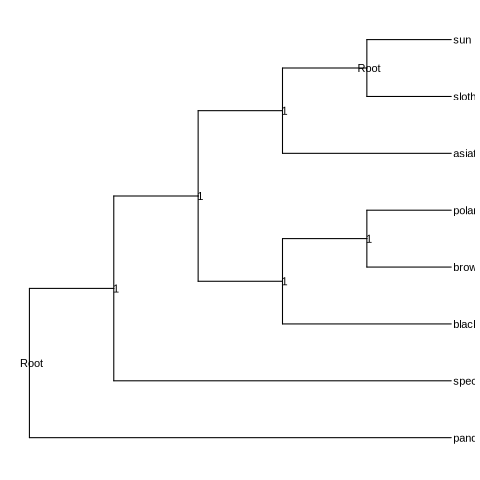

In [15]:
%%R
library(ggtree)
tr = read.tree('treemaxxing/astral_ortho_noncoding')
tr = ape::root(tr,'panda',resolve.root = TRUE)
tr$edge.length = NULL
p =
    ggtree(tr) +
    geom_tiplab() +
    geom_nodelab()
print(p)

Now, I do all the same as above, but for exons only!:

In [874]:
%%bash

awk '{
    START = $2 + 1;
    OUTBASE = "treemaxxing/input/exons_temp/" $1 "_" START "_" $3;
    CMD = "hal2maf bears.hal " OUTBASE ".maf --noAncestors --noDupes --unique --refGenome brown --refSequence " $1 " --start " START " --length " $4;
    CMD = CMD "; msa_view " OUTBASE ".maf --in-format MAF --out-format FASTA --unmask";
    CMD = CMD " | seqkit grep -n -i -r -v -p \"Anc\" | seqkit grep -n -i -r -v -p \":\" | sed \"s/\\*/N/g\" > " OUTBASE ".fa";
    CMD = CMD " && samtools faidx " OUTBASE ".fa";
    CMD = CMD "; iqtree2 -redo -s " OUTBASE ".fa -m GTR+I+G -bb 1000 -quiet";
    CMD = CMD " && mv " OUTBASE ".fa.treefile treemaxxing/input/exons_trees/" $1 "_" START "_" $3 ".treefile";
    print CMD;
}' treemaxxing/ortho_exon_conserved.bed > treemaxxing/ortho_exon_conserved_cmds.txt


cat << EOF > cmds/exons.slurm
#!/bin/bash
#SBATCH -p long
#SBATCH -t 48:00:00
#SBATCH --mem=20000
#SBATCH -n 1
#SBATCH --array=1-1%1
#SBATCH -e ./logs/exons.e
#SBATCH -o ./logs/exons.o
#SBATCH -c 64
#SBATCH -N 1
#SBATCH -J introns

mkdir -p treemaxxing/input/exons_temp/
mkdir -p treemaxxing/input/exons_trees/
cat treemaxxing/ortho_exon_conserved_cmds.txt | parallel -j 64 --progress

find treemaxxing/input/exons_trees/ -name '*.treefile' -print0 | xargs -0 cat > treemaxxing/input/ortho_exon_conserved.trees
mkdir -p empty_dir
rsync -a --delete empty_dir/ treemaxxing/input/exons_temp
rmdir treemaxxing/input/exons_temp
rmdir empty_dir
EOF

#sbatch cmds/exons.slurm

Cleanup, run Astral

In [878]:
%%bash
## Contract low support branches
nw_ed treemaxxing/input/ortho_exon_conserved.trees 'i & b<=10' o > treemaxxing/input/ortho_exon_conserved_BS10.trees

In [16]:
cmd = ('''java -Xmx10g -jar '''
       '''/private/groups/shapirolab/brock/Software/ASTRAL/Astral/astral.5.7.8.jar '''
       '''--outgroup panda '''
       '''--exact '''
       '''-i treemaxxing/input/ortho_exon_conserved_BS10.trees -o treemaxxing/astral_ortho_exon ''')
slurm = make_slurm(echo = False, p = 'long', id = "astral", cmd_string = cmd, mem = '12000', time = '12:00:00')

Finally, we visualize. Again, this looks like all the other trees.

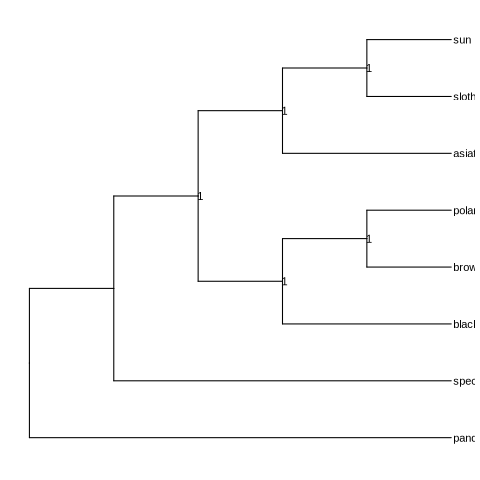

In [17]:
%%R
library(ggtree)
tr = read.tree('treemaxxing/astral_ortho_exon')
#tr = ape::root(tr,'panda',resolve.root = TRUE)
tr$edge.length = NULL
p =
    ggtree(tr) +
    geom_tiplab() +
    geom_nodelab()
print(p)

## Supp. figures phylogenies for autosomes, X chromosome, mito genome

For ease, I'm gonna do this based on the regular 50kb windows that Lexi created. See her code for details on this, but it will be a very similar combination of hal2maf, iqtree2, etc. etc.

Cleaning up and concatenating regions provided by Lexi:

In [ ]:
## Brown bear regions to use
inputwd = f"lexi/alignments/"
i = open('lexi/0_bed_files/brown_50kb.bed','r')
autosomes = []
chrX = []
for line in i:
    chrom, start, end = line.strip().split('\t')
    region = '%s_%s_%s' % (chrom,str(start),str(end))
    if chrom == 'NC_079873.1':
        chrX.append(inputwd + region + ".fasta")
    elif chrom == 'NC_079874.1':
        # ChrY
        continue
    else:
        autosomes.append(inputwd + region + ".fasta")
i.close()

from Bio import SeqIO
from collections import defaultdict
import os

def concatenate_fasta_sequences(fasta_files, output_path, expected_species_count=8):
    seq_dict = defaultdict(list)

    def file_exists(file_path):
        return os.path.isfile(file_path)

    def sequences_same_length(file_path):
        try:
            lengths = set()
            with open(file_path, "r") as handle:
                for record in SeqIO.parse(handle, "fasta"):
                    lengths.add(len(record.seq))
                    if len(lengths) > 1:
                        return False
            return True
        except:
            return False

    def contains_all_species(file_path, expected_count=8):
        try:
            ids = set()
            with open(file_path, "r") as handle:
                for record in SeqIO.parse(handle, "fasta"):
                    ids.add(record.id)
            return len(ids) == expected_count
        except:
            return False

    for fasta_path in fasta_files:
        if not file_exists(fasta_path):
            print(f"⚠️ File not found: {fasta_path}")
            continue
        if not sequences_same_length(fasta_path):
            print(f"⚠️ Skipping {fasta_path} due to inconsistent sequence lengths.")
            continue
        if not contains_all_species(fasta_path, expected_species_count):
            print(f"⚠️ Skipping {fasta_path} due to missing species.")
            continue

        try:
            with open(fasta_path, "r") as handle:
                for record in SeqIO.parse(handle, "fasta"):
                    seq_dict[record.id].append(str(record.seq))
        except Exception as e:
            print(f"⚠️ Error reading {fasta_path}: {e}")

    try:
        with open(output_path, "w") as output_handle:
            for seq_id, seq_parts in seq_dict.items():
                full_sequence = "".join(seq_parts)
                output_handle.write(f">{seq_id}\n")
                for i in range(0, len(full_sequence), 80):
                    output_handle.write(full_sequence[i:i+80] + "\n")
        print(f"✅ Concatenated FASTA written to: {output_path}")
    except Exception as e:
        print(f"❌ Failed to write output FASTA: {e}")

concatenate_fasta_sequences(autosomes,'treemaxxing/concat/autosomes.fa')
print("Autosomes concatenated")
concatenate_fasta_sequences(chrX,'treemaxxing/concat/chrX.fa')
print("chrX concatenated")

⚠️ Skipping lexi/alignments/NW_026622786.1_5750000_5800000.fasta due to missing species.
⚠️ Skipping lexi/alignments/NW_026622830.1_46950000_47000000.fasta due to missing species.
⚠️ Skipping lexi/alignments/NW_026622919.1_28150000_28200000.fasta due to missing species.
⚠️ Skipping lexi/alignments/NW_026622952.1_4650000_4700000.fasta due to missing species.
⚠️ Skipping lexi/alignments/NW_026623008.1_31500000_31550000.fasta due to missing species.
⚠️ Skipping lexi/alignments/NW_026623053.1_4700000_4750000.fasta due to missing species.
⚠️ Skipping lexi/alignments/NW_026623067.1_3550000_3600000.fasta due to missing species.
⚠️ Skipping lexi/alignments/NW_026623067.1_6600000_6650000.fasta due to missing species.
⚠️ Skipping lexi/alignments/NW_026623067.1_8650000_8700000.fasta due to missing species.
✅ Concatenated FASTA written to: treemaxxing/concat/autosomes.fa
Autosomes concatenated
⚠️ Skipping lexi/alignments/NC_079873.1_31700000_31750000.fasta due to missing species.
⚠️ Skipping lexi/

Now we build some quick and easy trees with iqtree based on the above.

In [18]:
for SET in ['auto','chrX']:
    cmd = f"iqtree2 -m GTR+I+G -s treemaxxing/concat/{SET}.fa --prefix treemaxxing/concat/{SET} -T 64 --bnni -B 1000"
    slurm = make_slurm(run = False, id = f"{SET}_concat", cmd_string = cmd, mem = 40000, time = '48:00:00', c = '64', p = 'long')

We'll also do the coalescent (ASTRAL) approach.

In [68]:
### GATHER TREE FILES AND RUN ###
## Autosomes
cmd = f"find lexi/2_MLtrees/50kb_windows/ \"*treefile\" | grep -vE \"NC_079873.1|NC_079874.1|NC_003427.1\" > treemaxxing/50kb_auto.treefile\n"
cmd += f"grep \"treefile\" treemaxxing/50kb_auto.treefile | xargs -I {{}} cat {{}} > treemaxxing/50kb_auto.trees"
subprocess.run(cmd, shell = True)

## ChrX
cmd = f"find lexi/2_MLtrees/50kb_windows/ \"*treefile\" | grep \"NC_079873.1\" > treemaxxing/50kb_chrX.treefile\n"
cmd += f"grep \"treefile\" treemaxxing/50kb_chrX.treefile | xargs -I {{}} cat {{}} > treemaxxing/50kb_chrX.trees"
subprocess.run(cmd, shell = True)

for SET in ['auto','chrX']:
    cmd = ('''nw_ed  treemaxxing/50kb_{SET}.trees 'i & b<=10' o > treemaxxing/50kb_{SET}_BS10.tre\n'''
           '''java -Xmx10g -jar '''
           '''/private/groups/shapirolab/brock/Software/ASTRAL/Astral/astral.5.7.8.jar '''
           '''--outgroup panda '''
           '''--exact '''
           '''-i treemaxxing/50kb_{SET}_BS10.tre -o treemaxxing/50kb_{SET} ''').format(SET = SET)
    slurm = make_slurm(run = False, p = 'long', id = f"astral_{SET}", cmd_string = cmd, mem = '12000', time = '12:00:00')

Submitted batch job 8480630
Submitted batch job 8480631
Submitted batch job 8480632


ChrX and Autosomal coalescent trees. Save to file

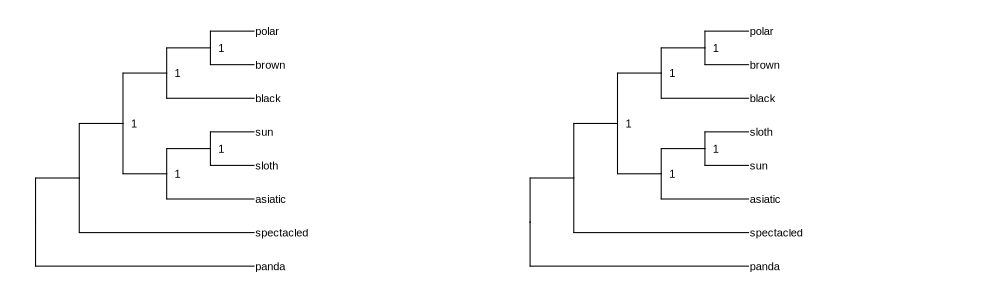

In [23]:
%%R -w 1000 -h 300
library(ggtree)
library(patchwork)
auto = read.tree('treemaxxing/50kb_auto')
chrX = read.tree('treemaxxing/50kb_chrX')

a = 
    ggtree(auto) +
    geom_tiplab() +
    geom_nodelab(aes(x = x + 0.25)) +
    xlim(c(0,10))


b = 
    ggtree(chrX) +
    geom_tiplab() +
    geom_nodelab(aes(x = x + 0.25)) +
    xlim(c(0,10))


print(a | b)
ggsave('rawfigs/chrX_auto_trees.pdf',width = 6, height = 6)

Let's grab the mitochondrial tree. The mitochondrial genomes were provided by Merly (off-screen) or downloaded on NCBI. 

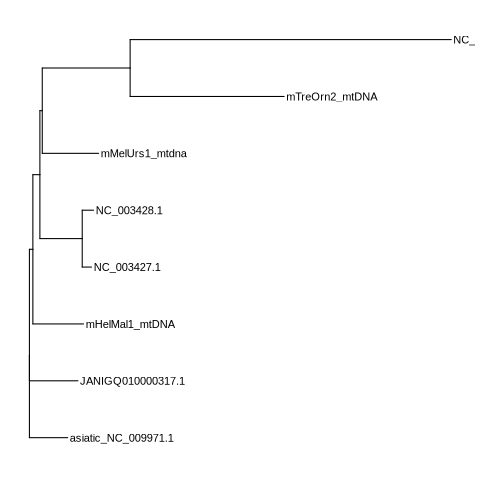

In [764]:
%%R
mito = read.tree('mito/all.mito.aligned.fasta.treefile')
ggtree(mito) +
    geom_tiplab()

# Divergence Dating

Constraints from the literature:

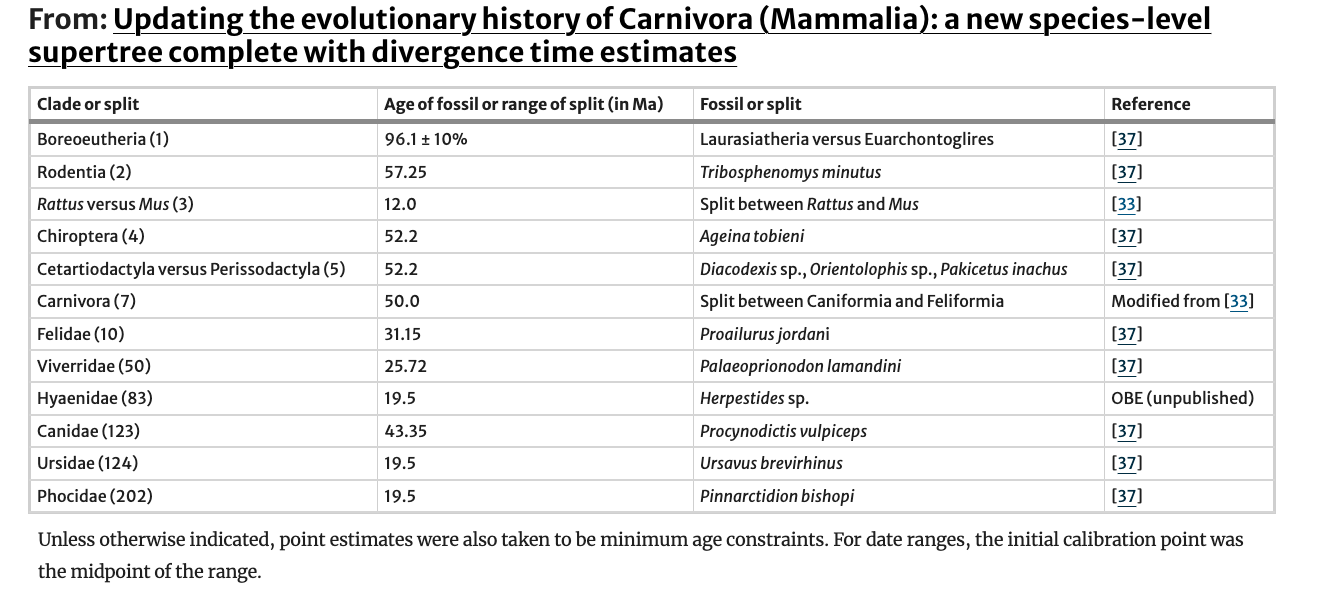<br>
https://link.springer.com/article/10.1186/1741-7007-10-12

The above represents the Bininda-Edmonds 2007 paper (linked below) which uses:<br> McKenna, M. C. & Bell, S. K. Classification of Mammals Above the Species Level (Columbia Univ. Press, New York, 1997) to calibrate the ursidae ancestor with Usrsavus brevhirinus<br>
https://www.nature.com/articles/nature05634#Bib1

Panda consensus no earlier than ~12 Ma: 
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0048985

PNAS paper uses a deeper node to infer 19.5 Ma Panda-Polar split:<br>
https://www.pnas.org/doi/epdf/10.1073/pnas.1613870114

From Heath et al. 2014

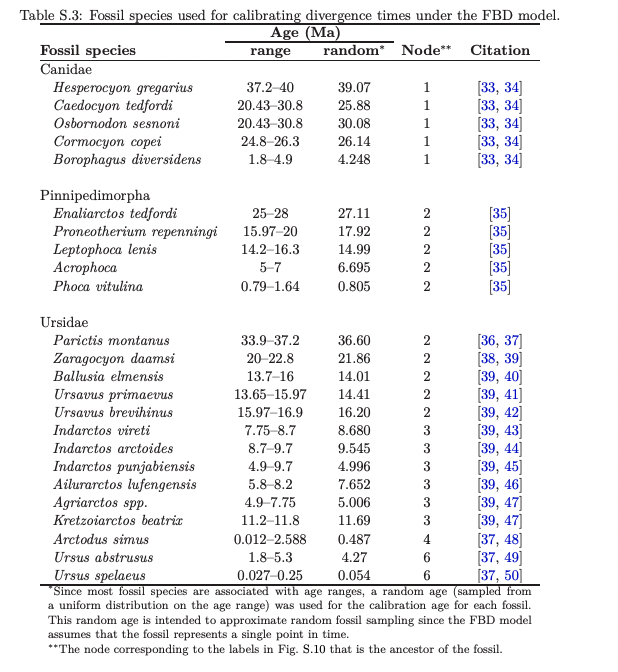

## Clock-like genes

For MCMCTree and BPP, I want to use short, unlinked, noncoding regions that evolve at roughly equal rates at all branches. I can take the conserved region list identified earlier to do this.

In [24]:
from jinja2 import Template
from pathlib import Path

# Create dirs
Path("clock/input").mkdir(parents=True, exist_ok=True)
Path("clock/cmds").mkdir(parents=True, exist_ok=True)
Path("cmds").mkdir(exist_ok=True)


# Load template
# In this template are a series of scripts to 
#   1) extract maf with hal2maf, 
#   2) convert to fasta, remove ancestral sequences,
#   3) Insert into template xml file, and use sed to rejigger the xml to match the new data
#   4) Run beast
#   5) Analyze the log output to look at ESS and values for things like rate.coefficientOfVariation
template_text = Path("templates/convert_gene.sh").read_text()
template = Template(template_text)



# Parse BED of nonocoding conserved regions, retain those greater than 1000bp. None of them are more than 5000 bp. 
genes = []
with open('treemaxxing/ortho_noncoding_conserved.bed') as infile:
    for line in infile:
        chrom, start, end, length = line.strip().split('\t')
        if int(length) >= 1000:
            start_adj = int(start) + 1
            genes.append((chrom, start_adj, end, length))



# Write per-gene scripts & parallel list
with open("cmds/convert_2_clock.txt", 'w') as parfile:
    for chrom, start, end, length in genes:
        gene = f"{chrom}_{start}_{end}"
        script_path = Path(f"clock/cmds/{gene}.convert.sh")
        filled = template.render(
            GENE=gene,
            CHROM=chrom,
            START=start,
            END=end,
            LENGTH=length
        )
        script_path.write_text(filled)
        script_path.chmod(0o755)
        parfile.write(f"bash {script_path}\n")

slurm = make_slurm(run = False, id = "clock", 
                   cmd_string = "cat cmds/convert_2_clock.txt | parallel --progress --jobs 128", 
                   c = 128, time = '48:00:00', p = 'long', mem = '40000')



KeyboardInterrupt



Analyze clock output

In [39]:
import pandas as pd
import concurrent.futures
from tqdm import tqdm

# Read the input file
with open('treemaxxing/ortho_noncoding_conserved.bed', 'r') as infile:
    lines = [line.strip() for line in infile]
    lines = [x for x in lines if int(x.split()[3]) > 1000]

def process_line(line):
    """Process a single line and return a DataFrame if the file exists."""
    CHROM, START, END, length = line.split('\t')
    START = int(START) + 1
    GENE = f"{CHROM}_{START}_{END}"
    FILE = f"clock/output/{GENE}_summary.txt"
    
    try:
        df = pd.read_csv(FILE, sep='\\s+')
        df['source'] = GENE
        return df
    except Exception:
        return None

# Use multiprocessing to process files in parallel
dflist = []
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(process_line, lines), total=len(lines)))

# Filter out None values and concatenate results
logresults = pd.concat([df for df in results if df is not None])

# Save the final dataframe
logresults.to_csv("clock/processed_results.csv", index=False)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19877/19877 [00:21<00:00, 907.70it/s]


Plot posterior ESS - a lot of genes went alright

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


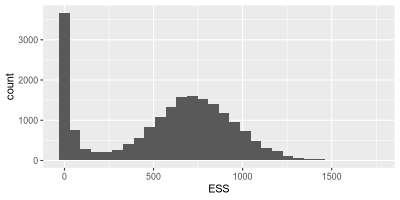

In [40]:
%%R -w 400 -h 200
logresults = fread('clock/processed_results.csv')
ggplot(logresults %>% filter(item == 'posterior')) +
    geom_histogram(aes(x = ESS))

Now, I filter for clocklike loci:

In [43]:
%%R
ESS_stable = 
    logresults %>%
    group_by(source) %>%
    filter((item == 'posterior' & ESS >=200) | (item == 'rate.coefficientOfVariation' & ESS >=200)) %>%
    summarize(count = n()) %>%
    filter(count == 2) %>%
    ungroup() %>%
    pull(source)

clocklike = 
    logresults %>%
    filter(source %in% ESS_stable) %>% 
    group_by(source) %>%
    filter(item == 'rate.coefficientOfVariation') %>% 
    filter(mean <= 0.50,`95%HPDlo` <= 0.10, `95%HPDup` < 1) 
fwrite(clocklike %>% dplyr::select(source), 'clock/clocklike_short.txt', col.names = F)

## Topology-supporting genes

Below I construct gene trees for each of the clock-like regions, and determine which ones support the species tree topology. This is for comparison down-the-line with MCMCTree/BPP to see how much locus selection matters.<br>

If I was smart I would have output the final tree in the BEAST clock analyses above, but I didn't. So it goes

In [196]:
!mkdir -p treemaxxing/trees

clockgenes = []
with open('clock/clocklike_short.txt','r') as infile:
    for line in infile:
        line = line.strip()
        clockgenes.append(line)
infile.close()

treecmdfile = open('cmds/quicktrees.txt','w')
for GENE in tqdm(clockgenes):
    if os.path.exists(f"treemaxxing/trees/{GENE}.treefile"): continue
    cmd = ('''if [[ ! -e treemaxxing/trees/{GENE}.treefile ]];then '''
           '''sed -i "s/\\*/N/g" treemaxxing/input/temp/{GENE}.fa;'''
           '''iqtree2 -redo -m GTR+I+G -s treemaxxing/input/temp/{GENE}.fa '''
           '''--prefix treemaxxing/trees/{GENE} -T 2 --bnni -B 1000;'''
           '''fi\n''').format(GENE = GENE)
    treecmdfile.write(cmd)
treecmdfile.close()
execcmd = 'cat cmds/quicktrees.txt | parallel --progress --jobs 64'
slurm = make_slurm(echo = False, id = 'quicktrees',cmd_string = execcmd, c = '64',mem = '20000', time = '12:00:00', p = 'long')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13239/13239 [00:05<00:00, 2358.70it/s]


Check results - this takes longer than it should

In [17]:
%%R
library(ape)

#-----------------
#   SPECIES TREE
#-----------------
tr = read.tree('trees/custom_BL.treefile')
tr = drop.tip(tr,c('cat','dog','seal'))
x = treeio::root(tr, outgroup = 'panda', resolve.root = TRUE)
species_tree = phytools::midpoint.root(x)

#-----------------
#   GENE TREES
#-----------------
clockgenes = fread('clock/clocklike_short.txt', header = FALSE) %>% set_colnames(c('gene'))
clockgenes %<>% mutate(speciestreetopology = FALSE)
for (IDX in seq(1,nrow(clockgenes))){
    gene = clockgenes[IDX,'gene']
    tree = paste0('treemaxxing/trees/',gene,'.treefile')
    tryCatch({
        tr <- read.tree(tree)  # attempt to read the tree
        x <- treeio::root(tr, outgroup = 'panda', resolve.root = TRUE)
        gene_tree <- phytools::midpoint.root(x)
        if (isTRUE(all.equal.phylo(species_tree, gene_tree, use.edge.length = FALSE))) {
            clockgenes[IDX, 'speciestreetopology'] <- TRUE
        }
    },
    error = function(e) {
        # If file doesn't exist or any error occurs, leave speciestreetopology as FALSE
        #message(sprintf("Skipping %s: %s", tree, e$message))
  })
}

#-----------------
#   SUMMARY
#-----------------
clockgenes %>%
    filter(speciestreetopology == TRUE) %>%
    dplyr::select(gene) %>%
    fwrite(.,'clock/supporting_clock_genes.txt',col.names=F)

R[write to console]: 
Attaching package: ‘ape’


R[write to console]: The following object is masked from ‘package:ggtree’:

    rotate


R[write to console]: The following object is masked from ‘package:dplyr’:

    where




                                 gene speciestreetopology
                               <char>              <lgcl>
  1:      NC_079873.1_9553499_9554705                TRUE
  2:    NC_079873.1_16490541_16491736                TRUE
  3:    NC_079873.1_20642138_20643244                TRUE
  4:    NC_079873.1_21579733_21581348                TRUE
  5:    NC_079873.1_21927092_21928774                TRUE
 ---                                                     
422: NW_026623111.1_30448900_30450347                TRUE
423: NW_026623111.1_41664213_41665605                TRUE
424: NW_026623111.1_44729580_44730850                TRUE
425: NW_026623111.1_46679378_46680614                TRUE
426: NW_026623111.1_56608261_56609808                TRUE


Check a few examples to make sure things are working right

[1] FALSE


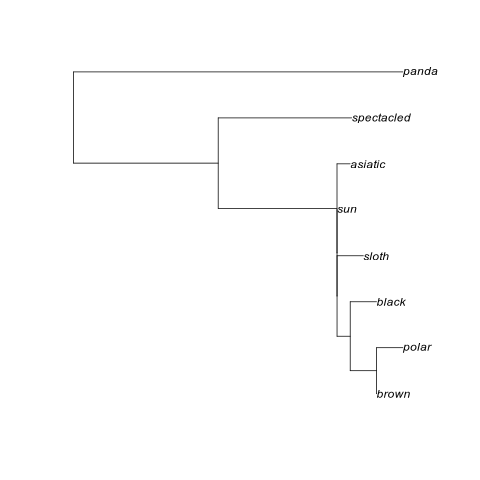

In [204]:
%%R
library(ggtree)
tr = read.tree('treemaxxing/trees/NW_026623019.1_14424313_14425666.treefile')
x = treeio::root(tr, outgroup = 'panda', resolve.root = TRUE)
gene_tree = phytools::midpoint.root(x)
plot(gene_tree)
class(gene_tree)
#tr$edge.length = NULL

library(ape)
all.equal.phylo(species_tree, gene_tree, use.edge.length = FALSE)

Alright, I feel good about the set of clock genes and which ones support the species tree.

## MCMCTree

Now the fun part! Running MCMCTree with the short noncoding clocklike regions, either in total or just on ones that support the species tree.

Setup node prior

       location scale shape df
node_1       12    10    50 10


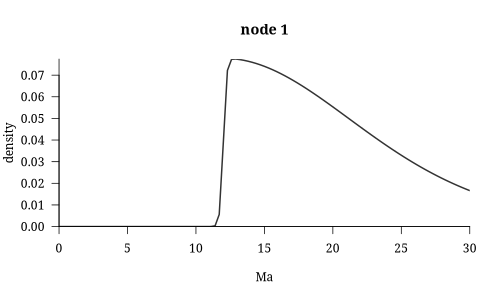

In [26]:
%%R -w 500 -h 300
library(MCMCtreeR)

## Setup tree
tree = read.tree('cladogram.nwk')

## Setup monophyletic groups
monophyleticGroups = list(tree$tip.label)

## Setup minimum bounds
minimumTimes = c(nodeOne = 12.0)
### Setup maximum bounds
maximumTimes = c(nodeOne = 30.0)


## Setup distributions
skewT_results <- estimateSkewT(minAge = minimumTimes, maxAge = maximumTimes, monoGroups = monophyleticGroups, phy = tree, 
                               plot = FALSE,  writeMCMCtree =TRUE,
                               estimateScale = FALSE, scale = 10, df = 10)
print(skewT_results$parameters)
par(mfrow = c(1,1), family = "Palatino")
for (i in 1:1) plotMCMCtree(skewT_results$parameters[i, ], method = "skewT", 
    title = paste0("node ", i), upperTime = maximumTimes[i])


## Setup distributions
gamma_results <- estimateGamma(minAge = minimumTimes, maxAge = maximumTimes, 
    monoGroups = monophyleticGroups, estimateAlpha = TRUE, offset = 7.5, beta = 0.5, phy = tree, plot = FALSE,  writeMCMCtree =TRUE)
#print(gamma_results$parameters)
#par(mfrow = c(1,1), family = "Palatino")
#for (i in 1:1) plotMCMCtree(gamma_results$parameters[i, ], method = "gamma", 
#    title = paste0("node ", i), upperTime = maximumTimes[i])

Looks alright to me, I'll write out the cladogram with this root constraint

In [553]:
%%bash
cat << EOF > mcmctree/topology.nwk
8 1 ((((asiatic,(sloth,sun)),(black,(brown,polar))),spectacled),panda)'ST(12,10,50,10)';
EOF

Format sequence input for MCMCTree

In [29]:
from collections import defaultdict
from Bio import SeqIO
import random


def concatenate_alignments(file_list, out_fasta, out_phylip, partition_phylip=None):
    concat_dict = defaultdict(str)   # {taxon: concatenated_seq}
    bad_alignments = []
    all_taxa = set()
    valid_files = []

    # First pass: check alignments
    for file in file_list:
        records = list(SeqIO.parse(file, "fasta"))
        if not records:
            bad_alignments.append(os.path.basename(file))
            continue

        lengths = {len(r.seq) for r in records}
        if len(lengths) != 1:
            bad_alignments.append(os.path.basename(file))
            continue

        valid_files.append(file)
        all_taxa.update([r.id for r in records])

    # Order taxa consistently
    all_taxa = sorted(all_taxa)

    # Second pass: build concatenated sequences + (optional) partitioned PHYLIP
    if partition_phylip:
        part_out = open(partition_phylip, "w")

    for file in valid_files:
        records = list(SeqIO.parse(file, "fasta"))
        aln_len = len(records[0].seq)

        # seqs in this file
        seqs = {r.id: str(r.seq).replace("*", "N") for r in records}

        # Add to supermatrix
        for taxon in all_taxa:
            if taxon in seqs:
                concat_dict[taxon] += seqs[taxon]
            else:
                concat_dict[taxon] += "N" * aln_len

        # Write to partitioned PHYLIP (if requested)
        if partition_phylip:
            part_out.write(f"{len(all_taxa)} {aln_len}\n")
            for taxon in all_taxa:
                seq = seqs.get(taxon, "N" * aln_len)
                bpp_id = f"{taxon}^{taxon}"
                part_out.write(f"{bpp_id}   {seq}\n")

    if partition_phylip:
        part_out.close()

    # Write concatenated fasta
    with open(out_fasta, "w") as fasta_out:
        for taxon, seq in concat_dict.items():
            fasta_out.write(f">{taxon}\n{seq}\n")

    # Write concatenated phylip
    taxa = list(concat_dict.keys())
    if taxa:
        seq_length = len(next(iter(concat_dict.values())))
        with open(out_phylip, "w") as phy_out:
            phy_out.write(f"{len(taxa)} {seq_length}\n")
            for taxon in taxa:
                phy_out.write(f"{taxon}   {concat_dict[taxon]}\n")

    return bad_alignments


### Concatenate all genes
sp = []
with open('clock/clocklike_short.txt','r') as infile:
    for line in infile:
        line = line.strip()
        sp.append(line)
infile.close()
sp_files = [f"treemaxxing/input/temp/{GENE}.fa" for GENE in sp]
bad_subset = concatenate_alignments(
    sp_files,
    "mcmctree/shortgenes_all.fasta",
    "mcmctree/shortgenes_all.phy",
    "mcmctree/shortgenes_all_partitioned.phy"
)

### Concatenate a random subset of all genes (for BPP)
sp = []
with open('clock/clocklike_short.txt','r') as infile:
    for line in infile:
        line = line.strip()
        sp.append(line)
infile.close()
sp_files = [f"treemaxxing/input/temp/{GENE}.fa" for GENE in sp]
sp_files = random.sample(sp_files, 200)
bad_subset = concatenate_alignments(
    sp_files,
    "mcmctree/shortgenes_subset.fasta",
    "mcmctree/shortgenes_subset.phy",
    "mcmctree/shortgenes_subset_partitioned.phy"
)


### Concatenate supporting genes. There are only 426 of these anyway
sp = []
with open('clock/supporting_clock_genes.txt','r') as infile:
    for line in infile:
        line = line.strip()
        sp.append(line)
infile.close()
sp_files = [f"treemaxxing/input/temp/{GENE}.fa" for GENE in sp]
bad_subset = concatenate_alignments(
    sp_files,
    "mcmctree/shortgenes_supporting.fasta",
    "mcmctree/shortgenes_supporting.phy",
    "mcmctree/shortgenes_supporting_partitioned.phy"
)


Step 1 of MCMCTree: Calculate Gradient and Hessian. Need to configure for whatever gene susbset you're using.

In [58]:
%%bash
cat << EOF > /private/groups/shapirolab/brock/bears/mcmctree/all_mcmctree_BV.ctl
  seqfile = /private/groups/shapirolab/brock/bears/mcmctree/shortgenes_all.phy
 treefile = /private/groups/shapirolab/brock/bears/mcmctree/topology.nwk
  outfile = /private/groups/shapirolab/brock/bears/mcmctree/shortgenes_main
  
    ndata = 1
  seqtype = 0    * 0: nucleotides; 1:codons; 2:AAs
  usedata = 3    * 0: no data (prior); 1:exact likelihood; 
                 * 2: approximate likelihood; 3:out.BV (in.BV)
    clock = 2    * 1: global clock; 2: independent rates; 3: correlated rates

    model = 4    * 0:JC69, 1:K80, 2:F81, 3:F84, 4:HKY85
    alpha = 0.5   * alpha for gamma rates at sites
    ncatG = 5    * No. categories in discrete gamma

cleandata = 0    * remove sites with ambiguity data (1:yes, 0:no)?
EOF

mkdir -p mcmctree mcmctree/gH
cd mcmctree/gH
export PATH="/private/groups/shapirolab/brock/Software/paml/:$PATH"
mcmctree /private/groups/shapirolab/brock/bears/mcmctree/all_mcmctree_BV.ctl
cp out.BV ../in.BV

MCMCTREE in paml version 4.10.6, November 2022

Reading options from /private/groups/shapirolab/brock/bears/mcmctree/all_mcmctree_BV.ctl..
burnin=0: no automatic step adjustment?

Reading main tree.
((((asiatic, (sloth, sun)), (black, (brown, polar))), spectacled), panda);

Reading sequence data..  1 loci


*** Locus 1 ***
ns = 8  	ls = 17795958
Reading sequences, sequential format..
Reading seq # 8: polar            
Sequences read..
Counting site patterns..  0:02
Compressing,   6008 patterns at 17795958 / 17795958 sites (100.0%),  0:05000 / 17795958 sites (54.1%),  0:04
ns = 8  	ls = 6008
Reading sequences, sequential format..
Reading seq # 8: polar            
Sequences read..

6008 site patterns read, 17795958 sites
Counting frequencies..

      336 bytes for distance 
  1345792 bytes for conP
   240320 bytes for fhK
  8000000 bytes for space

TREE #  1: (((7, (2, 3)), (6, (4, 8))), 1, 5); MP score: -1.00

ns = 8  nnode = 14
   dad  node   nson:   sons
     8     0      0: 
    11 

Control file for the actual inference!

In [26]:
%%bash
### CHANGE ACCORDINGLY ###
##########################
#for SET in "all" "subset";do
for SET in "supporting";do
cat << EOF > mcmctree/${SET}_main.ctl
    seed = -1
    seqfile = /private/groups/shapirolab/brock/bears/mcmctree/shortgenes_${SET}.phy
    treefile = /private/groups/shapirolab/brock/bears/mcmctree/topology.nwk
    mcmcfile = /private/groups/shapirolab/brock/bears/mcmctree/shortgenes_${SET}_mcmc
    outfile = /private/groups/shapirolab/brock/bears/mcmctree/shortgenes_${SET}_results
    

       ndata = 1
     seqtype = 0    * 0: nucleotides; 1:codons; 2:AAs
     usedata = 2    * 0: no data (prior); 1:exact likelihood;
                    * 2:approximate likelihood; 3:out.BV (in.BV)
       clock = 2    * 1: global clock; 2: independent rates; 3: correlated rates
     #RootAge = '>60.0<100.0'  * safe constraint on root age, used if no fossil for root. # IMPORTANT TO MAKE SURE THIS IS SCALED CORRECTLY
       
       model = 4    * 0:JC69, 1:K80, 2:F81, 3:F84, 4:HKY85
       alpha = 0.5  * alpha for gamma rates at sites
       ncatG = 5    * No. categories in discrete gamma

   cleandata = 0    * remove sites with ambiguity data (1:yes, 0:no)?

     BDparas = 0.01 0.01 0.1   * birth, death, sampling
 kappa_gamma = 6 2     * gamma prior for kappa
 alpha_gamma = 1 1     * gamma prior for alpha

 rgene_gamma = 2 2000 1   * gammaDir prior for rate for genes # Need to run baseml to change this 
sigma2_gamma = 1 1000 1   * gammaDir prior for sigma^2     (for clock=2 or 3)

       print = 1   * 0: no mcmc sample; 1: everything except branch rates 2: everything
      burnin = 20000
    sampfreq = 100
     nsample = 1000000
EOF
done

Run (do in screen). Do this twice and make sure the independent runs converge

In [266]:
%%bash
cd mcmctree
export PATH="/private/groups/shapirolab/brock/Software/paml/:$PATH"
mcmctree /private/groups/shapirolab/brock/bears/mcmctree/subset_main.ctl

Compare runs. Below, I do so for the 'shortgenes_all' set

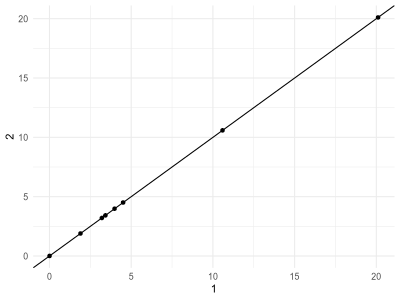

In [188]:
%%R -w 400 -h 300
run1 = fread('tail -n 10 mcmctree/shortgenes_all_results_v1', header = F) %>%
    mutate(val = gsub(" \\(.*","",V1) %>% gsub("^.* ","",.) %>% as.numeric) %>%
    mutate(param = gsub(" .*","",V1)) %>%
    mutate(run = '1')
run2 = fread('tail -n 10 mcmctree/shortgenes_all_results_v1', header = F) %>%
    mutate(val = gsub(" \\(.*","",V1) %>% gsub("^.* ","",.) %>% as.numeric) %>%
    mutate(param = gsub(" .*","",V1)) %>%
    mutate(run = '2')
comp = 
    bind_rows(run1 %>% dplyr::select(run,val,param),run2 %>% dplyr::select(run,val,param)) %>%
    pivot_wider(names_from = run, values_from = val)
ggplot(comp %>% filter(!param %in% c('mu','sigma','lnL'))) +
    geom_point(aes(x = `1`,y=`2`)) +
    geom_abline(aes(slope = 1, intercept = 0)) +
    theme_minimal()

Looks great!

### Supp figure
The MCMCTree result is not the main result, but I do include it as the supplementary figure and discuss it a little bit

  node_id     min      max      y   barmin   barmax
1      13 1.78971  5.23663 4.5000  1.78971  5.23663
2      12 2.23217  6.49252 3.7500  2.23217  6.49252
3      15 1.04268  3.10412 7.5000  1.04268  3.10412
4      14 1.90566  5.57355 6.7500  1.90566  5.57355
5      11 2.53147  7.33869 5.2500  2.53147  7.33869
6      10  5.9417  17.2746 3.6250  5.94170 17.27460
7       9 11.7702  32.4322 2.3125 11.77020 32.43220


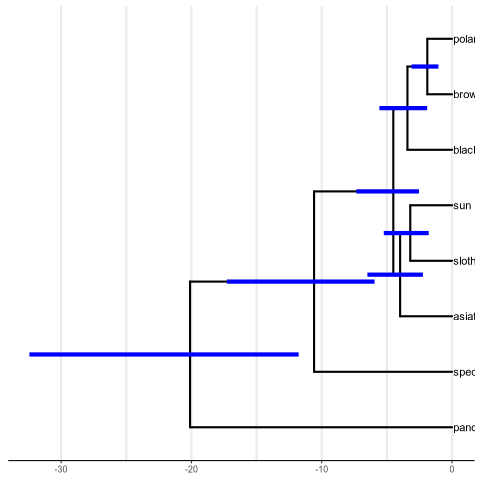

In [160]:
%%R
cur = treeio::read.mcmctree('mcmctree/shortgenes_FigTree_v1.tre')

## Some finagling to geom_segment to reliably plot HPD
minmax = t(matrix(unlist(cur@data$`0.95HPD`),nrow=2))
bar_df = data.frame(node_id=as.integer(cur@data$node),as.data.frame(minmax))
names(bar_df) = c('node_id','min','max') 
bar_df = bar_df %>% filter(node_id > Ntip(cur@phylo))

b = ggtree(cur, size = 1)
bar_df = 
    bar_df %>% 
    left_join(b$data, by=c('node_id'='node')) %>% 
    select(node_id,min,max,y) %>%
    mutate(barmin = as.numeric(min),barmax = as.numeric(max))
print(bar_df)


revts(b)+
    geom_tiplab() +
    geom_segment(aes(x=-barmax, y=y, xend=-barmin, yend=y), data=bar_df, color='blue', size = 2) +
    theme_tree2() +
    theme(panel.grid.major.x = element_line(size = 1), panel.grid.minor.x = element_line(size = 1))

#ggsave('rawfigs/mcmctree.pdf',width=4,height = 6)

## BPP

Setup configs for BPP

In [21]:
%%bash
cp mcmctree/shortgenes_subset_partitioned.phy BPP/shortgenes_subset_partitioned.phy
cp mcmctree/shortgenes_supporting_partitioned.phy BPP/shortgenes_supporting_partitioned.phy

cat << EOF > BPP/species.imap
panda panda
spectacled spectacled
sun sun
sloth sloth
asiatic asiatic
black black
brown brown
polar polar
EOF

cat << EOF > BPP/main.ctl
    seed =  -1
    
    seqfile = BPP/shortgenes_supporting_partitioned.phy
    Imapfile = BPP/species.imap
    outfile = BPP/supporting_out_n200.txt
    mcmcfile = BPP/supporting_mcmc_n200.txt
    
    # fixed number of species/populations 
    speciesdelimitation = 0
    
    # fixed species tree
    speciestree = 0
    
    species&tree = 8 asiatic sloth sun black brown polar spectacled panda
                      1 1 1 1 1 1 1 1
                     ((((asiatic,(sloth,sun)),(black,(brown,polar))),spectacled),panda);
    
    # unphased data for all 8 species
    phase =   1 1 1 1 1 1 1 1
    
    # use sequence likelihood
    usedata = 1

    # Take the first X genes even though the partition has more
    nloci = 200
    
    # do not remove sites with ambiguity data
    cleandata = 0

    thetamodel = linked-all
    # For both priors I'm assuming α = 3 to keep things diffuse
    # 1 bp difference per 1kb, alright for bears?
    thetaprior = 3 0.001 # gamma(a, b) for theta (estimate theta)
    # Assuming ~20 Ma root and 1x10^-9 substitution
    # β = (α − 1) × τ_mean where τ_mean = (1×10−9 * 20,000,000) = 0.04
    tauprior = 3 0.04


    locusrate = 1 0 0 5 iid
    clock = 1

    # Step proposals
    finetune = 1: .01 .02 .003 .004 .05 .01 .01 # auto (0 or 1): MCMC step lengths
    
    # MCMC samples, locusrate, heredityscalars, Genetrees
    print = 1 0 0 0   * 
    burnin = 16000
    sampfreq = 10
    nsample = 100000
EOF

Run BPP. Again, we do this twice and compare runs

In [28]:
cmd = "/private/groups/shapirolab/brock/Software/bpp-4.7.0-linux-x86_64/bin/bpp --cfile BPP/main.ctl"
slurm = make_slurm(run = False,
                   id = f"BPP_n200", cmd_string = cmd, mem = '30000',time='300:00:00', p = 'long')

Compare runs

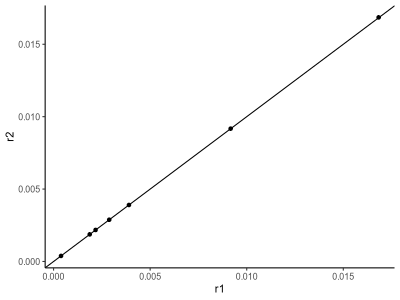

In [73]:
%%R -w 400 -h 300
r1 = 
    fread(cmd = "grep -A12 'tau_9' BPP/supporting_out_n200_v1.txt | sed 's/(//g;s/)//g;s/ \\+/ \t/g;s/,//g'", header = T) %>%
    dplyr::rename("Stat" = "V1") %>%
    pivot_longer(-Stat) %>%
    mutate(run = 'r1')
r2 = 
    fread(cmd = "grep -A12 'tau_9' BPP/supporting_out_n200_v2.txt | sed 's/(//g;s/)//g;s/ \\+/ \t/g;s/,//g'", header = T) %>%
    dplyr::rename("Stat" = "V1") %>%
    pivot_longer(-Stat) %>%
    mutate(run = 'r2')
rs = bind_rows(r1,r2)
rs %<>% 
    pivot_wider(names_from = run, values_from = value)
ggplot(rs %>% filter(grepl('tau_',name),Stat == 'mean')) +
    geom_point(aes(x = r1, y = r2)) +
    geom_abline(aes(intercept = 0, slope = 1)) +
    theme_classic()

Check node calibration again

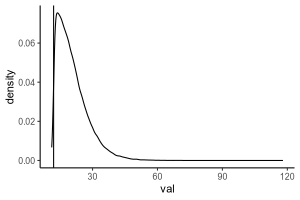

In [71]:
%%R -w 300 -h 200
library(sn)
rst(n=1, xi=c(12), omega=c(10), alpha=c(50), nu=1, dp=NULL)
t = data.frame(val = rst(100000, xi=c(12), omega=c(10), alpha=c(50), nu=c(10), dp=NULL))
ggplot(t) +
    geom_density(aes(x = val)) +
    #xlim(c(0,100)) +
    geom_vline(aes(xintercept = 12)) +
    theme_classic()

### Main Figure

Use elements of the R package bppr to rescale the tree in terms of real time. It is only possible to apply one fossil calibration, and here I do so using the same one applied to the root in MCMCTree.

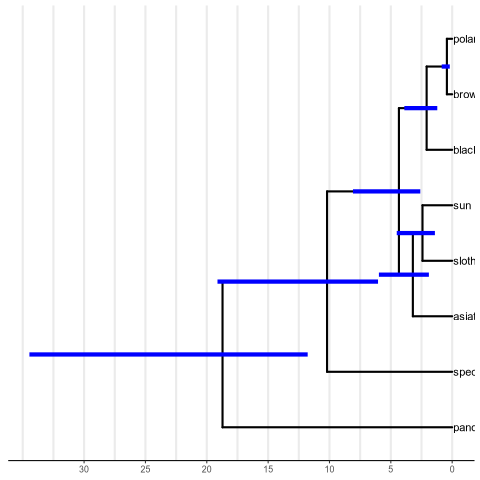

In [65]:
%%R
library(deeptime)
library(ggtree)
library(treeio)
library(sn)
rst(n=1, xi=c(12), omega=c(10), alpha=c(50), nu=1, dp=NULL)
cur = treeio::read.mcmctree('BPP/supporting_n200_v1.tre')
mcmc1 = fread('BPP/supporting_mcmc_n200_v1.txt')
mcmc = mcmc1
#mcmc2 = fread('BPP/main_mcmc_n100_v2.txt')
#mcmc = bind_rows(mcmc1,mcmc2)

## Rate calculation based on fossil calibration
time.name <- "tau_9asiaticslothsunblackbrownpolarspectacledpanda"
i <- match(time.name, names(mcmc))
n <- nrow(mcmc[,..i])  # length of the MCMC sample
ti <- grep("tau_", names(mcmc)) # find the unscaled times (tau's) in data frame
tr <- rst(n,xi=c(12), omega=c(10), alpha=c(50), nu=10, dp=NULL) # obtain randomly sampled times from calibration
allrates <- mcmc[,..i] / tr  # calculate substitution rate
rate = mean(allrates %>% pull(1), na.rm = T)

## Rescaling
cur@data$reltime = cur@data$reltime/(rate)
cur@phylo$edge.length = cur@phylo$edge.length/(rate)
node = "9asiaticslothsunblackbrownpolarspectacledpanda"
bear.time.t = bppr::msc2time.t(mcmc, node.name = node, calf = rst, xi=c(12), omega=c(10), alpha=c(50), nu=c(10))
hpd = 
    data.frame(coda::HPDinterval(coda::as.mcmc(bear.time.t))) %>% 
    rownames_to_column(var = 'param') %>%
    mutate(param = gsub("([0-9]{1,2}).*", "\\1",param))
newbounds = 
    lapply(cur@data$node, function(I){
    node = paste0("t_",as.character(I))
    bounds = hpd %>% filter(param == node)
    return(c(bounds$lower,bounds$upper))
})
cur@data$height_0.95_HPD = newbounds

## Plotting

## Some finagling to geom_segment to reliably plot HPD
timevec = c(-30, -25, -20, -15, -10, -5, 0, 5)
labelled_timevec = sapply(timevec,function(x){as.character(-1*x)})
minmax = t(matrix(unlist(cur@data$height_0.95_HPD),nrow=2))
bar_df = data.frame(node_id=as.integer(cur@data$node),as.data.frame(minmax))
names(bar_df) = c('node_id','min','max') 
bar_df = bar_df %>% filter(node_id > Ntip(cur@phylo))

b = ggtree(cur, size = 1)
bar_df = bar_df %>% left_join(b$data, by=c('node_id'='node')) %>% select(node_id,min,max,y)

## Generate plot
p = 
    revts(b) + 
    geom_segment(aes(x=-min, y=y, xend=-max, yend=y), data=bar_df, color='blue', size = 2) +
    geom_tiplab() +
    theme_tree2() +
    theme(panel.grid.major.x = element_line(size = 1), panel.grid.minor.x = element_line(size = 1)) +
    scale_x_continuous(breaks = timevec, labels = labelled_timevec)
    coord_geo(neg = TRUE, xlim = c(-35,10), ylim = c(-1, Ntip(cur) + 1),
              pos = as.list(rep("bottom", 2)),
              dat = list('epochs','periods'), 
              height = list(unit(1, "lines"), unit(1, "lines")), center_end_labels = TRUE)


print(p)
#ggsave('rawfigs/BPP_tree.pdf',width = 4, height = 6)

## Supp figure times comparison

In this figure, I compare the time estimates based on 
1) Genes that support the species tree vs all genes
2) Coalescent (BPP) vs. standard analysis (MCMCTree)

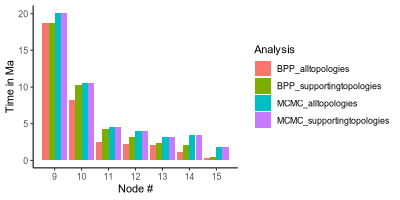

In [61]:
%%R -w 400 -h 200
library(sn)


#------------------------------------------
# MCMCTREE 'ALL' LOCI
#------------------------------------------
cur = treeio::read.mcmctree('mcmctree/shortgenes_FigTree_v1.tre')
MCMC_alltopologies = cur@data %>% dplyr::select(node, reltime) %>% mutate(analysis = 'MCMC_alltopologies')


#------------------------------------------
# MCMCTREE 'ONLY' LOCI THAT SUPPORT SPECIES TREE
#------------------------------------------
cur = treeio::read.mcmctree('mcmctree/supporting_FigTree_v1.tre')
MCMC_supportingtopologies = cur@data %>% dplyr::select(node, reltime) %>% mutate(analysis = 'MCMC_supportingtopologies')



#------------------------------------------
# BPP 'ALL' LOCI 
#------------------------------------------
rst(n=1, xi=c(12), omega=c(10), alpha=c(50), nu=1, dp=NULL)
cur = treeio::read.mcmctree('BPP/shortgenes_n200.tre')
mcmc = fread('BPP/shortgenes_mcmc_n200.txt')

## Rate calculation based on fossil calibration
time.name <- "tau_9asiaticslothsunblackbrownpolarspectacledpanda"
i <- match(time.name, names(mcmc))
n <- nrow(mcmc[,..i])  # length of the MCMC sample
ti <- grep("tau_", names(mcmc)) # find the unscaled times (tau's) in data frame
tr <- rst(n,xi=c(12), omega=c(10), alpha=c(50), nu=10, dp=NULL) # obtain randomly sampled times from calibration
allrates <- mcmc[,..i] / tr  # calculate substitution rate
rate = mean(allrates %>% pull(1), na.rm = T)

## Rescaling
cur@data$reltime = cur@data$reltime/(rate)
cur@phylo$edge.length = cur@phylo$edge.length/(rate)
node = "9asiaticslothsunblackbrownpolarspectacledpanda"
bear.time.t = bppr::msc2time.t(mcmc, node.name = node, calf = rst, xi=c(12), omega=c(10), alpha=c(50), nu=c(10))
hpd = 
    data.frame(coda::HPDinterval(coda::as.mcmc(bear.time.t))) %>% 
    rownames_to_column(var = 'param') %>%
    mutate(param = gsub("([0-9]{1,2}).*", "\\1",param))
newbounds = 
    lapply(cur@data$node, function(I){
    node = paste0("t_",as.character(I))
    bounds = hpd %>% filter(param == node)
    return(c(bounds$lower,bounds$upper))
})
cur@data$height_0.95_HPD = newbounds
BPP_alltopologies = cur@data %>% dplyr::select(node, reltime) %>% mutate(analysis = 'BPP_alltopologies')


#------------------------------------------
# BPP 'ONLY' LOCI THAT SUPPORT SPECIES TREE
#------------------------------------------
rst(n=1, xi=c(12), omega=c(10), alpha=c(50), nu=1, dp=NULL)
cur = treeio::read.mcmctree('BPP/supporting_n200_v1.tre')
mcmc = fread('BPP/supporting_mcmc_n200_v1.txt')

## Rate calculation based on fossil calibration
time.name <- "tau_9asiaticslothsunblackbrownpolarspectacledpanda"
i <- match(time.name, names(mcmc))
n <- nrow(mcmc[,..i])  # length of the MCMC sample
ti <- grep("tau_", names(mcmc)) # find the unscaled times (tau's) in data frame
tr <- rst(n,xi=c(12), omega=c(10), alpha=c(50), nu=10, dp=NULL) # obtain randomly sampled times from calibration
allrates <- mcmc[,..i] / tr  # calculate substitution rate
rate = mean(allrates %>% pull(1), na.rm = T)

## Rescaling
cur@data$reltime = cur@data$reltime/(rate)
cur@phylo$edge.length = cur@phylo$edge.length/(rate)
node = "9asiaticslothsunblackbrownpolarspectacledpanda"
bear.time.t = bppr::msc2time.t(mcmc, node.name = node, calf = rst, xi=c(12), omega=c(10), alpha=c(50), nu=c(10))
hpd = 
    data.frame(coda::HPDinterval(coda::as.mcmc(bear.time.t))) %>% 
    rownames_to_column(var = 'param') %>%
    mutate(param = gsub("([0-9]{1,2}).*", "\\1",param))
newbounds = 
    lapply(cur@data$node, function(I){
    node = paste0("t_",as.character(I))
    bounds = hpd %>% filter(param == node)
    return(c(bounds$lower,bounds$upper))
})
cur@data$height_0.95_HPD = newbounds
BPP_supportingtopologies = cur@data %>% dplyr::select(node, reltime) %>% mutate(analysis = 'BPP_supportingtopologies')



#------------------------------------------
# PLOT
#------------------------------------------

treetimes = bind_rows(MCMC_alltopologies, MCMC_supportingtopologies, BPP_alltopologies, BPP_supportingtopologies)
p = ggplot(treetimes) +
    geom_bar(aes(x = as.numeric(node), y= reltime, fill = analysis),stat = 'identity', position = 'dodge') +
    theme_classic() +
    scale_x_continuous(breaks = seq(9,15,1), labels = seq(9,15,1)) +
    scale_fill_discrete(name = "Analysis") +
    ylab("Time in Ma") +
    xlab("Node #")
print(p)
ggsave('rawfigs/time_comparisons.pdf',width = 5, height = 2.5)

# Networks

This section is for inferring phylogenetic networks with SNaQ!

## Gather tree files

This is using the 10kb and 50kb trees that Lexi generated

## Calculate and jackknife CFS.

This is the raw CF calculation code, also in `bootstrap_CF.R` to submit as a slurm job

In [ ]:
%%R
library(MSCquartets)
library(ggtree)
library(tidyverse)
library(data.table)
library(magrittr)
trees = read.tree('snaq/10kb_sloth.treefile')
jk = 0.75
sample_size <- floor(0.75 * length(trees))
dflist = list()

tryCF <- function(required_cols = c('asiatic','black','brown','panda','polar','sloth','spectacled','sun'),
                  max_attempts = 100, wait_seconds = 1) {
  for (attempt in 1:max_attempts) {
    message(sprintf("Attempt %d to generate cf...", attempt))
    jk_trees <- sample(trees, sample_size)
    cf <- quartetTable(jk_trees, taxonnames = NULL, epsilon = 0, random = 0, progressbar = FALSE)
    if (all(required_cols %in% colnames(cf))) {
      message("✅ Required columns found. Returning cf.")
      return(cf)
    } else {
      message("⚠️ Required columns missing. Retrying...")
      Sys.sleep(wait_seconds)
    }
  }
  stop("❌ Max attempts reached. Required columns still missing.")
}


## Original data
cf = quartetTable(trees, taxonnames = NULL, epsilon = 0, random = 0, progressbar = TRUE)
og = 
    cf %>%
    data.frame %>%
    mutate(across(c(asiatic,black,brown,panda,polar,sloth,spectacled,sun),
                  ~ifelse(. == 1,cur_column(),NA))) %>%
    fwrite(.,'snaq/temp',col.names=F,sep=",")
    cmd <- 'sed -i "s/,\\{2,\\}/,/g;s/^,//g" snaq/temp'
    system(cmd)
    og = fread('snaq/temp') %>% 
    set_colnames(c('taxon1','taxon2','taxon3','taxon4','CF12_34','CF13_24','CF14_23','CF1234')) %>%
    dplyr::select(!CF1234) %>%
    rowwise %>%
    mutate(ngenes = sum(CF12_34,CF13_24,CF14_23)) %>%
    ungroup %>%
    mutate(CF12_34 = CF12_34/ngenes, CF13_24 = CF13_24/ngenes, CF14_23 = CF14_23/ngenes) %>%
    mutate(CF12_34_lo = CF12_34, CF12_34_hi = CF12_34,
           CF13_24_lo = CF13_24, CF13_24_hi = CF13_24,
           CF14_23_lo = CF14_23, CF14_23_hi = CF14_23) %>%
    dplyr::select(c(taxon1,taxon2,taxon3,taxon4,
                  CF12_34,CF12_34_lo,CF12_34_hi,
                  CF13_24,CF13_24_lo,CF13_24_hi,
                  CF14_23,CF14_23_lo,CF14_23_hi,
                  ngenes)) %>%
    fwrite('snaq/10kb_sloth_allcf_ready.csv')


## Resampled data
for (I in seq(1,100,1)){
    print(I)
    cf = tryCF()
    cf %<>%
        data.frame %>%
        mutate(across(c(asiatic,black,brown,panda,polar,sloth,spectacled,sun),
                       ~ifelse(. == 1,cur_column(),NA)))
    fwrite(cf,'snaq/temp',col.names=F,sep=",")
    cmd <- 'sed -i "s/,\\{2,\\}/,/g;s/^,//g" snaq/temp'
    system(cmd)
    df =
        fread('snaq/temp') %>%
        set_colnames(c('taxon1','taxon2','taxon3','taxon4','CF12_34','CF13_24','CF14_23','CF1234')) %>%
        dplyr::select(!CF1234) %>%
        rowwise %>%
        mutate(ngenes = sum(CF12_34,CF13_24,CF14_23)) %>%
        ungroup %>%
        mutate(CF12_34 = CF12_34/ngenes, CF13_24 = CF13_24/ngenes, CF14_23 = CF14_23/ngenes) %>%
        dplyr::select(c(taxon1,taxon2,taxon3,taxon4, CF12_34, CF13_24, CF14_23, ngenes)) 
    dflist[[I]] = df
}
q = bind_rows(dflist)

hilo =
    q %>%
    group_by(taxon1, taxon2, taxon3, taxon4) %>%
    summarize(CF12_34_lo = quantile(CF12_34, 0.025),CF12_34_hi = quantile(CF12_34, 0.975),
              CF13_24_lo = quantile(CF13_24, 0.025),CF13_24_hi = quantile(CF13_24, 0.975),
              CF14_23_lo = quantile(CF14_23, 0.025),CF14_23_hi = quantile(CF14_23, 0.975)) %>%
    ungroup

og = fread('snaq/10kb_sloth_allcf_ready.csv', header = T, sep = ",")
left_join(og %>% dplyr::select(taxon1,taxon2,taxon3,taxon4,CF12_34,CF13_24,CF14_23,ngenes), hilo) %>%
    dplyr::select(taxon1,taxon2,taxon3,taxon4,
                  CF12_34, CF12_34_lo, CF12_34_hi,
                  CF13_24, CF13_24_lo, CF13_24_hi,
                  CF14_23, CF14_23_lo, CF14_23_hi,
                 ngenes) %>%
    fwrite('snaq/10kb_sloth_bootCF.csv',sep=",",col.names=T)

R[write to console]: Loading required package: ape

R[write to console]: 
Attaching package: ‘ape’


R[write to console]: The following object is masked from ‘package:ggtree’:

    rotate


R[write to console]: The following object is masked from ‘package:dplyr’:

    where


R[write to console]: Loading required package: phangorn

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 216194 gene trees.

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R

[1] 1


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 2


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 3


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 4


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 5


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 6


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 7


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 8


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 9


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 10


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.

R[write to console]: ✅ Required columns found. Returning cf.



[1] 11


R[write to console]: Attempt 1 to generate cf...

R[write to console]: Using taxa that appear on first gene tree.

R[write to console]: Counting occurrences of displayed quartets for 70 four-taxon subsets of 8 taxa across 162145 gene trees.



Submit with slurm

In [ ]:
for SET in ['10kb_sloth']:
    cmd = f"Rscript --vanilla snaq/bootstrap_CF_parallel.R {SET}"
    slurm = make_slurm(echo = True,
                       run = True,
                       id = f"{SET}_cfs",
                       cmd_string = cmd, 
                       mem = '20000',
                       time = '24:00:00',
                       c = '64',
                       p = 'long')

## Run

Basic SNAQ code, present in `run_snaq.jl`

Run

In [941]:
for SET in ['50kb_brown','50kb_sloth','10kb_brown']:
    cmd = f"julia snaq/run_snaq.jl {SET}"
    slurm = make_slurm(run = False,
                       id = f"{SET}_snaq",
                       cmd_string = cmd, 
                       mem = '20000',
                       time = '36:00:00',
                       c = '32',
                       p = 'long')

## Results

Network fit

In [6]:
%%bash
cd snaq
ls net*50kb*brown*out | xargs -I {} sh -c 'res=$(head -n 1 {} | sed "s/^.*Ploglik = //");echo {}\\t$res' | sed "s/net//;s/.out//" > net_50kb_brown_likelihoods.txt
cd ../

cd snaq
ls net*50kb*sloth*out | xargs -I {} sh -c 'res=$(head -n 1 {} | sed "s/^.*Ploglik = //");echo {}\\t$res' | sed "s/net//;s/.out//" > net_50kb_sloth_likelihoods.txt
cd ../

cd snaq
ls net*10kb*brown*out | xargs -I {} sh -c 'res=$(head -n 1 {} | sed "s/^.*Ploglik = //");echo {}\\t$res' | sed "s/net//;s/.out//" > net_10kb_brown_likelihoods.txt
cd ../

cd snaq
ls net*10kb*sloth*out | xargs -I {} sh -c 'res=$(head -n 1 {} | sed "s/^.*Ploglik = //");echo {}\\t$res' | sed "s/net//;s/.out//" > net_10kb_sloth_likelihoods.txt
cd ../


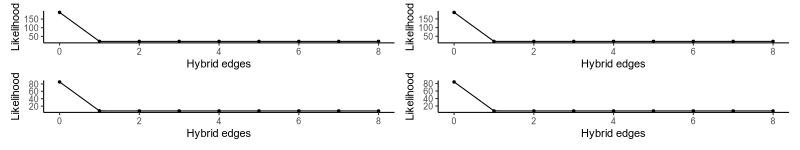

In [10]:
%%R -w 800 -h 150
library (patchwork)
fit = fread('snaq/net_50kb_brown_likelihoods.txt') %>% 
    set_colnames(c('edges', 'lhood')) %>%
    mutate(edges = gsub("_.*","",edges) %>% as.numeric)
a = 
    ggplot(fit, aes(x = edges, y = lhood)) +
    geom_point(size = 1) +
    geom_line() +
    labs(x = "Hybrid edges", y = "Likelihood") + 
    theme_classic()


fit = fread('snaq/net_50kb_sloth_likelihoods.txt') %>% 
    set_colnames(c('edges', 'lhood')) %>%
    mutate(edges = gsub("_.*","",edges) %>% as.numeric)
b = 
    ggplot(fit, aes(x = edges, y = lhood)) +
    geom_point(size = 1) +
    geom_line() +
    labs(x = "Hybrid edges", y = "Likelihood") + 
    theme_classic()


fit = fread('snaq/net_10kb_brown_likelihoods.txt') %>% 
    set_colnames(c('edges', 'lhood')) %>%
    mutate(edges = gsub("_.*","",edges) %>% as.numeric)
c = 
    ggplot(fit, aes(x = edges, y = lhood)) +
    geom_point(size = 1) +
    geom_line() +
    labs(x = "Hybrid edges", y = "Likelihood") + 
    theme_classic()

fit = fread('snaq/net_10kb_sloth_likelihoods.txt') %>% 
    set_colnames(c('edges', 'lhood')) %>%
    mutate(edges = gsub("_.*","",edges) %>% as.numeric)
d = 
    ggplot(fit, aes(x = edges, y = lhood)) +
    geom_point(size = 1) +
    geom_line() +
    labs(x = "Hybrid edges", y = "Likelihood") + 
    theme_classic()

comb = a + b + c + d
print(comb)
ggsave('rawfigs/snaq_lhood_fit.pdf',width=8,height = 4)

Single edge networks

Bootstrap support

In [8]:
%%R
fread('snaq/BSc_50kb_brown.csv') %>% print
fread('snaq/BSc_50kb_sloth.csv') %>% print
fread('snaq/BSc_10kb_brown.csv') %>% print
fread('snaq/BSc_10kb_sloth.csv') %>% print

         taxa asiatic c_minus4     H9
       <char>  <lgcl>   <lgcl> <lgcl>
1:      sloth   FALSE     TRUE  FALSE
2:        sun   FALSE     TRUE  FALSE
3:    asiatic    TRUE     TRUE  FALSE
4: spectacled   FALSE    FALSE  FALSE
5:      panda   FALSE    FALSE  FALSE
6:      black   FALSE     TRUE   TRUE
7:      brown   FALSE     TRUE   TRUE
8:      polar   FALSE     TRUE   TRUE
         taxa c_minus5     H9 asiatic
       <char>   <lgcl> <lgcl>  <lgcl>
1:      sloth    FALSE  FALSE   FALSE
2:        sun    FALSE  FALSE   FALSE
3: spectacled     TRUE  FALSE   FALSE
4:      panda     TRUE  FALSE   FALSE
5:      brown    FALSE   TRUE   FALSE
6:      polar    FALSE   TRUE   FALSE
7:      black    FALSE   TRUE   FALSE
8:    asiatic    FALSE  FALSE    TRUE
         taxa c_minus7    sun     H9
       <char>   <lgcl> <lgcl> <lgcl>
1: spectacled    FALSE  FALSE  FALSE
2:      panda    FALSE  FALSE  FALSE
3:      black     TRUE  FALSE  FALSE
4:      polar     TRUE  FALSE  FALSE
5:      brown     

In [9]:
%%R

bsn = fread('snaq/BSn_50kb_brown.csv')
print(bsn)

bsn = fread('snaq/BSn_50kb_sloth.csv')
print(bsn)

bsn = fread('snaq/BSn_10kb_brown.csv')
print(bsn)

bsn = fread('snaq/BSn_10kb_sloth.csv')
print(bsn)

      clade  node hybridnode  edge BS_hybrid BS_sister BS_major_sister
     <char> <int>      <int> <int>     <num>     <num>           <num>
1:       H9    -6          9    11       100         0               0
2:  asiatic     3          3     3         0       100               0
3: c_minus4    -4         -4     6         0       100             100
   BS_minor_sister BS_hybrid_samesisters
             <num>                 <num>
1:               0                   100
2:             100                    NA
3:               0                    NA
      clade  node hybridnode  edge BS_hybrid BS_sister BS_major_sister
     <char> <int>      <int> <int>     <num>     <num>           <num>
1:       H9    -7          8    10       100         0               0
2: c_minus5    -5         -5     5         0       100             100
3:  asiatic     9          9    13         0       100               0
   BS_minor_sister BS_hybrid_samesisters
             <num>                 <num>
1: 

In [15]:
%%R
fread('snaq/BSg_10kb_brown.csv') %>%
    mutate(ID = seq(1,nrow(.),1)) %>%
    pivot_longer(!ID) %>%
    group_by(name) %>%
    summarize(med = median(value), lower = quantile(value,0.025), upper = quantile(value,0.975))

# A tibble: 2 × 4
  name    med lower upper
  <chr> <dbl> <dbl> <dbl>
1 x1    0.567 0.566 0.568
2 x2    0.433 0.432 0.434


In [14]:
%%R
fread('snaq/BSg_10kb_sloth.csv') %>%
    mutate(ID = seq(1,nrow(.),1)) %>%
    pivot_longer(!ID) %>%
    group_by(name) %>%
    summarize(med = median(value), lower = quantile(value,0.025), upper = quantile(value,0.975))

# A tibble: 2 × 4
  name    med lower upper
  <chr> <dbl> <dbl> <dbl>
1 x1    0.571 0.570 0.572
2 x2    0.429 0.428 0.430


# Synteny

All the code below extracts information from the Cactus alignment to reconstruct karyotypes. This is done with the new aligment which is bears + other carnivores.

Filter chain files to scaffolds, then create nets

In [95]:
%%bash
for SPECIES in brown polar black sun sloth spectacled panda seal dog cat;do
    awk '{OFS="\t"} ($2 > 20000000) {print $1,$2}' assemblies/${SPECIES}.fasta.fai > chains/${SPECIES}.sizes
done

## Create chain and net files

Remove potential y chromosomes in males based on synteny to known brown bear Y <br>
Sun bear: SCAF_38<br>
Spectacled bear: SCAF_27

In [126]:
import subprocess
brown_chroms = []
with open('steps-output/brown.fasta.masked.fai','r') as infile:
    for line in infile:
        line = line.strip()
        CHROM, SIZE = line.split('\t')[0:2]
        if CHROM == 'NC_079874.1': continue #Skip y
        if int(SIZE) > 20e6:
            brown_chroms.append(CHROM)
infile.close()

OUTDIR = "/private/groups/shapirolab/brock/bears/chains/deschrambler/chainNet/"
!mkdir -p $OUTDIR/ $OUTDIR/brown/
for CHROM in brown_chroms:
    #for species in ['polar','black','sun','sloth','spectacled','panda','seal','dog','cat']:
    for species in ['sun','spectacled']:
        
        #!mkdir -p $OUTDIR/brown/$species/ $OUTDIR/brown/$species/chain $OUTDIR/brown/$species/net
        
        query_chroms = [line.strip().split()[0] for line in open(f'chains/{species}.sizes','r') if line.strip()]
        ## Remove potential y chromosomes
        if species == 'spectacled':
            query_chroms.remove("SCAF_27")
        if species == 'sun':
            query_chroms.remove("SCAF_38")
        query_chroms = ','.join(query_chroms)
        
        cmd = f"chainFilter new-output/brown_vs_{species}.chain.gz -q={query_chroms} -t={CHROM} > {OUTDIR}/brown/{species}/chain/{CHROM}.chain\n"
        cmd += f"chainNet {OUTDIR}/brown/{species}/chain/{CHROM}.chain chains/brown.sizes chains/{species}.sizes {OUTDIR}/brown/{species}/net/{CHROM}.net ./tmp/{CHROM}_reverse.net"
        #subprocess.run(cmd, shell = True)

Got 38 chroms in chains/brown.sizes, 38 in chains/sun.sizes
Finishing nets
writing /private/groups/shapirolab/brock/bears/chains/deschrambler/chainNet//brown/sun/net/NC_079873.1.net
writing ./tmp/NC_079873.1_reverse.net
Got 38 chroms in chains/brown.sizes, 27 in chains/spectacled.sizes
Finishing nets
writing /private/groups/shapirolab/brock/bears/chains/deschrambler/chainNet//brown/spectacled/net/NC_079873.1.net
writing ./tmp/NC_079873.1_reverse.net
Got 38 chroms in chains/brown.sizes, 38 in chains/sun.sizes
Finishing nets
writing /private/groups/shapirolab/brock/bears/chains/deschrambler/chainNet//brown/sun/net/NW_026622763.1.net
writing ./tmp/NW_026622763.1_reverse.net
Got 38 chroms in chains/brown.sizes, 27 in chains/spectacled.sizes
Finishing nets
writing /private/groups/shapirolab/brock/bears/chains/deschrambler/chainNet//brown/spectacled/net/NW_026622763.1.net
writing ./tmp/NW_026622763.1_reverse.net
Got 38 chroms in chains/brown.sizes, 38 in chains/sun.sizes
Finishing nets
writi

Further cleanup to remove '.' character

In [127]:
%%bash
cd ./chains/deschrambler/chainNet/
find . -type f -name '*.1*' | while read -r file; do
    newfile="$(dirname "$file")/$(basename "$file" | sed 's/\.1/_1/')"
    mv "$file" "$newfile"
done

find . -type f -exec sed -i 's/\.1/_1/g' {} +

## Run DESCHRAMBLER

I setup some folders here, but given the small number of ancestors it's best to go in after and manually tweak:
1) Tree files. Place the '@' symbol at the ancestor you want to infer
2) Config files. Change the ingroup/outgroup assignments based on the new ancestor being inferred

In [238]:
%%R
r = read.tree('chains/ursidae_brown_052125_300K/tree.txt')
d = drop.tip(r,'spectacled')
write.tree(d,'chains/tree_no_spectacled.txt')

In [291]:
%%bash
ref="brown"
date="052125"
res="300"

workdir="/private/groups/shapirolab/brock/bears/chains/"
templatedir="nospectacled_template"
for ANC in caniformia ursidae ursinae;do
    NEWDIR="${ANC}_${ref}_${date}_300K"
    mkdir -p ${workdir}/${NEWDIR}
    cd ${workdir}/${NEWDIR}
    #cp -r ${workdir}/${templatedir}/chainNet ./ 
    #cp -r ${workdir}/${templatedir}/config.SFs ./ 
    #cp -r ${workdir}/${templatedir}/Makefile.SFs ./
    #cp -r ${workdir}/${templatedir}/tree.txt ./
    cp -r ${workdir}/${templatedir}/params.txt ./
    cd -
done

/private/groups/shapirolab/brock/bears
/private/groups/shapirolab/brock/bears
/private/groups/shapirolab/brock/bears


To run after modifying the files, change to directory and execute:<br>
`../../../Software/DESCHRAMBLER/DESCHRAMBLER.pl params.txt`

In [ ]:
%%bash
ref="brown"
date="052125"
res="300"
for ANC in caniformia ursidae ursinae;do
    echo $ANC
    OUTDIR="${ANC}_${ref}_${date}_${res}K"
    cd chains/${OUTDIR}
    rm -rf output
    ../../../Software/DESCHRAMBLER/DESCHRAMBLER.pl params.txt
    cd -
done

Once they've all run successfully, move on to the parsing step

## Parsing output
### Part 1

These are scripts adapted from Joana Damas work, and it's a lot of perl scripts linked together with hard-coded variables. The main goal of these is that they clean up all the DESCHRAMBLER output into more usable forms. A couple of steps in the script generate output used for online databases or tools that aren't relevant (e.g. `parse_EHfile_FUSIONS_v1.pl`), so those are currently commented out. <br><br>
To make sure things will work, here are some preparation steps:
1) `conda activate /private/groups/shapirolab/brock/miniconda3/envs/doom`<br><br>
2) `export PERL5LIB=/private/groups/shapirolab/brock/miniconda3/envs/doom/lib/perl5/site_perl/:$PERL5LIB
`<br><br>
3) Go into `chains/scripts/brock_run_parse_DESCHRAMBLER_part1.sh`, and manually edit the `REF`, `RES`, and `DATE` variables to match the folders used for DESCHRAMBLER above. The `FUS` variables and the `ANCDB` and `GENES` files are not relevant because the code making use of these is commented out (see above)<br><br>
4) Supply the path for `REFGENOME`, making sure that the linked genome has scaffolds named the same way as those in you DESCHRAMBLER analysis. To do this, you can run something like: `sed '/^>/ s/ .*$//; /^>/ s/[\.]/_/g' assemblies/brown.fasta > chains/brown_compat.fasta`. Also make sure that the only scaffolds in the fasta are the ones referenced in the chain file. You can do this with: `awk '{OFS="\t"} ($2 > 20000000) {print $1,$2}' assemblies/brown.fasta.fai  | grep -v NC_079874.1 | cut -f1 | sed "s/\.1/_1/g" > chains/brown.chroms && seqtk subseq chains/brown_compat.fasta chains/brown.chroms > tempgenome && mv tempgenome chains/brown_compat.fasta`<br><br>
5) Modify the 'genome_sizes.txt' file so that it contains the full genome size of all species being considered. Can be done like this: `for SPECIES in brown polar black sun sloth spectacled panda seal dog cat;do SIZE=$(awk -F"\t" '{sum += $2} END {print sum}' ./$SPECIES.sizes);echo -e "$SPECIES\t$SIZE";done > genome_sizes.txt`<br><br>
6) `cd /private/groups/shapirolab/brock/bears/chains/scripts`, then it's as simple as typing `bash brock_run_parse_DESCHRAMBLER_part1.sh`

Fingers crossed, things should run relatively quickly, even for several ancestors. If you see errors like the following:

These are 'ok' errors related to file cleanup and end-of-file parsing, and don't seem to affect the output. Other errors should be addressed

### Part 2

This is the part that takes all the output of part 1, and uses it to get ancestor-v-ancestor mapping! The environment setup is the same as above, and you will also go into `chains/scripts/brock_run_parse_DESCHRAMBLER_part2.sh` to edit the hard-coded variables

## Cleanup

There are a lot of files generated by these scripts, but the main ones of interest are in the ancestor vs. ancestor folders. A few more steps are needed to make these ready-to-plot

In [292]:
%%bash

REF="brown"
DATE="052125"
RES="300"
ANCESTORS=("CANIFORMIA" "URSIDAE" "URSINAE")
#ANCESTORS=("USPECT" "URSINAE" "SS")

cd /private/groups/shapirolab/brock/bears/chains
rm -f ${REF}_anc_sizes.txt
for ANC1 in "${ANCESTORS[@]}"; do
    anc1="${ANC1,,}"
    GENOME="${anc1}_${REF}_${DATE}_${RES}K/output/${anc1}_${REF}_${DATE}_${RES}K.merged.genome.fa"
    samtools faidx ${GENOME}
    cut -f1,2 ${GENOME}.fai | sed -e "s/$/\t${ANC1}_${REF}/g" | sort -nk1 >> ${REF}_anc_sizes.txt 
    for ANC2 in "${ANCESTORS[@]}"; do
        if [[ $ANC1 != $ANC2 ]]; then
            OUTDIR="${REF}_${ANC1}_${REF}_${ANC2}_${REF}"
            cd ${OUTDIR}
            awk -F"," 'BEGIN {OFS="\t"} {
            # Translate column 7 values
            if ($7 == -1) $7 = "-";
            else if ($7 == 1) $7 = "+";
            print $2, $3, $4, $9, $5, $6, $7, $1, $8
            }' APCF_${ANC2}_${REF}.merged.map.EH |\
            sed -e "s/:APCF:${RES}000//g" > ${ANC1}_v_${ANC2}.clean.map
            cd ../
        fi
    done
done
cd -

/private/groups/shapirolab/brock/bears/chains/brown_URSINAE_brown_URSIDAE_brown


Clean up ancestor-to-tip files. A little less file handling needed here

In [293]:
%%bash
RES="300K"
replacement_string="_052125_300K"
find chains/ -name "*merged.map.EH"  | grep "$RES" | grep -v "nospectacled" | while read FILE;do
    NEWNAME=$(echo $FILE | sed "s/merged\.map\.EH/clean\.map/")
    awk -F"," 'BEGIN {OFS="\t"} {
    # Translate column 7 values
    if ($7 == -1) $7 = "-";
    else if ($7 == 1) $7 = "+";
    print $2, $3, $4, $9, $5, $6, $7, $1, $8
    }'  $FILE | sed -e "s/${replacement_string}//g" > $NEWNAME
done

rm -f chains/extant_sizes.txt
for SPECIES in brown polar black sloth sun spectacled panda seal dog cat;do
    cut -f1,2 assemblies/${SPECIES}.fasta.fai | awk '{OFS="\t"} ($2 > 20000000) {print $0}'| sed -e "s/$/\t${SPECIES}/g" | sort -nrk2 >> chains/extant_sizes.txt
done

# Remove potential Y chroms
grep -vE "NC_079874.1|SCAF_38" chains/extant_sizes.txt > abcd && mv abcd chains/extant_sizes.txt

cat chains/extant_sizes.txt chains/brown_anc_sizes.txt | sed "s/\./_/g" > chains/all_brown_sizes.txt
#cat chains/extant_sizes.txt chains/sloth_anc_sizes.txt > chains/all_sloth_sizes.txt

## Synteny plot

300K block all bears except asiatic and spectacled

R[write to console]: Saving linear image to /private/groups/shapirolab/brock/bears/rawfigs/



[1] "/private/groups/shapirolab/brock/bears/rawfigs//test.pdf"


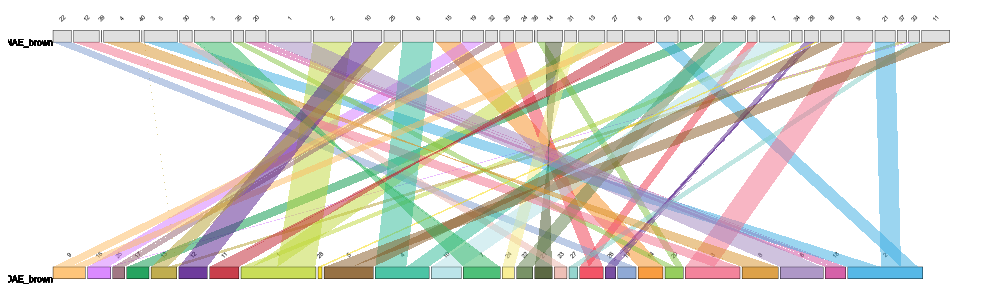

In [266]:
%%R -w 1000 -h 300
p =
    brock.draw.linear("test", 
            "chains/nospectacled_all_brown_sizes.txt",
            'chains/brown_nospectacled_URSIDAE_brown_nospectacled_URSINAE_brown/URSIDAE_v_URSINAE.clean.map',
            directory = "/private/groups/shapirolab/brock/bears/rawfigs/",
            fileformat = "pdf", 
            w=13, 
            h=5, 
            opacity = .5)

print(p)

New

R[write to console]: Saving linear image to /private/groups/shapirolab/brock/bears/rawfigs/



[1] "/private/groups/shapirolab/brock/bears/rawfigs//test.pdf"


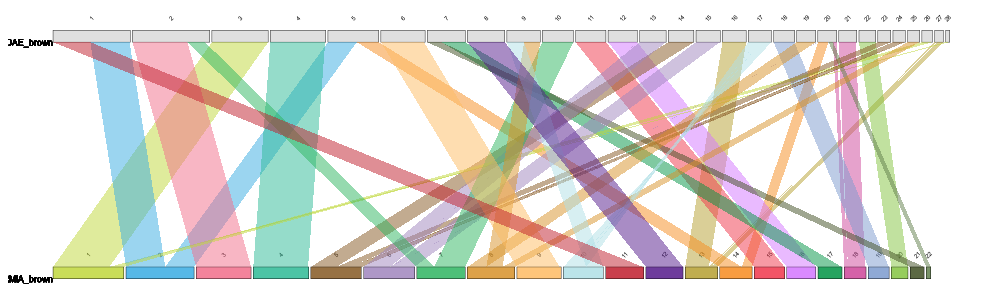

In [290]:
%%R -w 1000 -h 300
p =
    brock.draw.linear("test", 
            "chains/nospectacled_all_brown_sizes.txt",
            'chains/brown_nospectacled_CANIFORMIA_brown_nospectacled_URSIDAE_brown/CANIFORMIA_v_URSIDAE.clean.map',
            #'chains/brown_nospectacled_URSIDAE_brown_nospectacled_URSINAE_brown/URSIDAE_v_URSINAE.clean.map',
            directory = "/private/groups/shapirolab/brock/bears/rawfigs/",
            fileformat = "pdf", 
            w=13, 
            h=5, 
            opacity = .5)

print(p)

Old

R[write to console]: Saving linear image to /private/groups/shapirolab/brock/bears/rawfigs/



[1] "/private/groups/shapirolab/brock/bears/rawfigs//test.pdf"


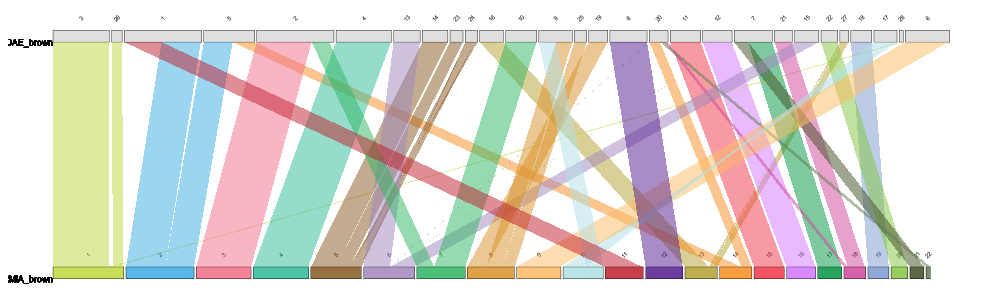

In [287]:
%%R -w 1000 -h 300
p =
    brock.draw.linear("test", 
            "chains/nospectacled_all_brown_sizes_ordered.txt",
            'chains/brown_nospectacled_CANIFORMIA_brown_nospectacled_URSIDAE_brown/CANIFORMIA_v_URSIDAE.clean.map',
            #'chains/brown_nospectacled_URSIDAE_brown_nospectacled_URSINAE_brown/URSIDAE_v_URSINAE.clean.map',
            directory = "/private/groups/shapirolab/brock/bears/rawfigs/",
            fileformat = "pdf", 
            w=13, 
            h=5, 
            opacity = .5)

print(p)

300K block all bears except asiatic

R[write to console]: Saving linear image to /private/groups/shapirolab/brock/bears/rawfigs/



[1] "/private/groups/shapirolab/brock/bears/rawfigs//test.pdf"


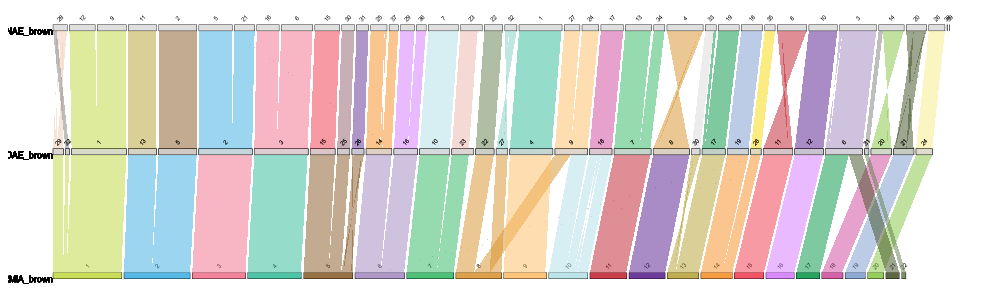

In [324]:
%%R -w 1000 -h 300
p =
    brock.draw.linear("test", 
            "chains/all_brown_sizes_ordered.txt.v",
            'chains/brown_URSIDAE_brown_URSINAE_brown/URSIDAE_v_URSINAE.clean.map',
            'chains/brown_CANIFORMIA_brown_URSIDAE_brown/CANIFORMIA_v_URSIDAE.clean.map',
            directory = "/private/groups/shapirolab/brock/bears/rawfigs/",
            fileformat = "pdf", 
            w=13, 
            h=5, 
            opacity = .5)

print(p)

EH plot to examine some chromosomes

In [348]:
%%R
species = c('brown','polar','black','sun','sloth','spectacled','panda','seal','dog','cat')
for (SPECIES in species){
    DIR = 'chains/ursidae_brown_052125_300K/output/'
    clean_cmd_1 = paste0('sed "s/_/x/g" ',DIR,'APCF_',SPECIES,'.merged.map > ',DIR,'APCF_',SPECIES,'.merged.x.map')
    system(clean_cmd_1)
    mapfile = paste0('chains/ursidae_brown_052125_300K/output/APCF_',SPECIES,'.merged.x.map')
    outfile = paste0('APCF_',SPECIES,'.highway')
    reformat.syntenyData(directory = 'chains/ursidae_brown_052125_300K/output/',
                         file_data = mapfile, 
                         filename = outfile,
                         reference.species = 'APCF',
                         target.species = SPECIES)
    clean_cmd_2 = paste0('sed -i "s/x/_/g" ',DIR,'APCF_',SPECIES,'.highway.txt;rm ',DIR,'APCF_',SPECIES,'.merged.x.map')
    system(clean_cmd_2)
}
combine_cmd = paste0('cat ',DIR,'APCF*highway.txt > ',DIR,'all_highway.txt')
system(combine_cmd)
#

species = c('brown','polar','black','sun','sloth','spectacled','panda','seal','dog','cat')
for (SPECIES in species){
    DIR = 'chains/ursinae_brown_052125_300K/output/'
    clean_cmd_1 = paste0('sed "s/_/x/g" ',DIR,'APCF_',SPECIES,'.merged.map > ',DIR,'APCF_',SPECIES,'.merged.x.map')
    system(clean_cmd_1)
    mapfile = paste0('chains/ursinae_brown_052125_300K/output/APCF_',SPECIES,'.merged.x.map')
    outfile = paste0('APCF_',SPECIES,'.highway')
    reformat.syntenyData(directory = 'chains/ursinae_brown_052125_300K/output/',
                         file_data = mapfile, 
                         filename = outfile,
                         reference.species = 'APCF',
                         target.species = SPECIES)
    clean_cmd_2 = paste0('sed -i "s/x/_/g" ',DIR,'APCF_',SPECIES,'.highway.txt;rm ',DIR,'APCF_',SPECIES,'.merged.x.map')
    system(clean_cmd_2)
}
combine_cmd = paste0('cat ',DIR,'APCF*highway.txt > ',DIR,'all_highway.txt')
system(combine_cmd)
#


species = c('brown','polar','black','sun','sloth','spectacled','panda','seal','dog','cat')
for (SPECIES in species){
    DIR = 'chains/caniformia_brown_052125_300K/output/'
    clean_cmd_1 = paste0('sed "s/_/x/g" ',DIR,'APCF_',SPECIES,'.merged.map > ',DIR,'APCF_',SPECIES,'.merged.x.map')
    system(clean_cmd_1)
    mapfile = paste0('chains/caniformia_brown_052125_300K/output/APCF_',SPECIES,'.merged.x.map')
    outfile = paste0('APCF_',SPECIES,'.highway')
    reformat.syntenyData(directory = 'chains/caniformia_brown_052125_300K/output/',
                         file_data = mapfile, 
                         filename = outfile,
                         reference.species = 'APCF',
                         target.species = SPECIES)
    clean_cmd_2 = paste0('sed -i "s/x/_/g" ',DIR,'APCF_',SPECIES,'.highway.txt;rm ',DIR,'APCF_',SPECIES,'.merged.x.map')
    system(clean_cmd_2)
}
combine_cmd = paste0('cat ',DIR,'APCF*highway.txt > ',DIR,'all_highway.txt')
system(combine_cmd)
#

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted text file to chains/ursidae_brown_052125_300K/output/

R[write to console]: Writing reformatted

R[write to console]: Saving eh image for chromosome 28 to /private/groups/shapirolab/brock/bears/rawfigs/



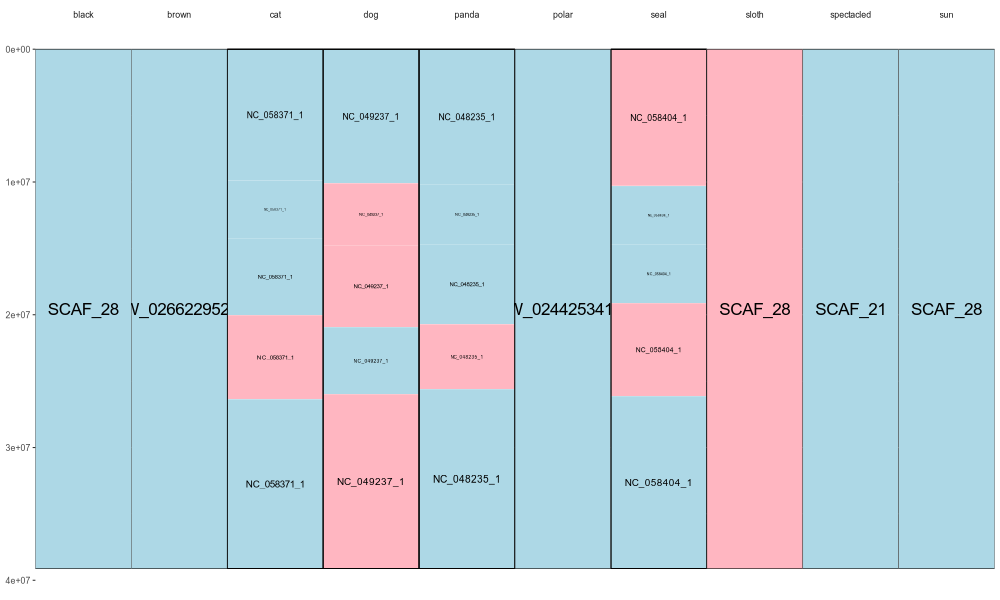

In [383]:
%%R -w 1000 -h 600
draw.eh(output = "outputName", 
        chrRange = c(28), 
        data_file = 'chains/ursinae_brown_052125_300K/output/all_highway.txt',
        directory = "/private/groups/shapirolab/brock/bears/rawfigs/", 
        fileformat = "pdf")

R[write to console]: Saving eh image for chromosome 20 to /private/groups/shapirolab/brock/bears/rawfigs/



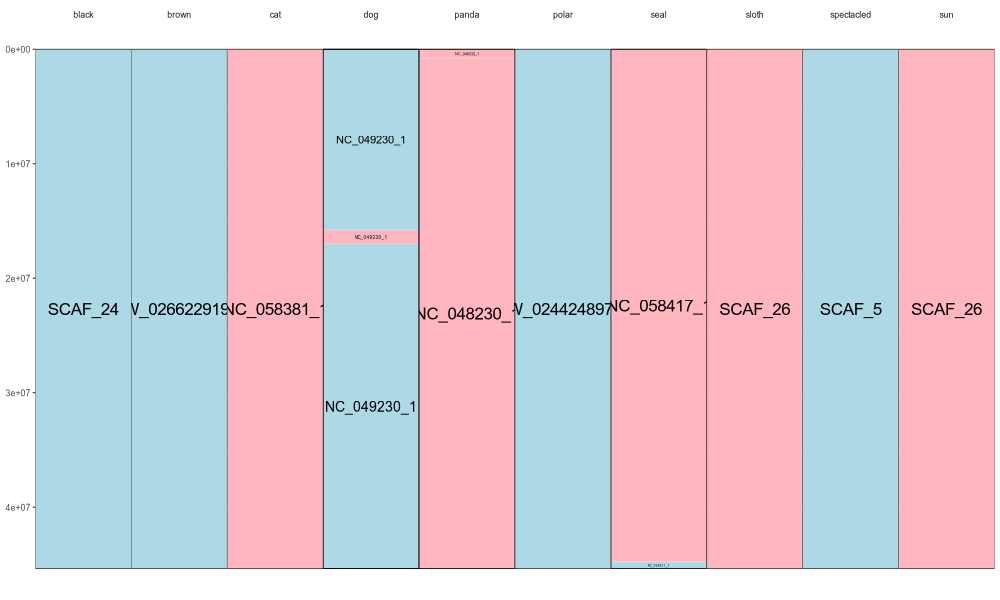

In [350]:
%%R -w 1000 -h 600
draw.eh(output = "outputName", 
        chrRange = c(20), 
        data_file = 'chains/caniformia_brown_052125_300K/output/all_highway.txt',
        directory = "/private/groups/shapirolab/brock/bears/rawfigs/", 
        fileformat = "pdf")

### Fig. 3 Post-curation

R[write to console]: Saving linear image to /private/groups/shapirolab/brock/bears/rawfigs/



[1] "/private/groups/shapirolab/brock/bears/rawfigs//clean_3_ancestor.pdf"


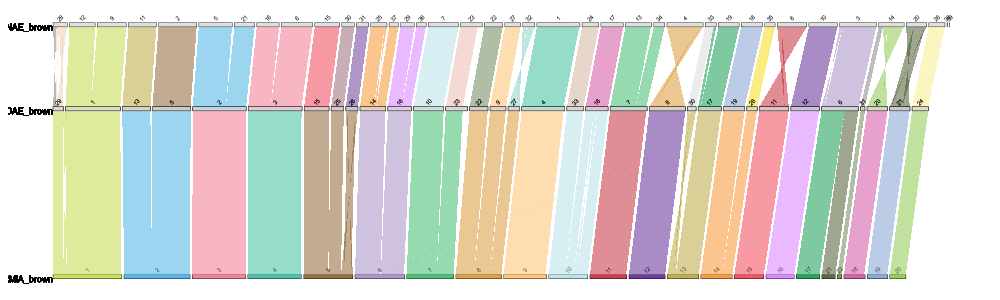

In [381]:
%%R -w 1000 -h 300
p =
    brock.draw.linear("clean_3_ancestor", 
            "chains/curated/all_brown_sizes_ordered.txt.v4",
            'chains/curated/URSIDAE_v_URSINAE.clean.map',
            'chains/curated/CANIFORMIA_v_URSIDAE.clean.map',
            directory = "/private/groups/shapirolab/brock/bears/rawfigs/",
            fileformat = "pdf", 
            w=13, 
            h=5, 
            opacity = .5)

print(p)

URSINAE_to_brown_bear

R[write to console]: Saving linear image to /private/groups/shapirolab/brock/bears/rawfigs/



[1] "/private/groups/shapirolab/brock/bears/rawfigs//ursinae_to_brown.pdf"


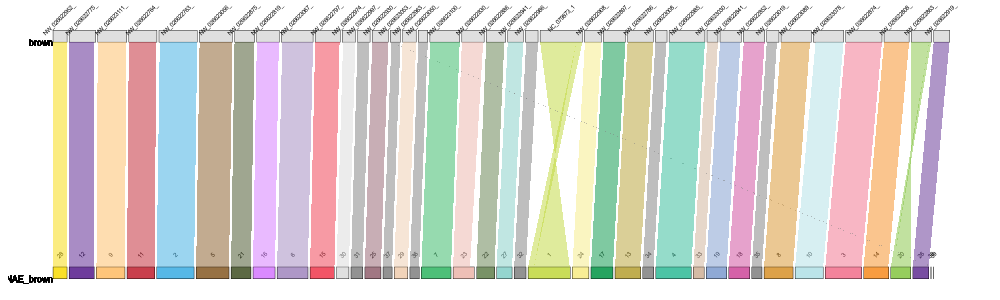

In [364]:
%%R -w 1000 -h 300
p =
    brock.draw.linear("ursinae_to_brown", 
            "chains/curated/brown_v_ursinae_ordered.txt.v6",
            'chains/curated/APCF_brown.clean.map',
            directory = "/private/groups/shapirolab/brock/bears/rawfigs/",
            fileformat = "pdf", 
            w=13, 
            h=5, 
            opacity = .5)

print(p)

### Supp. figure panda and spectacled

R[write to console]: Saving linear image to /private/groups/shapirolab/brock/bears/rawfigs/



[1] "/private/groups/shapirolab/brock/bears/rawfigs//ursidae_to_spectacled.pdf"


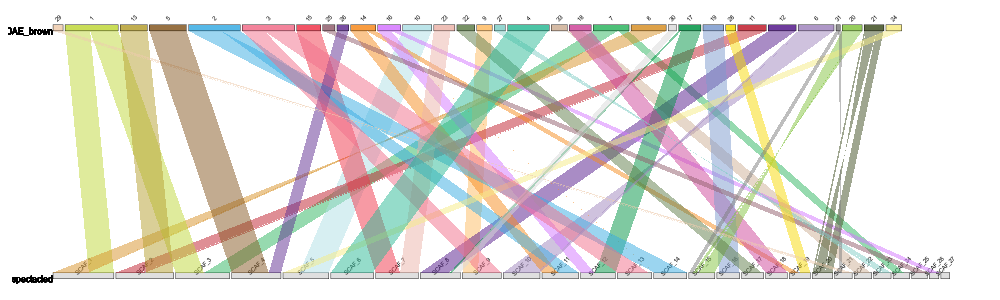

In [376]:
%%R -w 1000 -h 300
p =
    brock.draw.linear("ursidae_to_spectacled", 
            "chains/curated/spetacled_URSIDAE_panda.txt",
            'chains/curated/APCF_spectacled.clean.map',
            directory = "/private/groups/shapirolab/brock/bears/rawfigs/",
            fileformat = "pdf", 
            w=13, 
            h=5, 
            opacity = .5)

print(p)

R[write to console]: Saving linear image to /private/groups/shapirolab/brock/bears/rawfigs/



[1] "/private/groups/shapirolab/brock/bears/rawfigs//miisc.pdf"


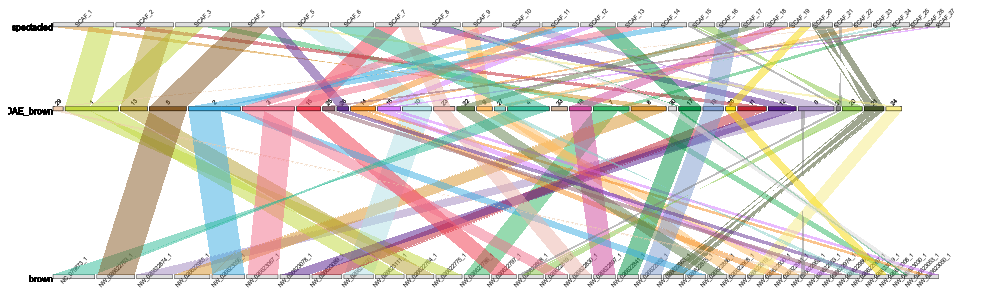

In [384]:
%%R -w 1000 -h 300
p =
    brock.draw.linear("miisc", 
            "chains/curated/brown_URSIDAE_spectacled.txt",
            'chains/ursidae_brown_052125_300K/output/APCF_brown.clean.map',
            'chains/ursidae_brown_052125_300K/output/APCF_spectacled.clean.map',
            directory = "/private/groups/shapirolab/brock/bears/rawfigs/",
            fileformat = "pdf", 
            w=13, 
            h=5, 
            opacity = .5)

print(p)

R[write to console]: Saving linear image to /private/groups/shapirolab/brock/bears/rawfigs/



[1] "/private/groups/shapirolab/brock/bears/rawfigs//ursidae_to_panda.pdf"


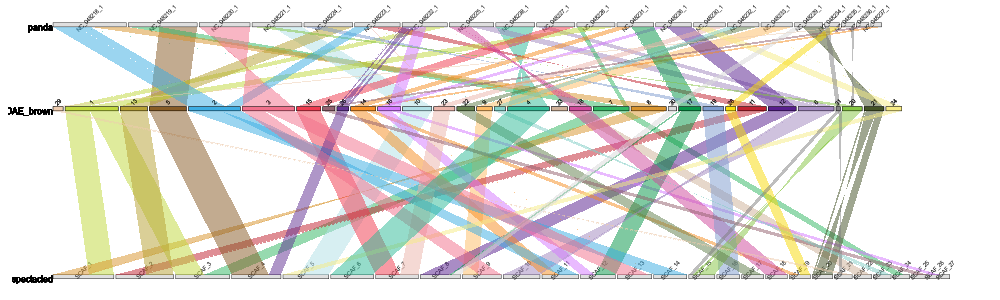

In [375]:
%%R -w 1000 -h 300
p =
    brock.draw.linear("ursidae_to_panda", 
            "chains/curated/spetacled_URSIDAE_panda.txt",
            'chains/ursidae_brown_052125_300K/output/APCF_panda.clean.map',
            'chains/curated/APCF_spectacled.clean.map',
            directory = "/private/groups/shapirolab/brock/bears/rawfigs/",
            fileformat = "pdf", 
            w=13, 
            h=5, 
            opacity = .5)

print(p)

In [1436]:
%%R -w 1000 -h 300



brock.draw.linear <- function(output, sizefile, ..., directory = NULL, fileformat = "png", colours = colours.default, w = 13, h = 5, opacity = .5) {
    if (is.null(directory)) {
      directory <- tempdir()
    }
    synteny.data.reframing <- function(data, tar.y, ref.y, compiled.size) {
      synteny <- data.frame()
      
      for (i in seq_len(nrow(data))) {
        reference <- data[i, "ref.species"]
        target <- data[i, "tar.species"]
        tar_chr <- data[i, "tarchr"]
        ref_chr <- data[i, "refchr"]
        dir <- data[i, "dir"]
        
        # Get chromosome size offsets
        tar_sizes <- compiled.size[compiled.size$species == target, ]
        names(tar_sizes) <- c("tarchr", "size", "species", "xstart", "xend")
        ref_sizes <- compiled.size[compiled.size$species == reference, ]
        names(ref_sizes) <- c("refchr", "size", "species", "xstart", "xend")
        
        tar_add <- tar_sizes[as.character(tar_sizes$tarchr) == as.character(tar_chr), "xstart"]
        ref_add <- ref_sizes[as.character(ref_sizes$refchr) == as.character(ref_chr), "xstart"]
        
        tar_xstart <- data[i, "tarstart"] + tar_add
        tar_xend <- data[i, "tarend"] + tar_add
        ref_xstart <- data[i, "refstart"] + ref_add
        ref_xend <- data[i, "refend"] + ref_add
    
        tar_y <- tar.y
        ref_y <- ref.y
    
        # Determine if the segment is inverted
        inverted <- grepl("-", dir, fixed = TRUE)
        
        # Count how many rows match both tar_chr and ref_chr
        combo_count <- sum(data$tarchr == tar_chr & data$refchr == ref_chr)
        
        # If inverted and only one row with this tar_chr-ref_chr, treat as non-inverted
        if (inverted && combo_count == 1) {
          inverted <- FALSE
        }
        
        # Build polygon depending on inversion status
        if (inverted) {
          df <- data.frame(
            x = c(tar_xstart, tar_xend, ref_xstart, ref_xend), 
            y = c(tar_y, tar_y, ref_y, ref_y),
            fill = ref_chr, 
            group = paste0("s", i), 
            ref = reference, 
            tar = target
          )
        } else {
          df <- data.frame(
            x = c(tar_xstart, ref_xstart, ref_xend, tar_xend), 
            y = c(tar_y, ref_y, ref_y, tar_y),
            fill = ref_chr, 
            group = paste0("s", i), 
            ref = reference, 
            tar = target
          )
        }
        
        synteny <- rbind(synteny, df)
      }
      
      return(synteny)
    }

    colours.default <- c(
      "1" = "#BFD73B", "2" = "#39ACE2", "3" = "#F16E8A",
      "4" = "#2DB995", "5" = "#855823", "6" = "#A085BD",
      "7" = "#2EB560", "8" = "#D79128", "9" = "#FDBB63",
      "10" = "#AFDFE5", "11" = "#BF1E2D", "12" = "purple4",
      "13" = "#B59F31", "14" = "#F68B1F", "15" = "#EF374B",
      "16" = "#D376FF", "17" = "#009445", "18" = "#CE4699",
      "19" = "#7C9ACD", "20" = "#84C441", "21" = "#404F23",
      "22" = "#607F4B", "23" = "#EBB4A9", "24" = "#F6EB83",
      "25" = "#915F6D", "26" = "#602F92", "27" = "#81CEC6",
      "28" = "#F8DA04", "29" = "peachpuff2", "30" = "gray85", "33" = "peachpuff3",
      "W" = "#9590FF", "Z" = "#666666", "Y" = "#9590FF", "X" = "#666666",
      "LGE22" = "grey", "LGE64" = "gray64",
      "1A" = "pink", "1B" = "dark blue", "4A" = "light green",
      "Gap" = "white", "LG2" = "black", "LG5" = "#CC99CC"
    )
    xstart <- xend <- refchr <- tarchr <- x <- y <- group <- fill <- chromosome <- species <- NULL
    sizes <- utils::read.delim(sizefile, header = FALSE) # to be consistent with naming in EH
    names(sizes) <- c("chromosome", "size", "species")
    sizes$size <- as.numeric(gsub(",", "", sizes$size))
    count <- 0
    compiled.size <- data.frame()
    for (i in unique(sizes$species)) {
      size.intermediate <- sizes[sizes$species == i, ]
      for (x in c(1:nrow(size.intermediate))) {
        if (x == 1) {
          total_start <- 1
          total_end <- size.intermediate[x, "size"]
        } else {
          total_start <- total_end + 6000000
          total_end <- total_start + size.intermediate[x, "size"]
        }
        size.intermediate[x, "xstart"] <- total_start
        size.intermediate[x, "xend"] <- total_end
      }
      compiled.size <- rbind(compiled.size, size.intermediate)
    }
    for (z in unique(compiled.size$species)) {
      compiled.size$y[compiled.size$species == z] <- count
      count <- count + 2
    }

    list.of.files <- list()
    for (i in list(...)) {
        list.of.files[[i]] <- i
    }
    
    listsynt <- list()
    for (i in 1:length(list.of.files)) {
      num <- i
      file <- list.of.files[[num]]
      dataTMP <- utils::read.delim(file, header = FALSE)
      data2 <- dataTMP[, c(4, 5, 6, 1, 2, 3, 7, 8, 9)]
      colnames(data2) <- c("tarchr", "tarstart", "tarend", "refchr", "refstart", "refend", "dir", "ref.species", "tar.species")
      data2$tarstart <- as.numeric(gsub(",", "", data2$tarstart))
      data2$tarend <- as.numeric(gsub(",", "", data2$tarend))
      data2$refstart <- as.numeric(gsub(",", "", data2$refstart))
      data2$refend <- as.numeric(gsub(",", "", data2$refend))
      reference <- data2[1, "ref.species"]
      target <- data2[1, "tar.species"]
      ref_y <- compiled.size[compiled.size$species == reference, "y"]
      tar_y <- compiled.size[compiled.size$species == target, "y"]
      if (tar_y[1] > ref_y[1]){
        ref_y <- ref_y[1] + 0.1
        tar_y <- tar_y[1]
      } else{
        ref_y <- ref_y[1]
        tar_y <- tar_y[1] + 0.1
      }
      x <- synteny.data.reframing(data2, tar_y, ref_y, compiled.size)
      x$fill <- as.factor(x$fill)
      listsynt[[i]] <- x
    }
    compiled.size$chromosome <- as.factor(compiled.size$chromosome)
    p <- ggplot2::ggplot()
    for (i in 1:length(listsynt)) {
      data <- listsynt[[i]]
      reference <- data[1, "ref"]
      target <- data[1, "tar"]
      ref_sizes <- compiled.size[compiled.size$species == reference, ]
      tar_sizes <- compiled.size[compiled.size$species == target, ]
      p <- p + ggplot2::geom_rect(
        data = ref_sizes, mapping = ggplot2::aes(xmin = xstart, xmax = xend, ymin = y, ymax = y + 0.10, fill = chromosome),
        color = "black", alpha = 0.85, linewidth = 0.2
      ) +
        ggplot2::geom_text(data = ref_sizes, ggplot2::aes(x = (xstart + xend) / 2, y = y + 0.2, label = chromosome), size = 2, angle = 45) +
        ggplot2::geom_text(data = ref_sizes, mapping = ggplot2::aes(x = 2, y = y, label = species), size = 3, hjust = 1) +
        ggplot2::geom_rect(
          data = tar_sizes, mapping = ggplot2::aes(xmin = xstart, xmax = xend, ymin = y, ymax = y + 0.10), fill = "grey85",
          color = "black", alpha = 0.85, linewidth = 0.2
        ) +
        ggplot2::geom_text(data = tar_sizes, ggplot2::aes(x = (xstart + xend) / 2, y = y + 0.2, label = chromosome), size = 2, angle = 45) +
        ggplot2::geom_text(data = tar_sizes, mapping = ggplot2::aes(x = 2, y = y, label = species), size = 3, hjust = 1) +
        ggplot2::geom_polygon(data = data, alpha = opacity, ggplot2::aes(x = x, y = y, group = group, fill = fill))
    }
    p <- p + ggplot2::scale_fill_manual(values = colours) +
      ggplot2::theme(
        panel.background = ggplot2::element_blank(),
        strip.background = ggplot2::element_blank(),
        axis.title.y = ggplot2::element_blank(),
        axis.title.x = ggplot2::element_blank(),
        axis.text.x = ggplot2::element_blank(),
        axis.text.y = ggplot2::element_blank(),
        axis.ticks.x = ggplot2::element_blank(),
        axis.ticks.y = ggplot2::element_blank(),
        legend.position = "none"
    )
    message(paste0("Saving linear image to ", directory))
    print(p)
    ggplot2::ggsave(paste0(directory,"/",output, ".", fileformat), p, device = fileformat, width = w, height = h)
}

## Tree annotation

In [174]:
%%bash

## Add sloth-inferred ancestors to counts folder
#REF="sloth"
#ANCESTORS=("URSINAE" "SS")
#for ((i = 0; i < ${#ANCESTORS[@]}; i++)); do
#    for ((j = i + 1; j < ${#ANCESTORS[@]}; j++)); do
#        ANC1=${ANCESTORS[i]}
#        ANC2=${ANCESTORS[j]}
#        mapfile="chains/${REF}_${ANC1}_${REF}_${ANC2}_${REF}/APCF_${ANC2}_${REF}.merged.map"
#        cp "$mapfile" "chains/nodeVnode_files/${ANC1}_to_${ANC2}.map"
#    done
#done

## Add brown-inferred ancestors to counts folder
REF="brown"
ANCESTORS=("CANIFORMIA" "ARCTOIDEA" "URSIDAE" "USPECT" "URSINAE" "BPB" "BP")
for ((i = 0; i < ${#ANCESTORS[@]}; i++)); do
    for ((j = i + 1; j < ${#ANCESTORS[@]}; j++)); do
        ANC1=${ANCESTORS[i]}
        ANC2=${ANCESTORS[j]}
        mapfile="chains/${REF}_${ANC1}_${REF}_${ANC2}_${REF}/APCF_${ANC2}_${REF}.merged.map"
        cp "$mapfile" "chains/nodeVnode_files/${ANC1}_to_${ANC2}.map"
    done
done

## Add tip lineage comparisons to counts folder
cp chains/caniformia_brown_052125_1000K/output/APCF_dog.merged.map chains/nodeVnode_files/caniformia_to_dog.map
cp chains/arctoidea_brown_052125_1000K/output/APCF_seal.merged.map chains/nodeVnode_files/ARCTOIDEA_to_seal.map
cp chains/ursidae_brown_052125_1000K/output/APCF_panda.merged.map chains/nodeVnode_files/URSIDAE_to_panda.map
cp chains/uspect_brown_052125_1000K/output/APCF_spectacled.merged.map chains/nodeVnode_files/USPECT_to_spectacled.map
cp chains/bpb_brown_052125_1000K/output/APCF_black.merged.map chains/nodeVnode_files/BPB_to_black.map
cp chains/bp_brown_052125_1000K/output/APCF_brown.merged.map chains/nodeVnode_files/BP_to_brown.map
cp chains/bp_brown_052125_1000K/output/APCF_polar.merged.map chains/nodeVnode_files/BP_to_polar.map
#cp chains/ss_sloth_052125_1000K/output/APCF_sun.merged.map chains/nodeVnode_files/SS_to_sun.map
#cp chains/ss_sloth_052125_1000K/output/APCF_sloth.merged.map chains/nodeVnode_files/SS_to_sloth.map

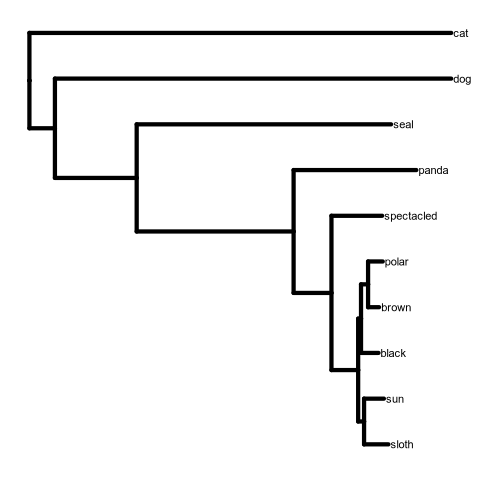

In [175]:
%%R
library(scico)
# Save basic time tree for annotation in illustrator
tree = read.tree('chains/ursidae_brown_052125_1000K/tree.txt')
p = ggtree(tree,
       ladderize = FALSE, size=2) +
        geom_tiplab()
print(p)
ggsave('rawfigs/ebr_tree_basic.pdf',width=3,height=5)

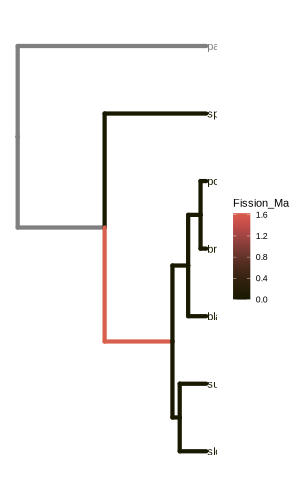

In [1558]:
%%R -w 300 -h 500
library(scico)
# Save basic time tree for annotation in illustrator
tree = read.tree('chains/ursinae/tree.txt')
data = 
    read.table('chains/change_counts.txt', header = T)
tree = full_join(tree, data, by = 'node')
p = ggtree(tree, aes(color=Fission_Ma), 
       ladderize = FALSE, size=2) +
        scale_color_scico(palette = 'lajolla', begin = 0, end = 0.5) +
        geom_tiplab()
print(p)
ggsave('rawfigs/rate_per_Ma_tree.pdf',width=3,height=5)

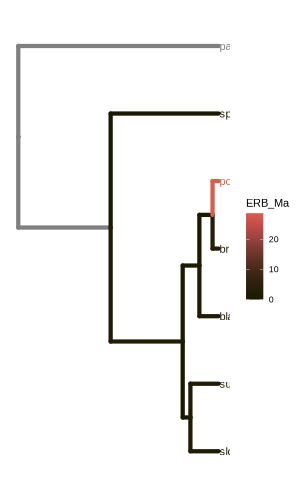

In [1615]:
%%R -w 300 -h 500
library(scico)
# Save basic time tree for annotation in illustrator
tree = read.tree('chains/ursinae/tree.txt')
data = 
    read.table('chains/change_counts.txt', header = T)
tree = full_join(tree, data, by = 'node')
p = ggtree(tree, aes(color=ERB_Ma), 
       ladderize = FALSE, size=2) +
        scale_color_scico(palette = 'lajolla', begin = 0, end = 0.5) +
        geom_tiplab()
print(p)
ggsave('rawfigs/EBR_per_Ma_tree.pdf',width=3,height=5)

## Breakpoint features

This section parses through all the breakpoint regions to see if there are any enriched elements. Surprise - there are.

### Data processing
Manually create fission/fusion bed file by looking through mapping:

In [468]:
%%R
fread('chains/breakpoints/fi_fu.bed') %>%
    set_colnames(c('chrom','Bstart','Bend','eventname')) %>%
    mutate(refgenome = 'ursidae') %>%
    mutate(refgenome = ifelse(grepl('NC',chrom),"panda",refgenome)) %>%
    mutate(refgenome = ifelse(grepl('SCAF',chrom),"spectacled",refgenome)) %>%
    mutate(bp_uncertainty = Bend - Bstart) %>%
    print
    #mutate(midpoint = Bstart + round(bp_uncertainty/2), start = midpoint, end = midpoint) %>%
    #dplyr::select(chrom,start,end,eventname,refgenome,Bstart,Bend) %>%
    #fwrite('chains/breakpoints/fi_fu_metadata.bed',col.names=T,sep="\t",quote=F)

          chrom    Bstart      Bend        eventname  refgenome bp_uncertainty
         <char>     <int>     <int>           <char>     <char>          <int>
 1: NC_048218.1 108950057 108950157       panda_fu_1      panda            100
 2: NC_048219.1  90171968  90369618       panda_fu_2      panda         197650
 3: NC_048221.1  57875188  57967912       panda_fu_3      panda          92724
 4: NC_048224.1  60736021  60823629       panda_fu_4      panda          87608
 5: NC_048223.1  43276640  43287619      panda_fu_5a      panda          10979
 6: NC_048223.1  44705643  45174195      panda_fu_5b      panda         468552
 7: NC_048223.1 130341725 130520789      panda_fu_5c      panda         179064
 8: NC_048223.1 131018422 131018529      panda_fu_5d      panda            107
 9: NC_048222.1  34634619  34686035       panda_fu_6      panda          51416
10: NC_048222.1  70997757  71169084       panda_fu_7      panda         171327
11: NC_048225.1  62513537  62531107       panda_fu_8

Now make some sets of windows

In [3]:
%%bash
for REFERENCE in panda spectacled sun brown;do
    
    ## Create genome wide windows
    bedtools makewindows -g chains/breakpoints/${REFERENCE}.fasta.masked.fai -w 100000 -s 50000 > chains/breakpoints/${REFERENCE}_100kb_by_50kb.bed
    
    ## Extend regions around breakpoints, using bedtools because we don't want to extend past the beginnings/ends of chromosomes
    bedtools slop -b 1000000 -g chains/breakpoints/${REFERENCE}.fasta.masked.fai -i <(grep -e "\<$REFERENCE\>" chains/breakpoints/fi_fu_metadata.bed) > chains/breakpoints/${REFERENCE}_fi_fu_1MB.bed

    ## Subtract/intersect to create non-overlapping sets
    bedtools subtract -A -a chains/breakpoints/${REFERENCE}_100kb_by_50kb.bed -b chains/breakpoints/${REFERENCE}_fi_fu_1MB.bed > chains/breakpoints/${REFERENCE}_OUTside_1MB.bed
    bedtools intersect -wa -a chains/breakpoints/${REFERENCE}_100kb_by_50kb.bed -b chains/breakpoints/${REFERENCE}_fi_fu_1MB.bed > chains/breakpoints/${REFERENCE}_INside_1MB.bed
done

Check out repeat content

In [4]:
%%R
## Avoid some awkward formatting in the 'out' file
repeats = 
lapply(c('panda','spectacled','sun','brown'),
       function(REF){
            fread(cmd=paste0('tail -n+4 repeats/',REF,'/',REF,'.fasta.out'),header=F, fill =T) %>% 
            set_colnames(c('SW_score','perc_div','perc_del','perc_ins','query_seq','query_start','query_end','query_bp_left','sign','matching_repeat','family','repeat_begin','repeat_end','repeat_bp_left','ID','misc')) %>%
            mutate(ref = REF)
})


R[write to console]: |--------------------------------------------------|
|
R[write to console]: ========================
R[write to console]: ========
R[write to console]: =========
R[write to console]: ========
R[write to console]: =
R[write to console]: |

R[write to console]: |--------------------------------------------------|
|
R[write to console]: ====================
R[write to console]: ========
R[write to console]: =======
R[write to console]: =======
R[write to console]: =======
R[write to console]: =
R[write to console]: |

R[write to console]: |--------------------------------------------------|
|
R[write to console]: ===============
R[write to console]: =======
R[write to console]: =======
R[write to console]: ========
R[write to console]: =======
R[write to console]: ======
R[write to console]: |

R[write to console]: |--------------------------------------------------|
|
R[write to console]: =================
R[write to console]: ========
R[write to console]: ========
R

### Repeat mapping

In [5]:
%%R
library(bedtoolsr)
repeats_sorted =
    lapply(repeats,function(REFDF){
    repeat_families = unique(REFDF$family)
    rlist = lapply(repeat_families,
                   function(FAMILY){REFDF %>% 
                                    filter(family == FAMILY) %>%
                                    dplyr::select(query_seq,query_start,query_end,family,matching_repeat) %>%
                                    mutate(query_start = query_start - 1) %>%
                                    bedtoolsr::bt.sort(.) %>%
                                    bedtoolsr::bt.merge(.)})
    names(rlist) = repeat_families
    return(rlist)
})
names(repeats_sorted) = c('panda','spectacled','sun','brown')

Now intersect with windows

In [6]:
%%R
repeats_mapped = lapply(c('panda', 'spectacled', 'sun', 'brown'), function(REF) {
  print(REF)
  
  OUTside = fread(paste0('chains/breakpoints/', REF, '_OUTside_1MB.bed')) %>%
    set_colnames(c('query_seq', 'query_start', 'query_end'))

  species_repeats = repeats_sorted[[REF]]
  print(head(species_repeats[[1]]))

  # Only perform IN-related steps if REF is not 'sun' or 'brown'
  if (!REF %in% c('sun', 'brown')) {
    INside = fread(paste0('chains/breakpoints/', REF, '_INside_1MB.bed')) %>%
      set_colnames(c('query_seq', 'query_start', 'query_end'))

    INlist = lapply(names(species_repeats), function(FAMILY) {
      bedtoolsr::bt.intersect(a = INside, b = species_repeats[[FAMILY]], wao = TRUE) %>%
        mutate(family = FAMILY, breakpoint = "YES")
    })
  } else {
    INlist = lapply(names(species_repeats), function(FAMILY) {
      data.frame(
    query_seq = character(0),
    query_start = integer(0),
    query_end = integer(0),
    V1 = character(0),
    V2 = integer(0),
    V3 = integer(0),
    V4 = character(0),
    family = character(0),
    breakpoint = character(0)
      )
    })
  }

  OUTlist = lapply(names(species_repeats), function(FAMILY) {
    bedtoolsr::bt.intersect(a = OUTside, b = species_repeats[[FAMILY]], wao = TRUE) %>%
      mutate(family = FAMILY, breakpoint = "NO")
  })

  combined = Map(bind_rows, INlist, OUTlist) %>%
    rbindlist(.)

  s_combined = combined %>%
    dplyr::select(V1, V2, V3, V7, family, breakpoint) %>%
    set_colnames(c('query_chrom', 'query_start', 'query_end', 'bp_overlap', 'family', 'breakpoint')) %>%
    group_by(breakpoint, family, query_chrom, query_start, query_end) %>%
    summarize(bp_overlap = sum(bp_overlap), .groups = "drop") %>%
    mutate(repeat_coverage = bp_overlap / 10000)

  return(list(combined, s_combined))
})


[1] "panda"
           V1    V2    V3
1 NC_009492.1   693  1023
2 NC_048218.1  3805  3834
3 NC_048218.1 10770 10805
4 NC_048218.1 15985 16203
5 NC_048218.1 16754 16779
6 NC_048218.1 25841 25878
[1] "spectacled"
      V1    V2    V3
1 SCAF_1    24  8788
2 SCAF_1  8796  8807
3 SCAF_1  9682  9795
4 SCAF_1 18682 18761
5 SCAF_1 29278 29322
6 SCAF_1 34251 34287
[1] "sun"
      V1    V2    V3
1 SCAF_1     0   445
2 SCAF_1   878   995
3 SCAF_1 12581 14047
4 SCAF_1 15009 16179
5 SCAF_1 16600 16751
6 SCAF_1 17195 18426
[1] "brown"
           V1    V2    V3
1 NC_003427.1   224   796
2 NC_079873.1     0 13462
3 NC_079873.1 17507 17559
4 NC_079873.1 18666 18705
5 NC_079873.1 20907 20943
6 NC_079873.1 26387 26404


In [7]:
%%R
combined = bind_rows(repeats_mapped[[1]][[1]] %>% mutate(species = 'panda'),
                     repeats_mapped[[2]][[1]]  %>% mutate(species = 'spectacled'),
                    repeats_mapped[[3]][[1]]  %>% mutate(species = 'sun'),
                    repeats_mapped[[4]][[1]]  %>% mutate(species = 'brown'))
s_combined = bind_rows(repeats_mapped[[1]][[2]]  %>% mutate(species = 'panda'),
                       repeats_mapped[[2]][[2]]  %>% mutate(species = 'spectacled'),
                      repeats_mapped[[3]][[2]]  %>% mutate(species = 'sun'),
                      repeats_mapped[[4]][[2]]  %>% mutate(species = 'brown'))

### Significance testing

In [41]:
%%R
library(dplyr)
library(purrr)

# Assuming your dataframe is called `df`
results <- 
    s_combined %>%
        filter(species %in% c('spectacled','panda')) %>%
        group_by(family) %>%
        filter(n_distinct(breakpoint) == 2) %>%  # Only test if there are exactly 2 groups to compare
        group_split() %>%
        map_df(~ {
          test_result <- t.test(repeat_coverage ~ breakpoint, data = .x)
    
    tibble(
      family = unique(.x$family),
      breakpoint_levels = paste(levels(factor(.x$breakpoint)), collapse = " vs "),
      p_value = test_result$p.value,
      t_statistic = test_result$statistic,
      mean_group_1 = test_result$estimate[1],
      mean_group_2 = test_result$estimate[2]
    )
  })
results %>%
    #filter(mean_group_2 > mean_group_1) %>%
    mutate(fold_change = mean_group_2/mean_group_1) %>%
    dplyr::select(family,p_value,mean_group_1,mean_group_2, fold_change) %>% 
    arrange(desc(fold_change),p_value) %>%
    print(n = Inf)

# A tibble: 42 × 5
   family              p_value mean_group_1 mean_group_2 fold_change
   <chr>                 <dbl>        <dbl>        <dbl>       <dbl>
 1 rRNA              4.45e-  3   0.00000936   0.000294        31.4  
 2 Unknown           1.26e- 17   0.00254      0.0428          16.8  
 3 LINE/R1           1.88e-  6   0.000179     0.00144          8.06 
 4 Satellite         4.71e- 12   0.000217     0.00174          8.03 
 5 DNA/TcMar-Tc1     1.22e- 18   0.000161     0.00115          7.16 
 6 LTR/Pao           1.42e-  1   0.000411     0.00206          5.02 
 7 DNA/TcMar-Tigger  1.08e- 45   0.00377      0.0146           3.86 
 8 LINE/L1           1.15e- 96   0.0956       0.348            3.64 
 9 LINE/L2           1.08e- 40   0.00532      0.0166           3.13 
10 DNA               2.45e-  2   0.0000274    0.0000775        2.83 
11 DNA/Zisupton      2.40e-  2   0.0000343    0.0000949        2.77 
12 LTR/ERV1          5.59e- 31   0.00474      0.0122           2.58 
13 LTR/ERVK    

Format repeat density and breakpoint data

In [90]:
%%R
all_repeats_density = 
    combined %>%
    dplyr::select(V1,V2,V3,V7,family,breakpoint,species) %>%
    group_by(V1,V2,V3,species) %>%
    summarize(bp_overlap = sum(V7)) %>%
    ungroup %>%
    mutate(repeat_coverage = bp_overlap/100000, midpoint = ((V3-V2)/2) + V2) %>%
    set_colnames(c('chrom','start','end','refgenome','bp_overlap','repeat_coverage','midpoint'))

repeat_family_density = 
    combined %>%
    dplyr::select(V1,V2,V3,V7,family,breakpoint,species) %>%
    group_by(V1,V2,V3,family,species) %>%
    summarize(bp_overlap = sum(V7)) %>%
    ungroup %>%
    mutate(repeat_coverage = bp_overlap/100000, midpoint = ((V3-V2)/2) + V2) %>%
    set_colnames(c('chrom','start','end','family','refgenome','bp_overlap','repeat_coverage','midpoint'))

breakpoints = 
    fread('chains/breakpoints/fi_fu_metadata.bed') %>%
    mutate(eventtype = ifelse(grepl('fu',eventname),'fusion','fission')) %>%
    mutate(length = Bend - Bstart) %>%
    mutate(plotStart = ifelse(length < 200000,Bstart - 100000, Bstart)) %>%
    mutate(plotEnd = ifelse(length < 200000,Bend + 100000, Bend))

chroms =
    bind_rows(fread('chains/spectacled.sizes') %>% set_colnames(c('chrom','size')) %>% mutate(refgenome = 'spectacled') %>% filter(!grepl('SCAF_27',chrom)),
              fread('chains/panda.sizes') %>% set_colnames(c('chrom','size')) %>% mutate(refgenome = 'panda'),
              fread('chains/sun.sizes') %>% set_colnames(c('chrom','size')) %>% mutate(refgenome = 'sun'),
              fread('chains/brown.sizes') %>% set_colnames(c('chrom','size')) %>% mutate(refgenome = 'brown'))



`summarise()` has grouped output by 'V1', 'V2', 'V3'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'V1', 'V2', 'V3', 'family'. You can
override using the `.groups` argument.


### Supplemental ideogram plots

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


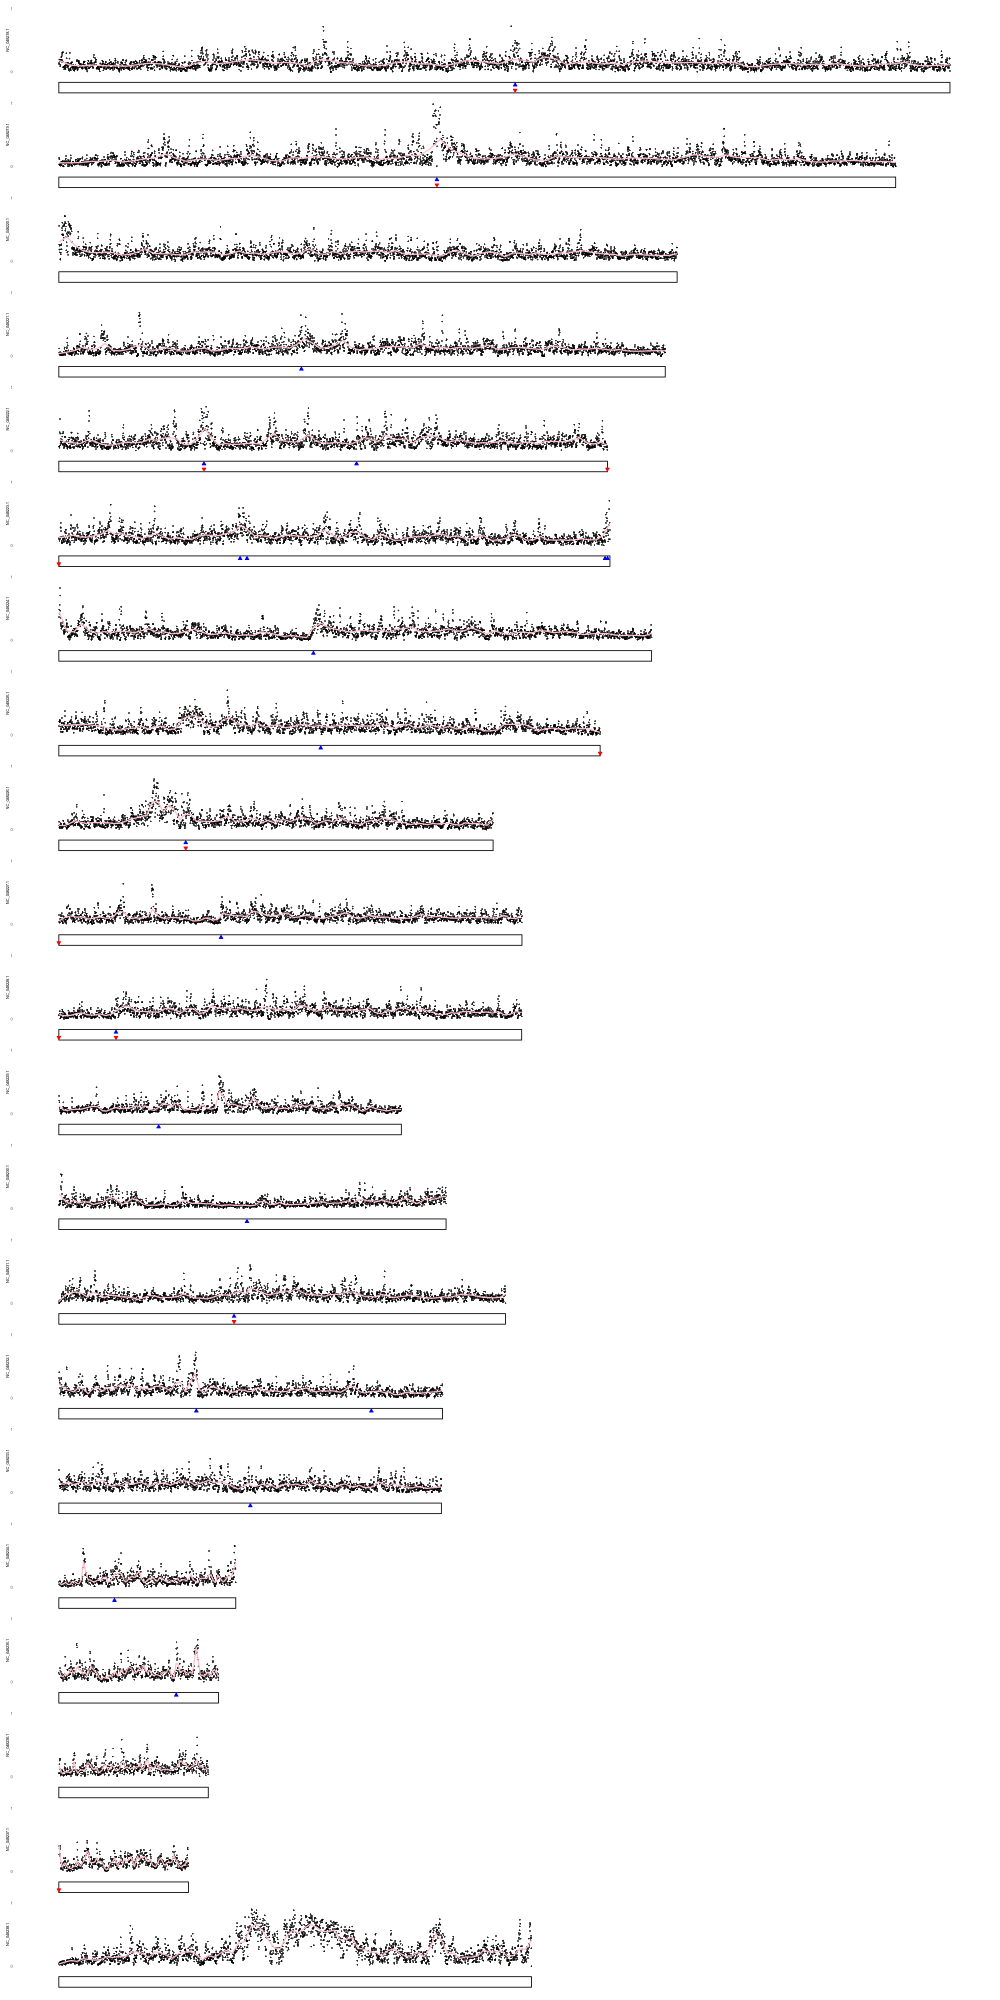

In [114]:
%%R -w 1000 -h 2000

library(data.table)
library(dplyr)
library(ggplot2)
library(patchwork)
library(ggrastr)

#### Shape SIZE
SHAPESIZE = 1
SHAPEALPHA = 1
SHAPELIMITS = c(-1.5, 0.5)
MARGINS = unit(c(0, 0, 0, 0), "cm")
BASESIZE = 4

################

SPECIES <- 'spectacled'
FAMILY <- 'LINE/L1'

# Chromosomes to plot
#FOCAL <- paste0("SCAF_", 1:26)  # Or use actual chroms_keep list

# Load sizes and find maximum
chrom_sizes <- fread('chains/spectacled.sizes') %>%
  set_colnames(c('chrom','size')) %>%
    filter(chrom != 'SCAF_27')
max_size <- max(chrom_sizes$size)
FOCAL = chrom_sizes$chrom
#FOCAL = c('SCAF_25','SCAF_26')

plot_list <- list()

for (chrom in FOCAL) {
  chr_size <- chrom_sizes %>% filter(chrom == !!chrom) %>% pull(size)

repeat_plot <- ggplot(
  repeat_family_density %>% 
    filter(refgenome == SPECIES, chrom == !!chrom, family == FAMILY)
) +
  rasterize(geom_point(aes(x = midpoint, y = repeat_coverage), size = 0.1, alpha = 0.6), dpi = 600) +
  geom_smooth(aes(x = midpoint, y = repeat_coverage), method = "loess", span = 0.05, se = FALSE, size = 0.6, col = 'pink') +
  scale_x_continuous(limits = c(0, max_size)) +
  scale_y_continuous(limits = c(0,1), breaks = c(0,1)) +
  labs(y = chrom) +
  theme_minimal(base_size = BASESIZE) +
  theme(
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    axis.title.y = element_text(angle = 90, vjust = 0.5, hjust = 0.5, size = BASESIZE),
    axis.text.y = element_text(size = BASESIZE),
    plot.margin = MARGINS,
    panel.spacing = unit(0, "lines"),
    panel.grid = element_blank()
  )

ideo_plot <- ggplot() +
  geom_rect(
    data = chrom_sizes %>% filter(chrom == !!chrom),
    aes(xmin = 0, xmax = size, ymin = -1, ymax = 0),
    size = 0.4, color = 'black', fill = 'white', alpha = 0.5
  ) +
  geom_point(
      data = breakpoints %>% filter(refgenome == SPECIES, eventtype == 'fusion', chrom == !!chrom),
      aes(x = end, y = -0.25),
      color = 'blue', fill = 'blue', shape = 24, size = SHAPESIZE, alpha = SHAPEALPHA
  ) +
  geom_point(
      data = breakpoints %>% filter(refgenome == SPECIES, eventtype == 'fission', chrom == !!chrom),
      aes(x = end, y = -0.75),
      color = 'red', fill = 'red', shape = 25, size = SHAPESIZE, alpha = SHAPEALPHA
  ) +
  scale_x_continuous(limits = c(0, max_size)) +
  scale_y_continuous(limits = SHAPELIMITS) +
  theme_minimal(base_size = BASESIZE) +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    plot.margin = MARGINS,
    panel.grid = element_blank()
  )

pair_plot <- repeat_plot / ideo_plot + plot_layout(heights = c(3, 1), guides = "collect")

  plot_list[[chrom]] <- pair_plot
}
# Stack all chromosome pairs
spectacled_plot <- wrap_plots(plot_list, ncol = 1)

print(spectacled_plot)
ggsave('rawfigs/spectacled_L1_ideogram.pdf', height = 10, width = 3)

#########################################


SPECIES <- 'panda'
FAMILY <- 'LINE/L1'

# Chromosomes to plot
#FOCAL <- paste0("SCAF_", 1:26)  # Or use actual chroms_keep list

# Load sizes and find maximum
chrom_sizes <- fread('chains/panda.sizes') %>%
  set_colnames(c('chrom','size')) %>%
    filter(chrom != 'SCAF_27')
max_size <- max(chrom_sizes$size)
FOCAL = chrom_sizes$chrom
#FOCAL = c('SCAF_25','SCAF_26')

plot_list <- list()

for (chrom in FOCAL) {
  chr_size <- chrom_sizes %>% filter(chrom == !!chrom) %>% pull(size)

repeat_plot <- ggplot(
  repeat_family_density %>% 
    filter(refgenome == SPECIES, chrom == !!chrom, family == FAMILY)
) +
  rasterize(geom_point(aes(x = midpoint, y = repeat_coverage), size = 0.1, alpha = 0.6), dpi = 600) +
  geom_smooth(aes(x = midpoint, y = repeat_coverage), method = "loess", span = 0.05, se = FALSE, size = 0.6, col = 'pink') +
  scale_x_continuous(limits = c(0, max_size)) +
  scale_y_continuous(limits = c(0,1), breaks = c(0,1)) +
  labs(y = chrom) +
  theme_minimal(base_size = BASESIZE) +
  theme(
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    axis.title.y = element_text(angle = 90, vjust = 0.5, hjust = 0.5, size = BASESIZE),
    axis.text.y = element_text(size = BASESIZE),
    plot.margin = MARGINS,
    panel.spacing = unit(0, "lines"),
    panel.grid = element_blank()
  )

ideo_plot <- ggplot() +
  geom_rect(
    data = chrom_sizes %>% filter(chrom == !!chrom),
    aes(xmin = 0, xmax = size, ymin = -1, ymax = 0),
    size = 0.4, color = 'black', fill = 'white', alpha = 0.5
  ) +
  geom_point(
      data = breakpoints %>% filter(refgenome == SPECIES, eventtype == 'fusion', chrom == !!chrom),
      aes(x = end, y = -0.25),
      color = 'blue', fill = 'blue', shape = 24, size = SHAPESIZE, alpha = SHAPEALPHA
  ) +
  geom_point(
      data = breakpoints %>% filter(refgenome == SPECIES, eventtype == 'fission', chrom == !!chrom),
      aes(x = end, y = -0.75),
      color = 'red', fill = 'red', shape = 25, size = SHAPESIZE, alpha = SHAPEALPHA
  ) +
  scale_x_continuous(limits = c(0, max_size)) +
  scale_y_continuous(limits = SHAPELIMITS) +
  theme_minimal(base_size = BASESIZE) +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    plot.margin = MARGINS,
    panel.grid = element_blank()
  )

pair_plot <- repeat_plot / ideo_plot + plot_layout(heights = c(3, 1), guides = "collect")

  plot_list[[chrom]] <- pair_plot
}
# Stack all chromosome pairs
panda_plot <- wrap_plots(plot_list, ncol = 1)

print(panda_plot)
ggsave('rawfigs/panda_L1_ideogram.pdf', height = 10, width = 3)

Brown bear for comparison

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


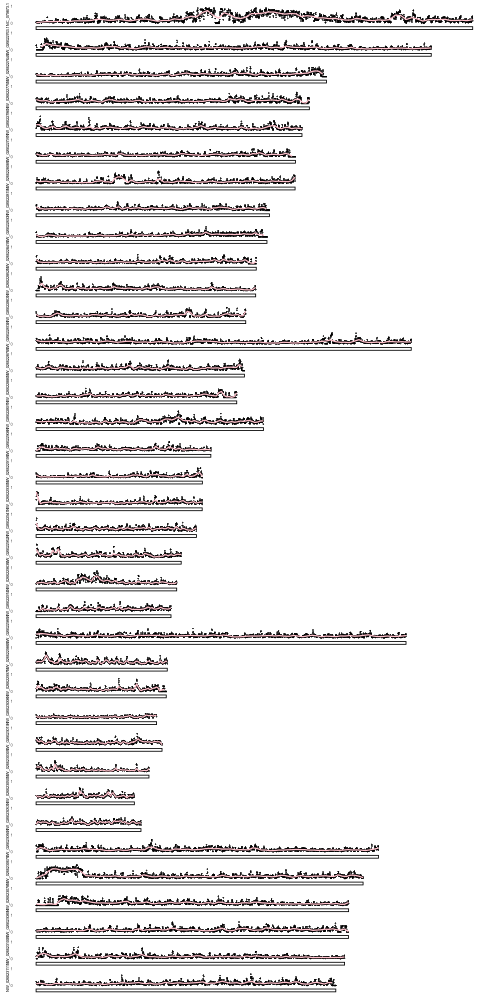

In [184]:
%%R -w 500 -h 1000

SPECIES <- 'brown'
FAMILY <- 'LINE/L1'

# Chromosomes to plot
#FOCAL <- paste0("SCAF_", 1:26)  # Or use actual chroms_keep list

# Load sizes and find maximum
chrom_sizes <- fread('chains/brown.sizes') %>%
  set_colnames(c('chrom','size')) %>%
    filter(chrom != 'NC_079874.1')
max_size <- max(chrom_sizes$size)
FOCAL = chrom_sizes$chrom

plot_list <- list()

for (chrom in FOCAL) {
  chr_size <- chrom_sizes %>% filter(chrom == !!chrom) %>% pull(size)

repeat_plot <- ggplot(
  repeat_family_density %>% 
    filter(refgenome == SPECIES, chrom == !!chrom, family == FAMILY)
) +
  rasterize(geom_point(aes(x = midpoint, y = repeat_coverage), size = 0.1, alpha = 0.6), dpi = 600) +
  geom_smooth(aes(x = midpoint, y = repeat_coverage), method = "loess", span = 0.05, se = FALSE, size = 0.6, col = 'pink') +
  scale_x_continuous(limits = c(0, max_size)) +
  scale_y_continuous(limits = c(0,1), breaks = c(0,1)) +
  labs(y = chrom) +
  theme_minimal(base_size = BASESIZE) +
  theme(
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    axis.title.y = element_text(angle = 90, vjust = 0.5, hjust = 0.5, size = BASESIZE),
    axis.text.y = element_text(size = BASESIZE),
    plot.margin = MARGINS,
    panel.spacing = unit(0, "lines"),
    panel.grid = element_blank()
  )

ideo_plot <- ggplot() +
  geom_rect(
    data = chrom_sizes %>% filter(chrom == !!chrom),
    aes(xmin = 0, xmax = size, ymin = -1, ymax = 0),
    size = 0.4, color = 'black', fill = 'white', alpha = 0.5
  ) +
  geom_point(
      data = breakpoints %>% filter(refgenome == SPECIES, eventtype == 'fusion', chrom == !!chrom),
      aes(x = end, y = -0.25),
      color = 'blue', fill = 'blue', shape = 24, size = SHAPESIZE, alpha = SHAPEALPHA
  ) +
  geom_point(
      data = breakpoints %>% filter(refgenome == SPECIES, eventtype == 'fission', chrom == !!chrom),
      aes(x = end, y = -0.75),
      color = 'red', fill = 'red', shape = 25, size = SHAPESIZE, alpha = SHAPEALPHA
  ) +
  scale_x_continuous(limits = c(0, max_size)) +
  scale_y_continuous(limits = SHAPELIMITS) +
  theme_minimal(base_size = BASESIZE) +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    plot.margin = MARGINS,
    panel.grid = element_blank()
  )

pair_plot <- repeat_plot / ideo_plot + plot_layout(heights = c(3, 1), guides = "collect")

  plot_list[[chrom]] <- pair_plot
}
# Stack all chromosome pairs
panda_plot <- wrap_plots(plot_list, ncol = 1)

print(panda_plot)
ggsave('rawfigs/brown_L1_ideogram.pdf', height = 10, width = 3)

### Supplemental boxplots

In [158]:
%%R
library(dplyr)
library(purrr)

num_tests = sum(sapply(c('spectacled','panda'),function(SPECIES){s_combined %>% filter(species == SPECIES) %>% pull(family) %>% unique %>% length}))
Bonf_p = 0.05 / num_tests

# Assuming your dataframe is called `df`
sig_families = list()
for (SPECIES in c('spectacled','panda')){
   results <- 
    s_combined %>%
        filter(species == SPECIES) %>%
        group_by(family,species) %>%
        filter(n_distinct(breakpoint) == 2) %>%  # Only test if there are exactly 2 groups to compare
        group_split() %>%
        map_df(~ {
          test_result <- t.test(repeat_coverage ~ breakpoint, data = .x)
    
    tibble(
      family = unique(.x$family),
      breakpoint_levels = paste(levels(factor(.x$breakpoint)), collapse = " vs "),
      p_value = test_result$p.value,
      t_statistic = test_result$statistic,
      mean_group_1 = test_result$estimate[1],
      mean_group_2 = test_result$estimate[2]
    )
  })
  sfam = 
    results %>%
    #filter(mean_group_2 > mean_group_1) %>%
    mutate(fold_change = mean_group_2/mean_group_1) %>%
    filter(p_value < Bonf_p) %>%
    dplyr::select(family,p_value,mean_group_1,mean_group_2, fold_change) %>% 
    arrange(desc(fold_change),p_value) %>%
    mutate(species = SPECIES)
  
  sig_families <- append(sig_families, list(sfam))
}

sig_families = bind_rows(sig_families)
sig_families %>% print(n = Inf)

# A tibble: 45 × 6
   family              p_value mean_group_1 mean_group_2 fold_change species   
   <chr>                 <dbl>        <dbl>        <dbl>       <dbl> <chr>     
 1 Unknown           1.65e- 16   0.00790      0.0948          12.0   spectacled
 2 LINE/R1           1.88e-  6   0.000179     0.00144          8.06  spectacled
 3 Satellite         3.60e-  6   0.000480     0.00232          4.83  spectacled
 4 DNA/TcMar-Tigger  6.52e- 28   0.00833      0.0260           3.12  spectacled
 5 LINE/L1           6.73e- 43   0.192        0.529            2.76  spectacled
 6 LINE/L2           4.04e- 24   0.0113       0.0296           2.63  spectacled
 7 LTR/ERV1          6.40e-  6   0.00926      0.0148           1.60  spectacled
 8 SINE/tRNA         4.74e- 13   0.0527       0.0441           0.837 spectacled
 9 Simple_repeat     3.31e-  6   0.0114       0.00914          0.805 spectacled
10 DNA/hAT-Charlie   1.81e- 28   0.00739      0.00429          0.580 spectacled
11 DNA/TcMar-Tc2     

`summarise()` has grouped output by 'V1', 'V2', 'V3', 'breakpoint'. You can
override using the `.groups` argument.


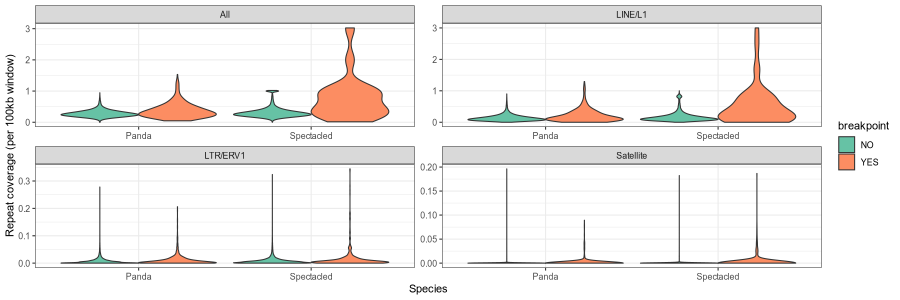

In [182]:
%%R -w 900 -h 300
chroms = 
    c(fread('chains/spectacled.sizes') %>% pull(V1),
     fread('chains/panda.sizes') %>% pull(V1)) %>%
    .[!grepl('SCAF_27',.)]


all_repeats = 
    combined %>%
    dplyr::select(V1,V2,V3,V7,family,breakpoint,species) %>%
    group_by(V1,V2,V3,breakpoint,species) %>%
    summarize(bp_overlap = sum(V7)) %>%
    ungroup %>%
    mutate(repeat_coverage = bp_overlap/100000, midpoint = ((V3-V2)/2) + V2, family = 'All') %>%
    dplyr::select(breakpoint,family,V1,V2,V3,bp_overlap,repeat_coverage,species) %>%
    set_colnames(c('breakpoint','family','query_chrom','query_start','query_end','bp_overlap','repeat_coverage','species'))

# Update species labels (capitalize them)
s_combined_mod <- 
    s_combined %>%
    bind_rows(.,all_repeats) %>%
    mutate(species = recode(species,
                          'panda' = 'Panda',
                          'spectacled' = 'Spectacled'))


# Create the plot with a different fill color palette
p = 
    ggplot(s_combined_mod %>% 
       filter(family %in% c('All','LINE/L1','Satellite','LTR/ERV1'), 
              species %in% c('Spectacled', 'Panda'),
              query_chrom %in% chroms)) +
  geom_violin(aes(x = species, y = repeat_coverage, fill = breakpoint), scale = 'width', adjust = 2) +
  scale_fill_brewer(palette = "Set2") +  # Try other palettes like "Paired", "Dark2", etc.
  labs(x = "Species", y = "Repeat coverage (per 100kb window)") +
  facet_wrap(~family, scales = 'free') +
  theme_bw()
print(p)
ggsave('rawfigs/repeat_boxplots.pdf',width = 7, height = 5)



In [173]:
%%R
combined %>%
    dplyr::select(V1,V2,V3,V7,family,breakpoint,species) %>%
    group_by(V1,V2,V3,breakpoint,species) %>%
    summarize(bp_overlap = sum(V7)) %>%
    ungroup %>%
    mutate(repeat_coverage = bp_overlap/100000, midpoint = ((V3-V2)/2) + V2, family = 'All') %>%
    dplyr::select(breakpoint,family,V1,V2,V3,bp_overlap,repeat_coverage,species) %>%
    set_colnames(c('breakpoint','family','query_chrom','query_start','query_end','bp_overlap','repeat_coverage','species')) %>%
    head

`summarise()` has grouped output by 'V1', 'V2', 'V3', 'breakpoint'. You can
override using the `.groups` argument.
# A tibble: 6 × 8
  breakpoint family query_chrom query_start query_end bp_overlap repeat_coverage
  <chr>      <chr>  <chr>             <int>     <int>      <int>           <dbl>
1 NO         All    NC_003427.1           0     17020        572         0.00572
2 NO         All    NC_009492.1           0     16805        330         0.0033 
3 NO         All    NC_048218.1           0    100000      27790         0.278  
4 NO         All    NC_048218.1       50000    150000      29722         0.297  
5 NO         All    NC_048218.1      100000    200000      34388         0.344  
6 NO         All    NC_048218.1      150000    250000      32267         0.323  
# ℹ 1 more variable: species <chr>


In [172]:
%%R
print(head(all_repeats_density))
print(head(s_combined))

# A tibble: 6 × 7
  chrom        start    end refgenome bp_overlap repeat_coverage midpoint
  <chr>        <int>  <int> <chr>          <int>           <dbl>    <dbl>
1 NC_003427.1      0  17020 brown            572         0.00572    8510 
2 NC_009492.1      0  16805 panda            330         0.0033     8402.
3 NC_048218.1      0 100000 panda          27790         0.278     50000 
4 NC_048218.1  50000 150000 panda          29722         0.297    100000 
5 NC_048218.1 100000 200000 panda          34388         0.344    150000 
6 NC_048218.1 150000 250000 panda          32267         0.323    200000 
# A tibble: 6 × 8
  breakpoint family query_chrom query_start query_end bp_overlap repeat_coverage
  <chr>      <chr>  <chr>             <int>     <int>      <int>           <dbl>
1 NO         DNA/C… NC_009492.1           0     16805          0               0
2 NO         DNA/C… NC_048218.1           0    100000          0               0
3 NO         DNA/C… NC_048218.1       50000    1

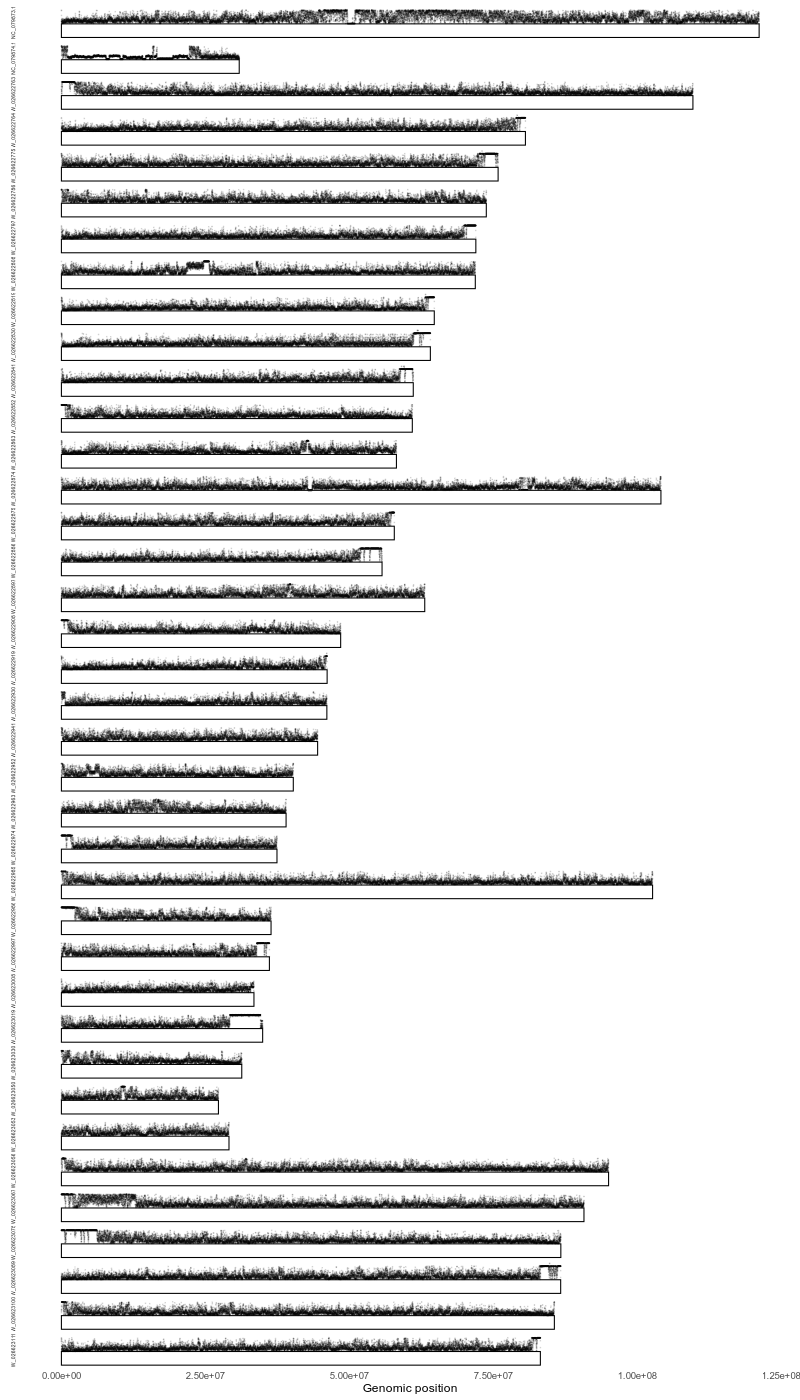

In [579]:
%%R -w 800 -h 1400

##
chroms_keep = chroms$chrom
species = 'brown'

##
ggplot(all_repeats_density %>% filter(refgenome == species, chrom %in% chroms_keep)) +
  geom_point(aes(x = midpoint, y = repeat_coverage), size = 0.25, alpha = 0.1) +
  #geom_smooth(aes(x = midpoint, y = repeat_coverage), method = "loess", span = 0.1, se = FALSE, size = 1, col = 'red') +
  geom_rect(
    data = chroms %>% filter(refgenome == species),
    aes(xmin = 0, xmax = size, ymin = -1, ymax = 0),
    size = 0.5, color = 'black', fill = 'white', alpha = 0.5
  ) +
  geom_rect(
    data = breakpoints %>% filter(refgenome == species, eventtype == 'fusion'),
    aes(xmin = Bstart, xmax = Bend, ymin = -1, ymax = -0.5),
      color = 'blue', fill = 'blue', alpha = 0.5, size = 1
  ) +
  geom_rect(
    data = breakpoints %>% filter(refgenome == species, eventtype == 'fission'),
    aes(xmin = Bstart, xmax = Bend, ymin = -0.5, ymax = 0),
      color = 'red', fill = 'red', alpha = 0.5, size = 1
  ) +
  facet_wrap(~chrom, ncol = 1, strip.position = "left", labeller = label_value) +
  theme_minimal(base_size = 12) +
  theme(
    strip.text = element_text(angle = 0, hjust = 0.5,size = 5),   # Y-axis-style chromosome labels
    strip.placement = "outside",
    strip.background = element_blank(),
    axis.text.y = element_blank(),                     # Remove y-axis ticks
    axis.ticks.y = element_blank(),
    axis.title.y = element_blank(),
    panel.spacing = unit(0.2, "lines"),
    panel.grid = element_blank()
  ) +
  ylab("Repeat coverage") +
  xlab("Genomic position")

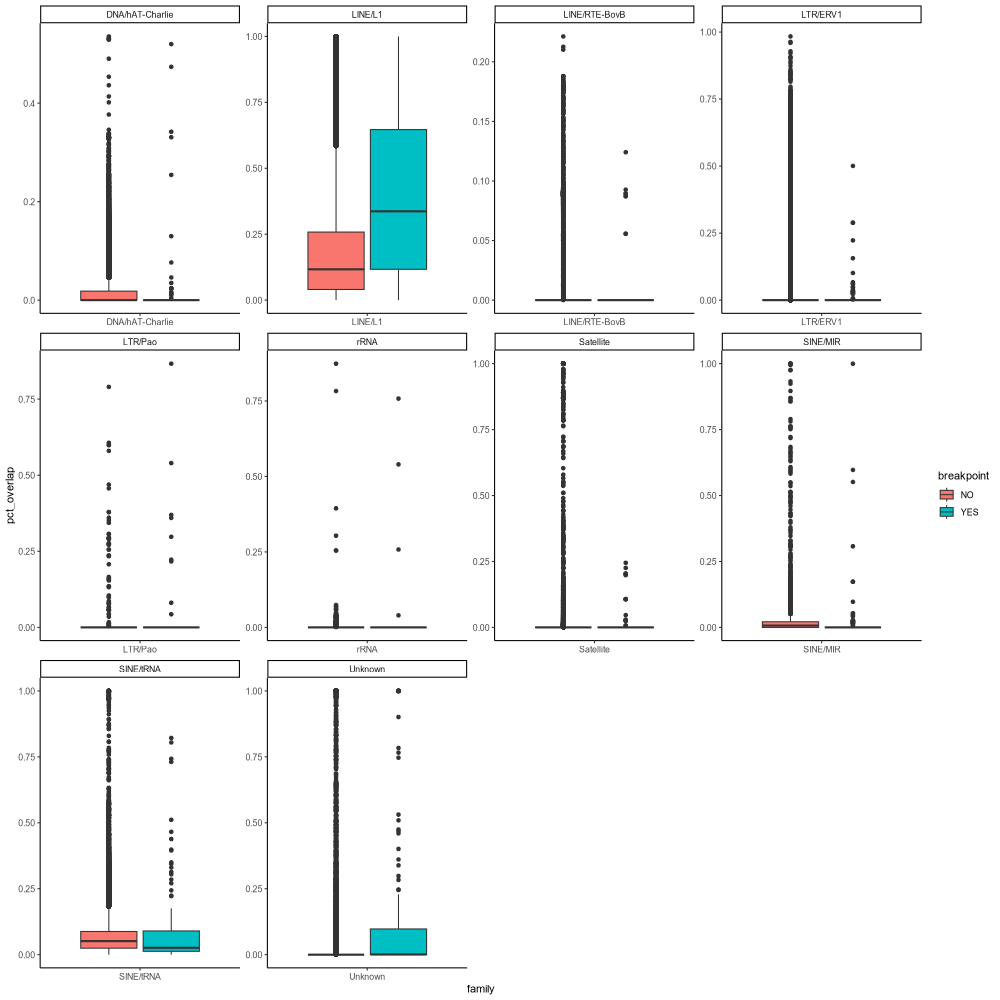

In [160]:
%%R -w 1000 -h 1000
focal = 
    results %>%
    filter(mean_group_2 > mean_group_1) %>%
    arrange(p_value) %>%
    head(10) %>% 
    pull(family)
ggplot(s_combined %>% filter(family %in% focal)) +
    geom_boxplot(aes(x=family,y=pct_overlap,fill=breakpoint)) +
    facet_wrap(~family,scales='free') +
    theme_classic()